## Bias and efficiency
The focus of these simulations is to show how altering a model, to avoid collinear regressors, can result in biased estimates of parameter estimates. Although efficiency is preferred, it is less important than bias in terms of interpreting contrast estimates.

An fMRI model should include a regressor for each stimulus that occurs.  Since the cue/fixation/probe/feedback stimuli are presented without any baseline fixation between them, modeling all stimuli is often avoided, presumably in fear that the lowered efficiency will reduce power.  The less appreciated, more important issue is the bias that results when this modeling practice is used.

In these simulations we illustrate the bias that can be introduced when all stimuli are not modeled.  Often stimulus-related regressors are omitted from a model in hopes of improving contrast estimation efficiency and stability of estimates (as measured by the variance inflation factor), so we have also quantified the efficiency of contrasts and VIF for a saturated model vs a model that only includes cue and feedback regressors.  As described below, it is difficult to assess whether efficiency and VIF differences will result in power differences, so we pair the efficiency/VIF analyses of the design matrices from real data with the real data analysis comparison of group 1-sample t-tests and ICC comparisons to assess power of group averages and individual difference analyses, respectively [NOTE: THESES ANALYSES ARE TBD].

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm
from scipy.stats import ttest_1samp
import pickle
from collections import OrderedDict
from nilearn.plotting import plot_design_matrix

from simulation_funcs import (
    get_subdata_long,
    insert_jitter,
    create_design_matrices,
    generate_data_nsim,
    get_beta_dicts,
    create_contrasts,
    make_analysis_label,
    sim_group_models_parallel,
    est_eff_vif_all_subs,
    set_regressor_order,
)

from simulation_plotting import (
    plot_proportion_sig,
    plot_contrast_estimates,
    plot_results,
    plot_dict_of_results,
    plot_design_ordered_regressors,
    plot_bias,
)

## Simulation setup

These simulations focus on the following models:
* saturated:  Models 5 cue regressors (2 levels of gain/loss and no money at stake), 5 similar fixation regressors, 5 probe regressors (when RT is unknown) and 10 feedback regressors (5 trial types x hit/miss)
* cue only: Model includes 5 cue regressors and 10 feedback regressors
* cuefix: Model includes 5 regressors using the cue onset and cue+fixation durations and 10 feedback regressors

The models for  one subject are displayed below


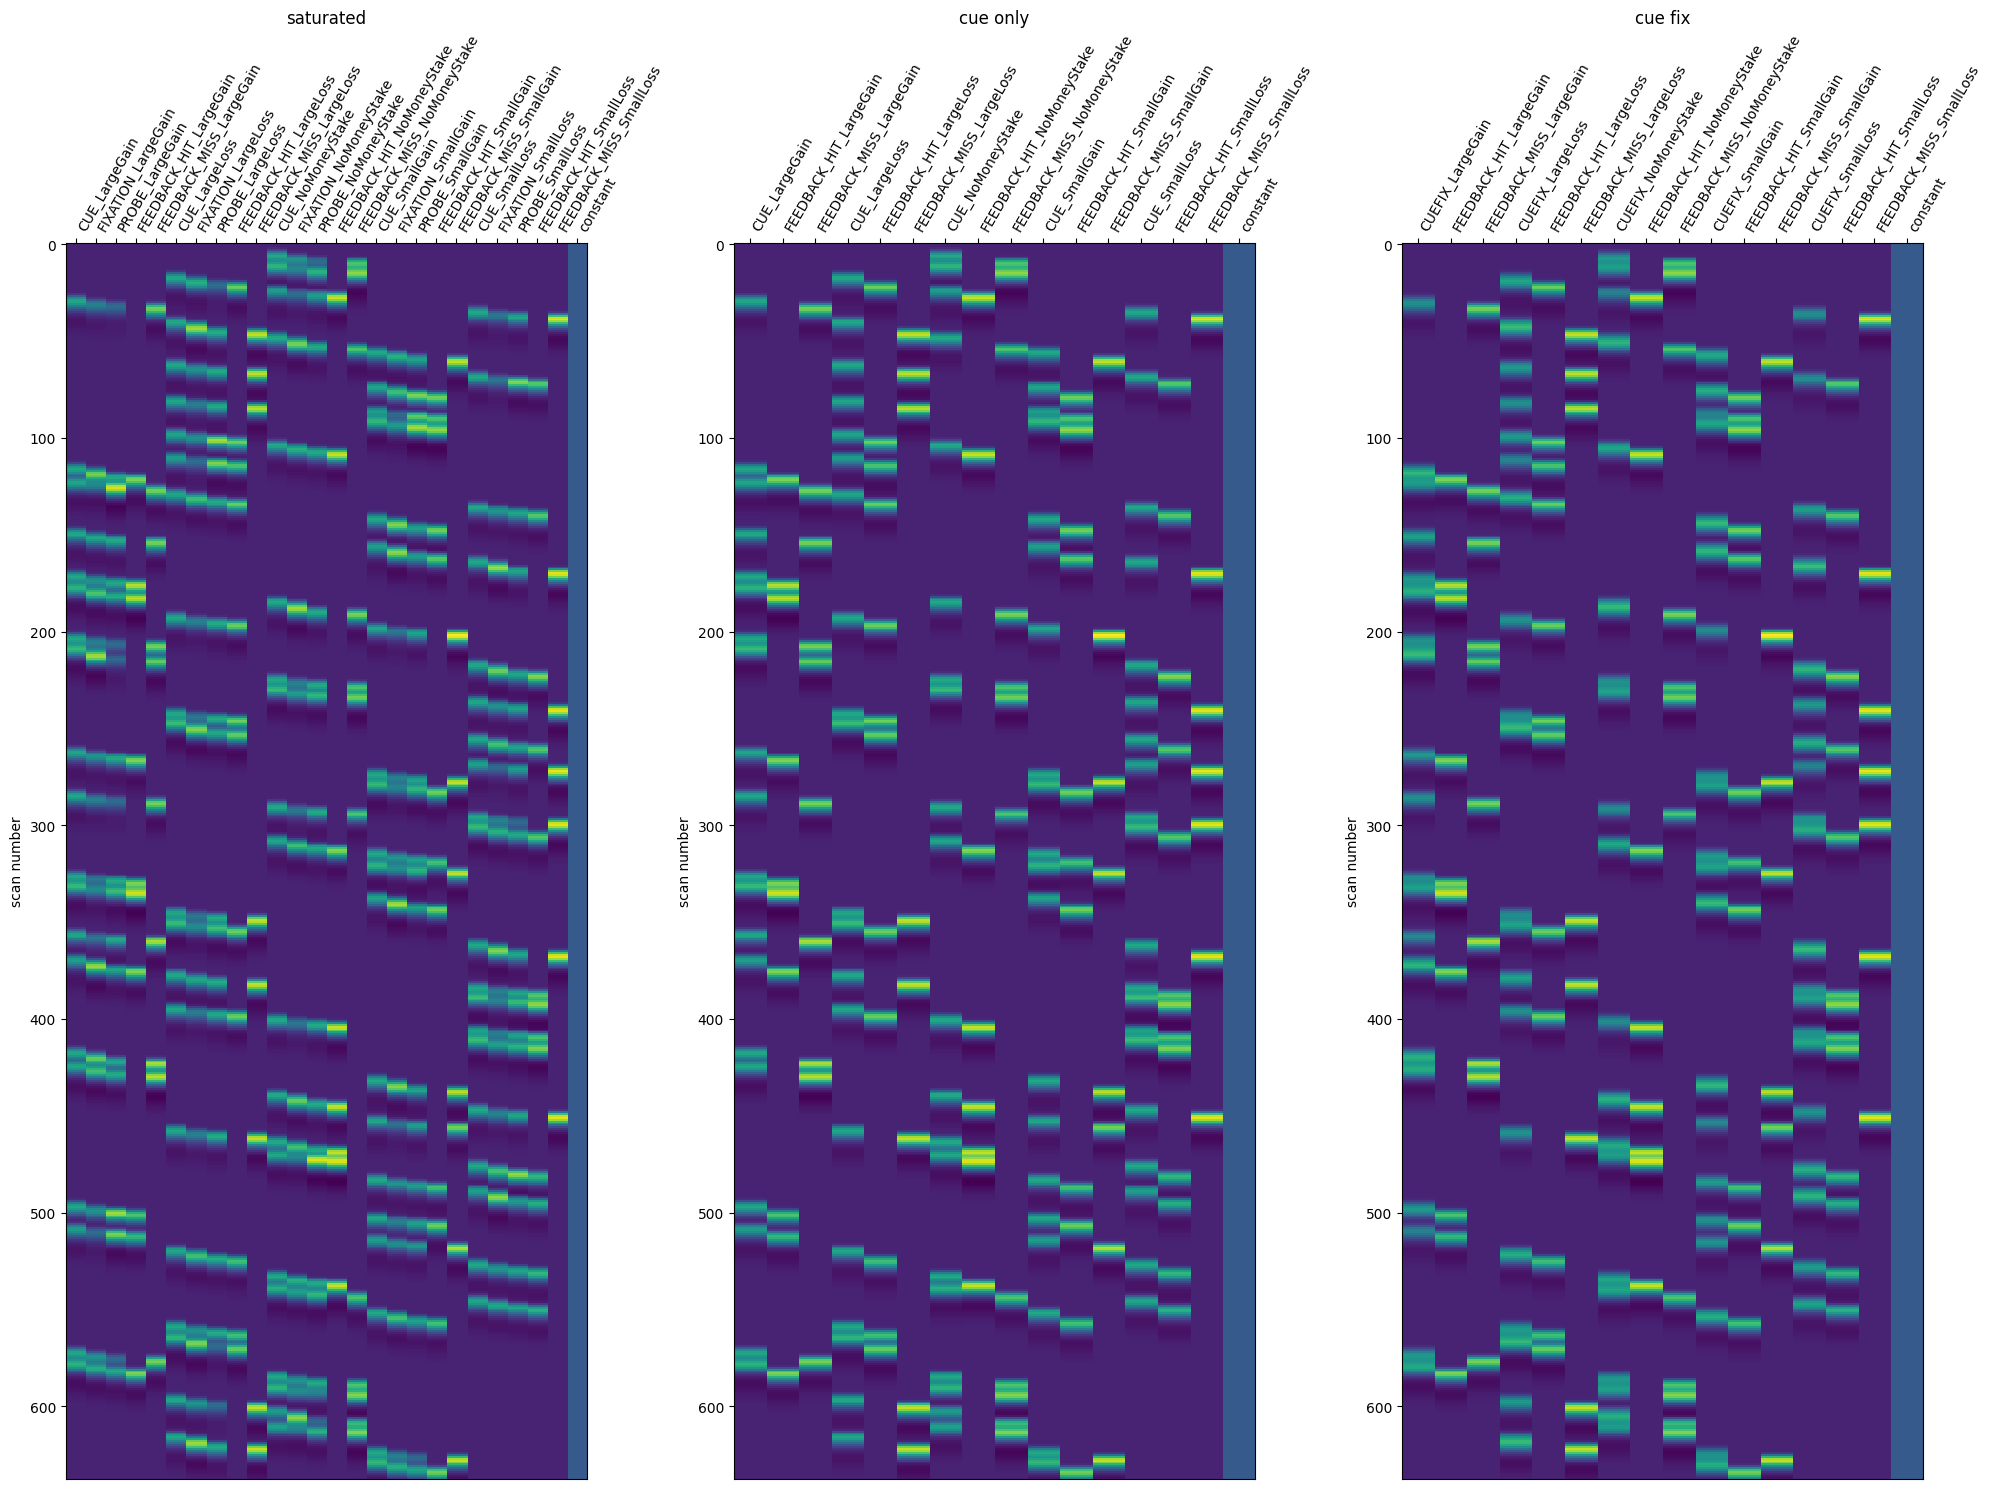

In [2]:
sub = 1
events = get_subdata_long(sub)
designs  = create_design_matrices(events, conv_resolution=.2, tr=1)

fig, ax = plt.subplots(1, 3, figsize=(20, 15))
ax_flat = ax.flatten()
for i, desname in enumerate(designs.keys()):
    plot_design_ordered_regressors(designs[desname], desname, ax=ax_flat[i])
plt.show()


### The main contrasts of interest 
* Anticipation: Win - Neutral
* Anticipation: Large Win - Neutral
* Feedback: WinHit - Neutral Miss
* Feedback: Large Win Hit - Large Win Miss
The definitions for each of these contrasts for each model are given below.

In [3]:
contrast_strings, contrasts_matrices, c_pinv_xmats = create_contrasts(designs)
for key, contrasts in contrast_strings.items():
    print(f'\n Contrasts for {key} model')
    for contrast_name, contrast_string in contrasts.items():
        if ':' in contrast_name:
            print(f'{contrast_name}: {contrast_string}')



 Contrasts for saturated model
ANT: W-Neut: .5 * CUE_LargeGain  + .5 * CUE_SmallGain - 1 * CUE_NoMoneyStake
ANT: LW-Neut: 1 * CUE_LargeGain - 1 * CUE_NoMoneyStake
FB: WHit-NeutHit: .5 * FEEDBACK_HIT_LargeGain + .5 * FEEDBACK_HIT_SmallGain - 1 * FEEDBACK_HIT_NoMoneyStake
FB: LWHit-LWMiss: 1 * FEEDBACK_HIT_LargeGain - 1 * FEEDBACK_MISS_LargeGain

 Contrasts for cue only model
ANT: W-Neut: .5 * CUE_LargeGain + .5 * CUE_SmallGain - 1 * CUE_NoMoneyStake
ANT: LW-Neut: 1 * CUE_LargeGain - 1 * CUE_NoMoneyStake
FB: WHit-NeutHit: .5 * FEEDBACK_HIT_LargeGain + .5 * FEEDBACK_HIT_SmallGain - 1 * FEEDBACK_HIT_NoMoneyStake
FB: LWHit-LWMiss: 1 * FEEDBACK_HIT_LargeGain - 1 * FEEDBACK_MISS_LargeGain

 Contrasts for cue fix model
ANT: W-Neut: .5 * CUEFIX_LargeGain + .5 * CUEFIX_SmallGain - 1 * CUEFIX_NoMoneyStake
ANT: LW-Neut: 1 * CUEFIX_LargeGain - 1 * CUEFIX_NoMoneyStake
FB: WHit-NeutHit: .5 * FEEDBACK_HIT_LargeGain + .5 * FEEDBACK_HIT_SmallGain - 1 * FEEDBACK_HIT_NoMoneyStake
FB: LWHit-LWMiss: 1 * FE

### Effect sizes and variance settings
The model used to simulate data was the saturated model.  The null model (all true betas were set to 0) and 6 non-null models were simulated, where the nonzero betas are define below in `beta_dicts`. It is hard to know what a reasonable within- and between-subject variance would be.  We simply set the between-subject variance to 1 and the within-subject residual variance was set to 1.  As such, we cannot make any claims about power differences here, since that would require properly setting the variances to realistic values based on data.  Instead, we have opted to run the model comparisons on real data to show any power differences, barring the presence of bias.

A totall of 1000 simulated data sets were generated.  Each data set has 107 subjects and the timings are based on the AHRB data.  Data were simulated, with the given beta settings and then contrasts were estimated using each model.  The contrast estimates were then averaged over subjects and the inference from the 1-sample t-test was used to determine significance using a 2-tailed test p-value < 0.05.

In [4]:
# Run all simulations without jitter
#  Note, the error for subject 5 is due to a problem with their file, so they have been omitted from the simulations.
beta_dicts = get_beta_dicts()

beta_sub_sd = 1
noise_sd = 1
nsims = 1000
results = {}

for beta_dict in beta_dicts:
    print(beta_dict)
    figure_label = make_analysis_label(beta_dict)
    results[figure_label], _, model_example = sim_group_models_parallel(
        beta_dict, 
        noise_sd, 
        beta_sub_sd, 
        nsims=nsims, 
        conv_resolution=.2, 
        tr=1
        )


{}
Error loading sub 5
bad parsing
{'CUE_LargeGain': 0.4, 'CUE_SmallGain': 0.4}
Error loading sub 5
bad parsing
{'FIXATION_LargeGain': 0.5, 'FIXATION_SmallGain': 0.5}
Error loading sub 5
bad parsing
{'CUE_LargeGain': 0.25, 'CUE_SmallGain': 0.25, 'FIXATION_LargeGain': 0.25, 'FIXATION_SmallGain': 0.25}
Error loading sub 5
bad parsing
{'PROBE_LargeGain': 1, 'PROBE_SmallGain': 1}
Error loading sub 5
bad parsing
{'FEEDBACK_HIT_LargeGain': 0.4, 'FEEDBACK_HIT_SmallGain': 0.4}
Error loading sub 5
bad parsing
{'FEEDBACK_HIT_LargeGain': 0.2, 'FEEDBACK_MISS_LargeGain': -0.2}
Error loading sub 5
bad parsing


## Type I errors are controlled when there is no signal
The following figure show the proportion of significant results out of the 1000 simulated data sets and the distributions of the group contrast estimates.  Bars and violins that are opaque (all in the this figure) reflect contrasts that should be null.  In the left panel (Proportion significant) all bars reflect Type I error rates and these are controlled for all contrasts and models.  In the right panel, since all contrasts reflect null effects, the distributions of the coefficient estimates should be, and are, centered about 0.

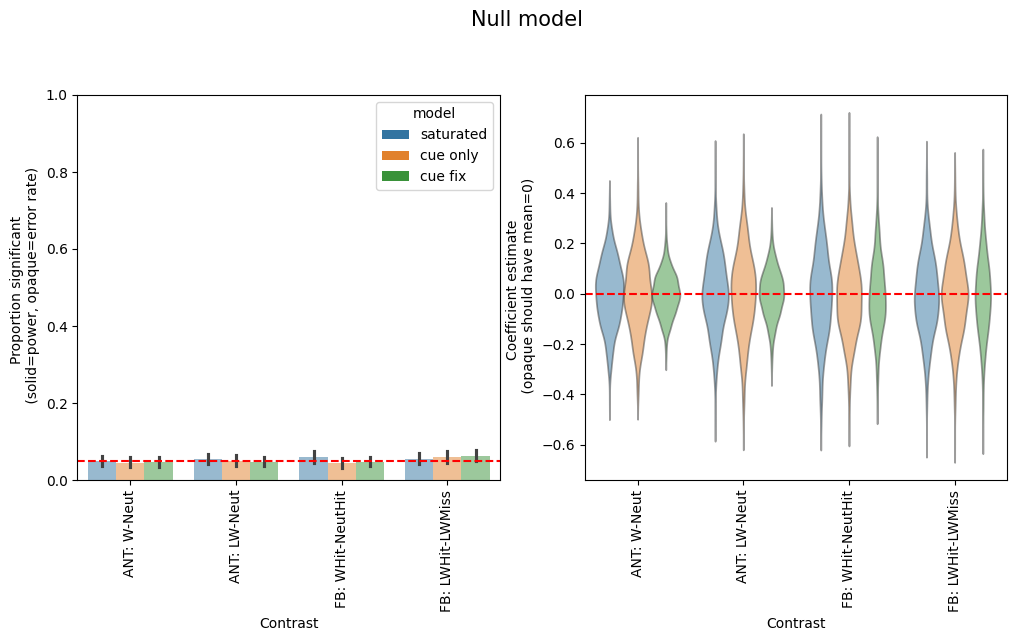

In [5]:
plot_dict_of_results({'Null model': results['Null model']}, contrasts=True)

## Parsing the results
Error rates, power and bias for the four contrasts of interest. Each panel grouping in the following figure refers to different settings where some parameters are nonzero as indicated in the panel pair figure headings.  Solid colored bars/violins reflect contrasts that should have signal, while opaque reflects null models.  If an opaque bar is above 0.05 (dashed red line), this indicates an inflated Type I error for that model and contrast combination.  The corresponding distributions of coefficient estimates will reflect the bias that occurs when the error rate is inflated.  Notably, bias can occur for null and non-null effects.

For all settings the saturated model has controlled error rates.  Although the power is lower for the anticipation-based contrasts when both the cue and fixation regressors for Large/Small Gain are nonzero, this is because the Anticipation contrast only uses the cue regressor. If one hypothesized the entirety of the cue and fixation periods capture anticipatory activation, then the proper contrast would sum the estimates for cue and fixation and would have power similar to the cuefix model. 

When both the small and large gain cue regressors have nonzero betas (=0.4), the cue fix model does not properly fit the signal (the duration of the regressor is too long).  Intuitively one might think this would bias the feedback regressor, but due to collinearity between the feedback regressor of a given trial and the cue regressor of the following trial, feedback estimates for the non-Gain trials tend to be negatively biased, which causes the bias seen in FB: WHit-NeutHit in the cue fix model.  In the simulates that include a jittered ITI, shown below, the bias of this contrast remains, but is instead driven by bias in the feedback estimate for Gain trials being positively biased, since the collinearity is changed with the addition of the ITI.

As expected, unmodled probe effects bias the feedback contrast comparing Hits versus Misses of gain trials versus neutral trials.  When signal is only present for the feedback regressors, type I errors are preserved across all models and contrasts.

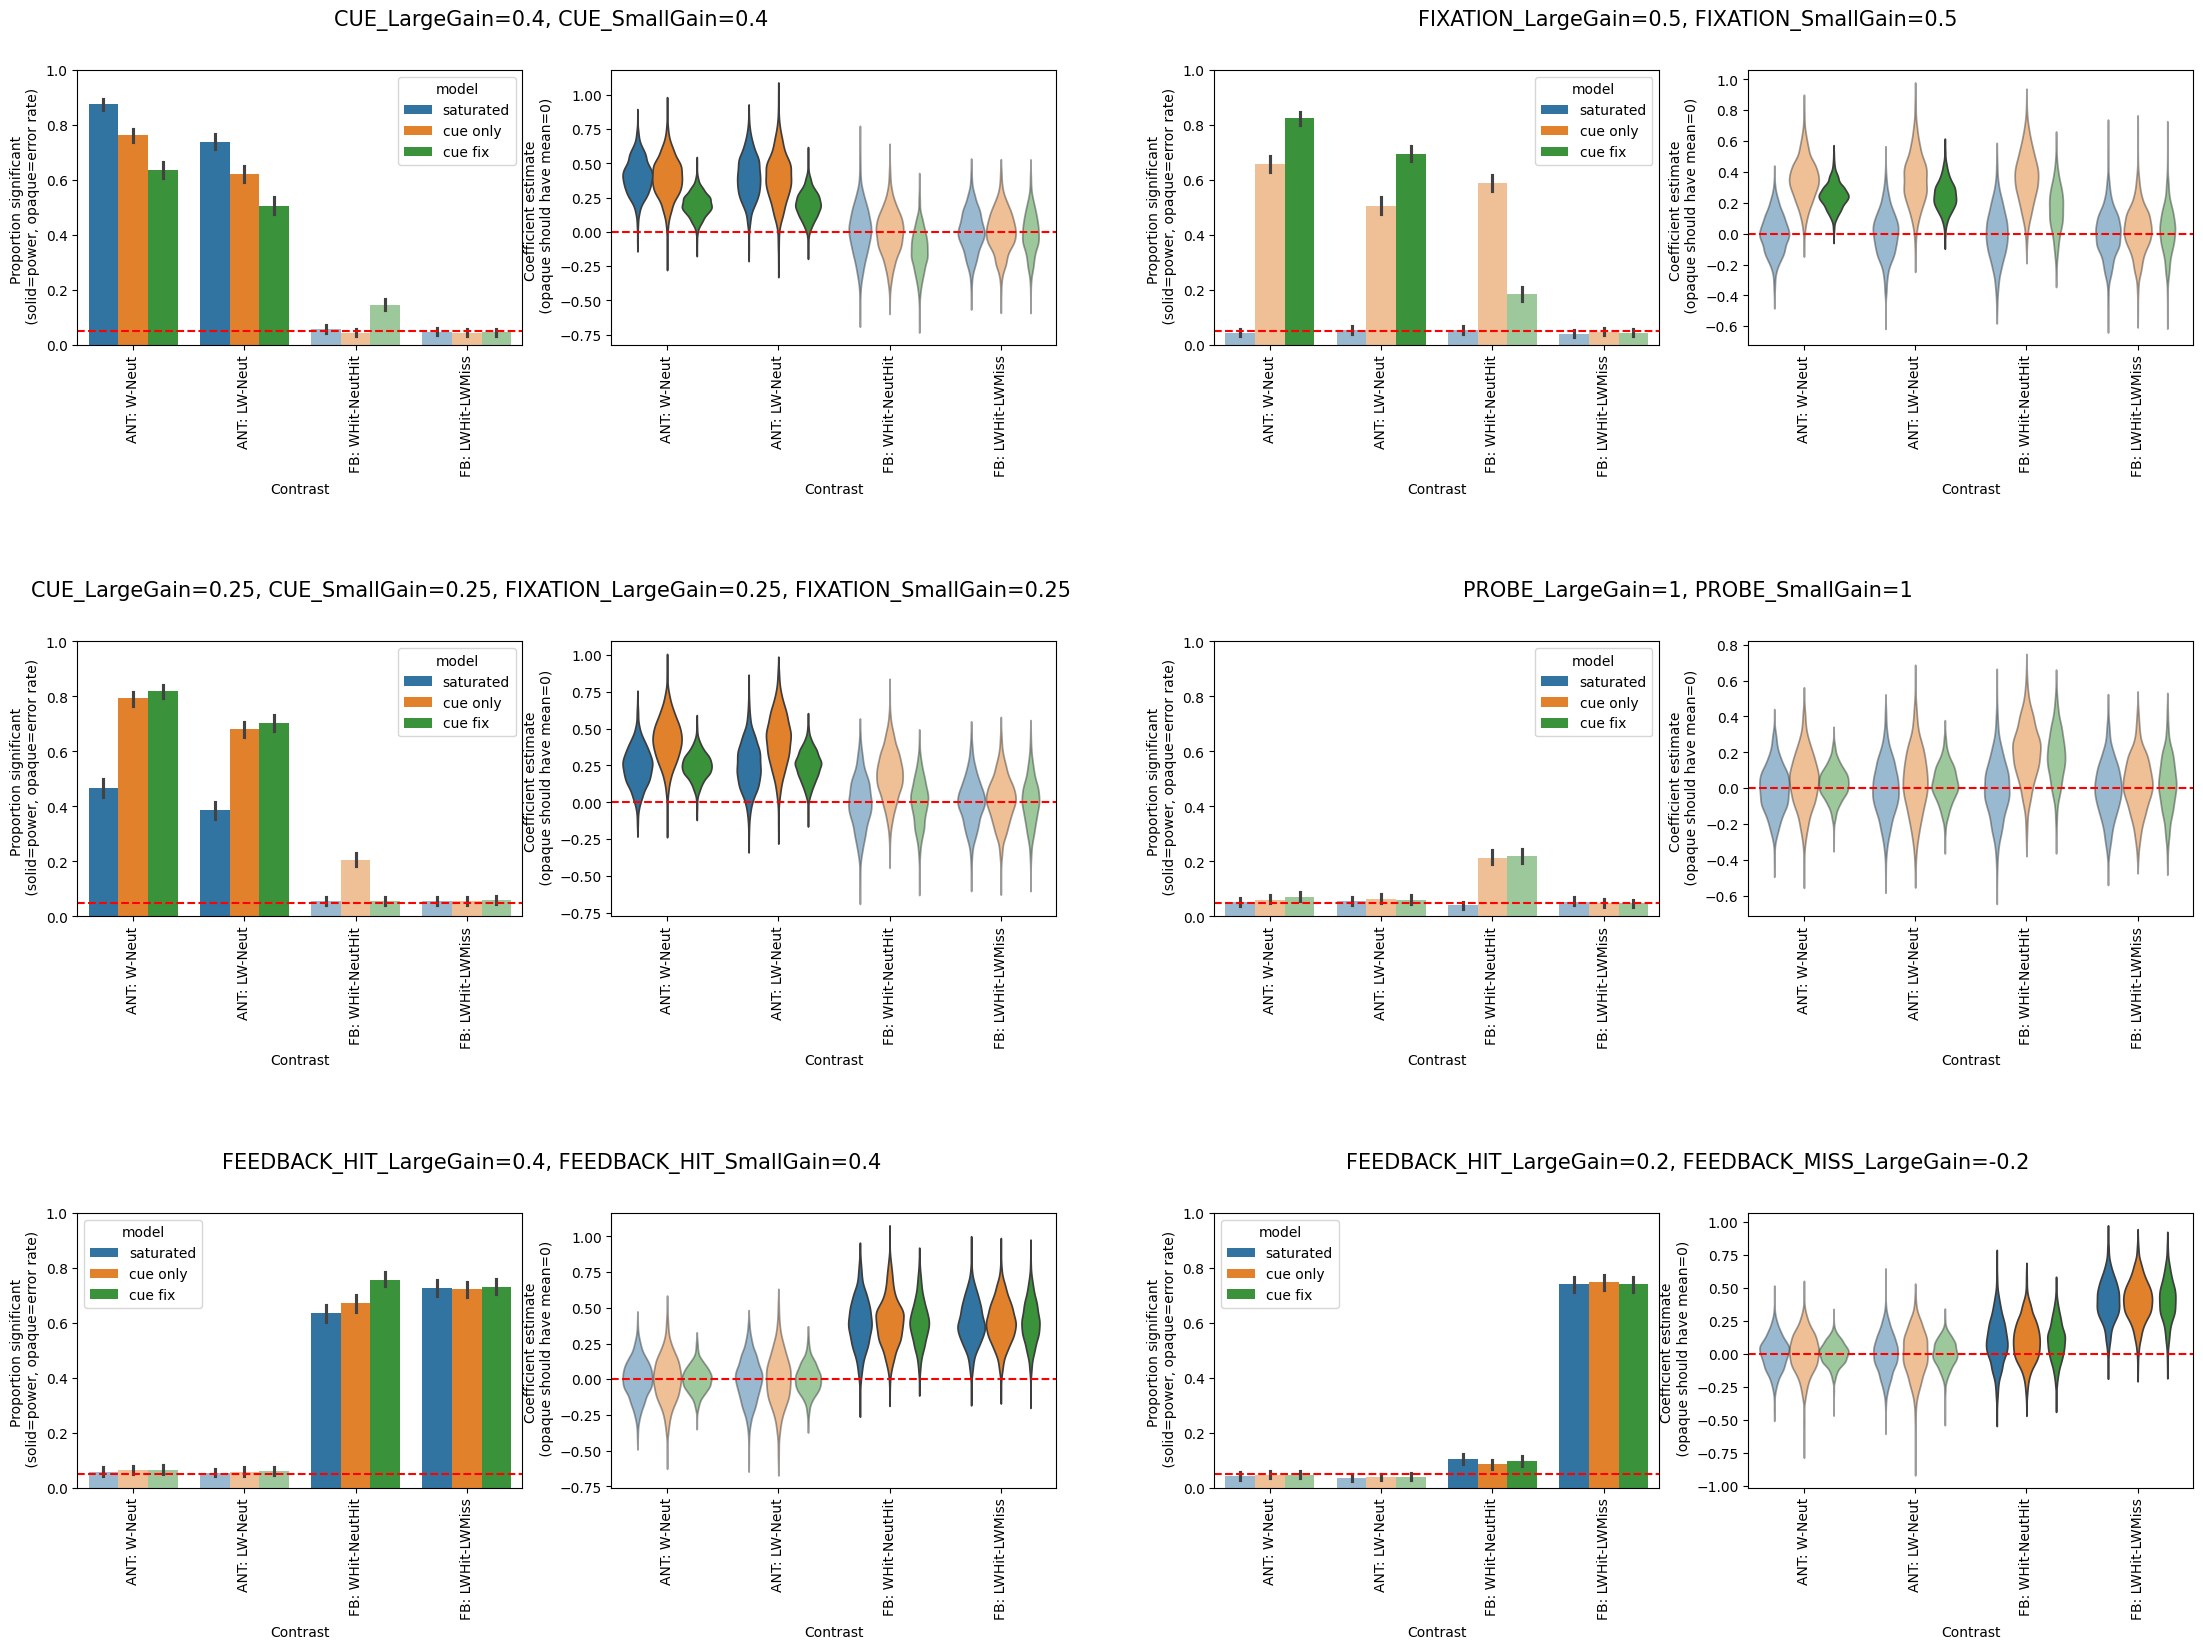

In [6]:
results_plot = results.copy()
results_plot.pop('Null model')
plot_dict_of_results(results_plot, contrasts=True)


### Bias of individual regressors

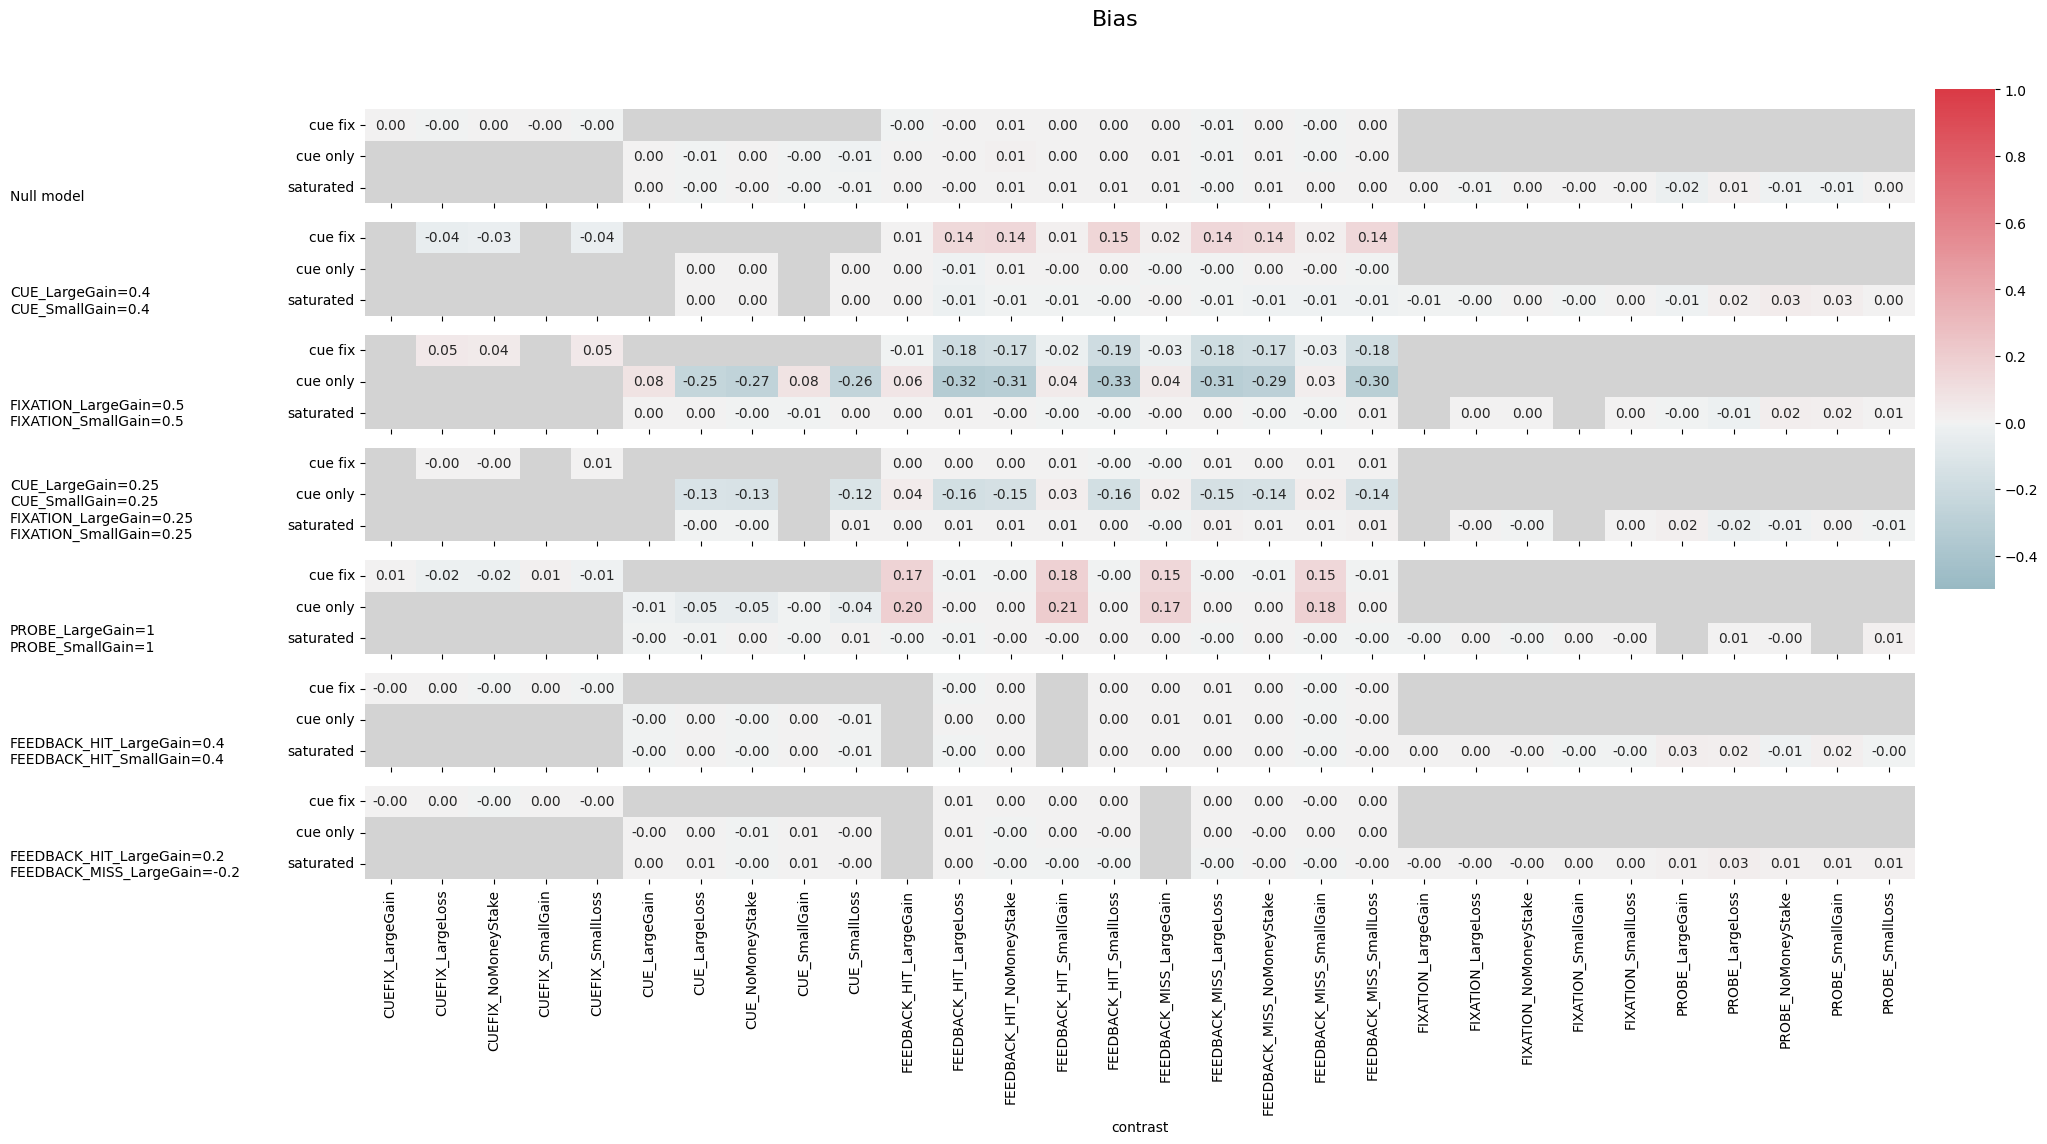

In [7]:
plot_bias(results)

### Another way of visualizing bias
Essentially the same information as was presented in the above tables.

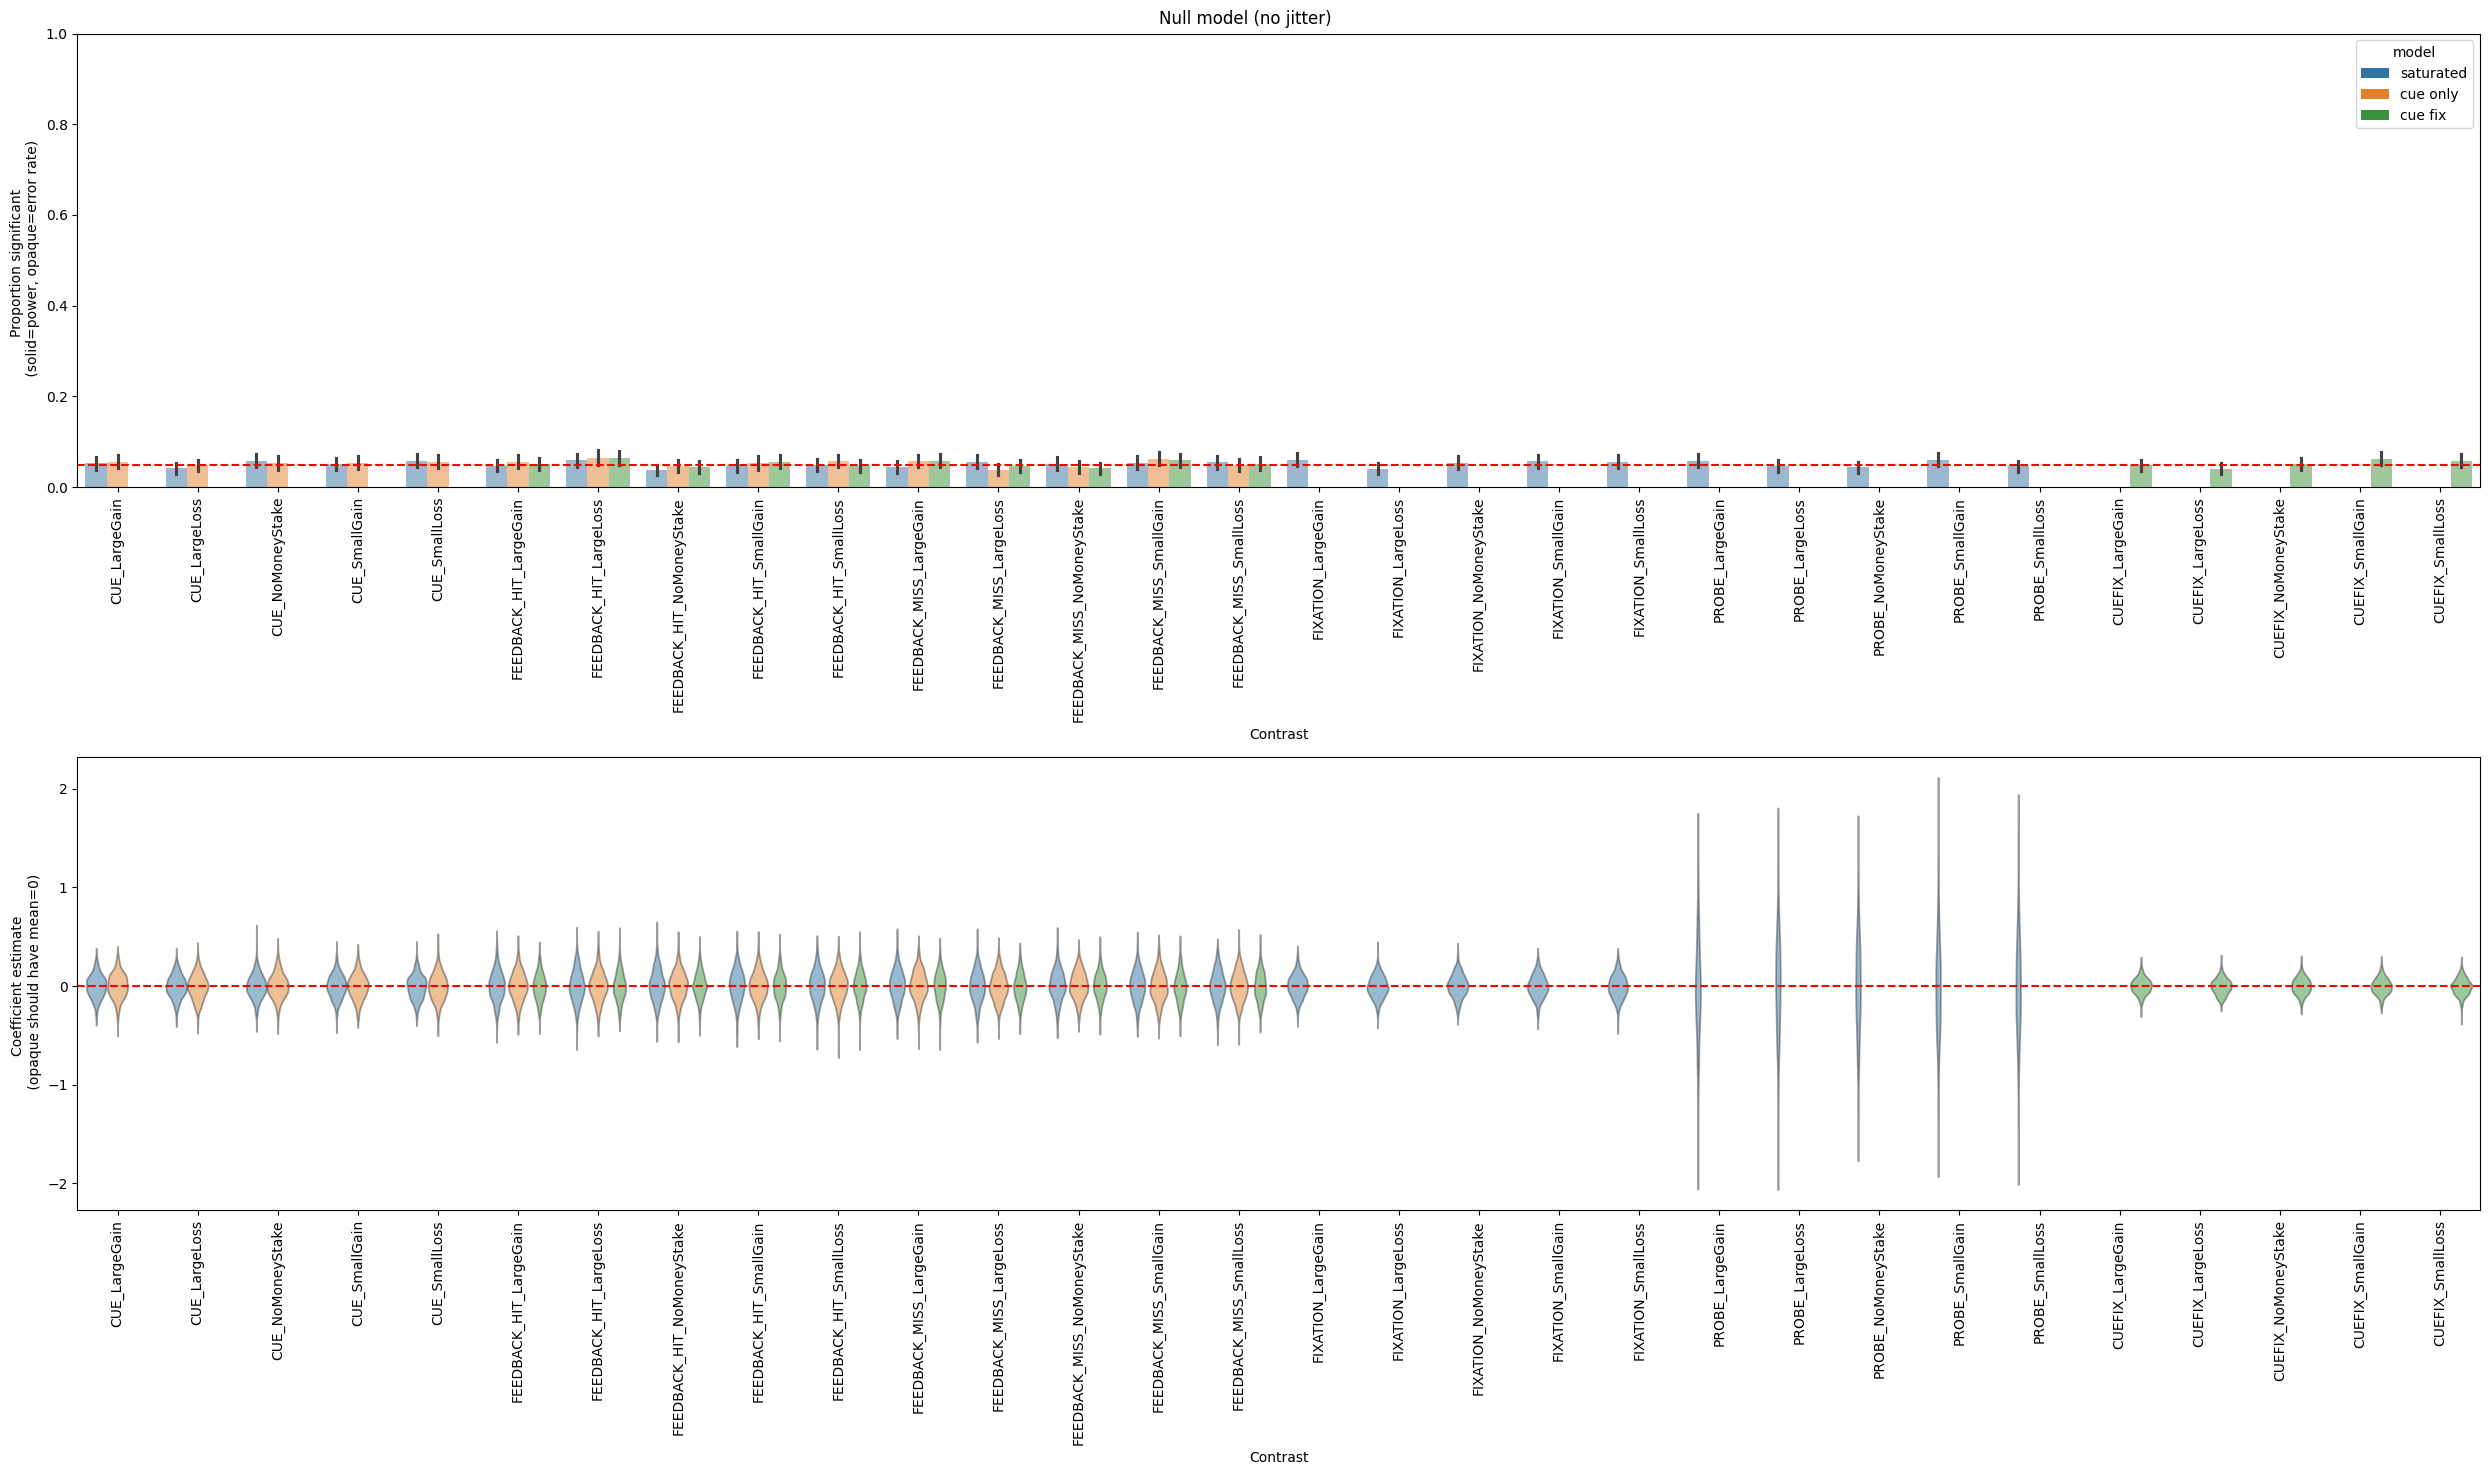

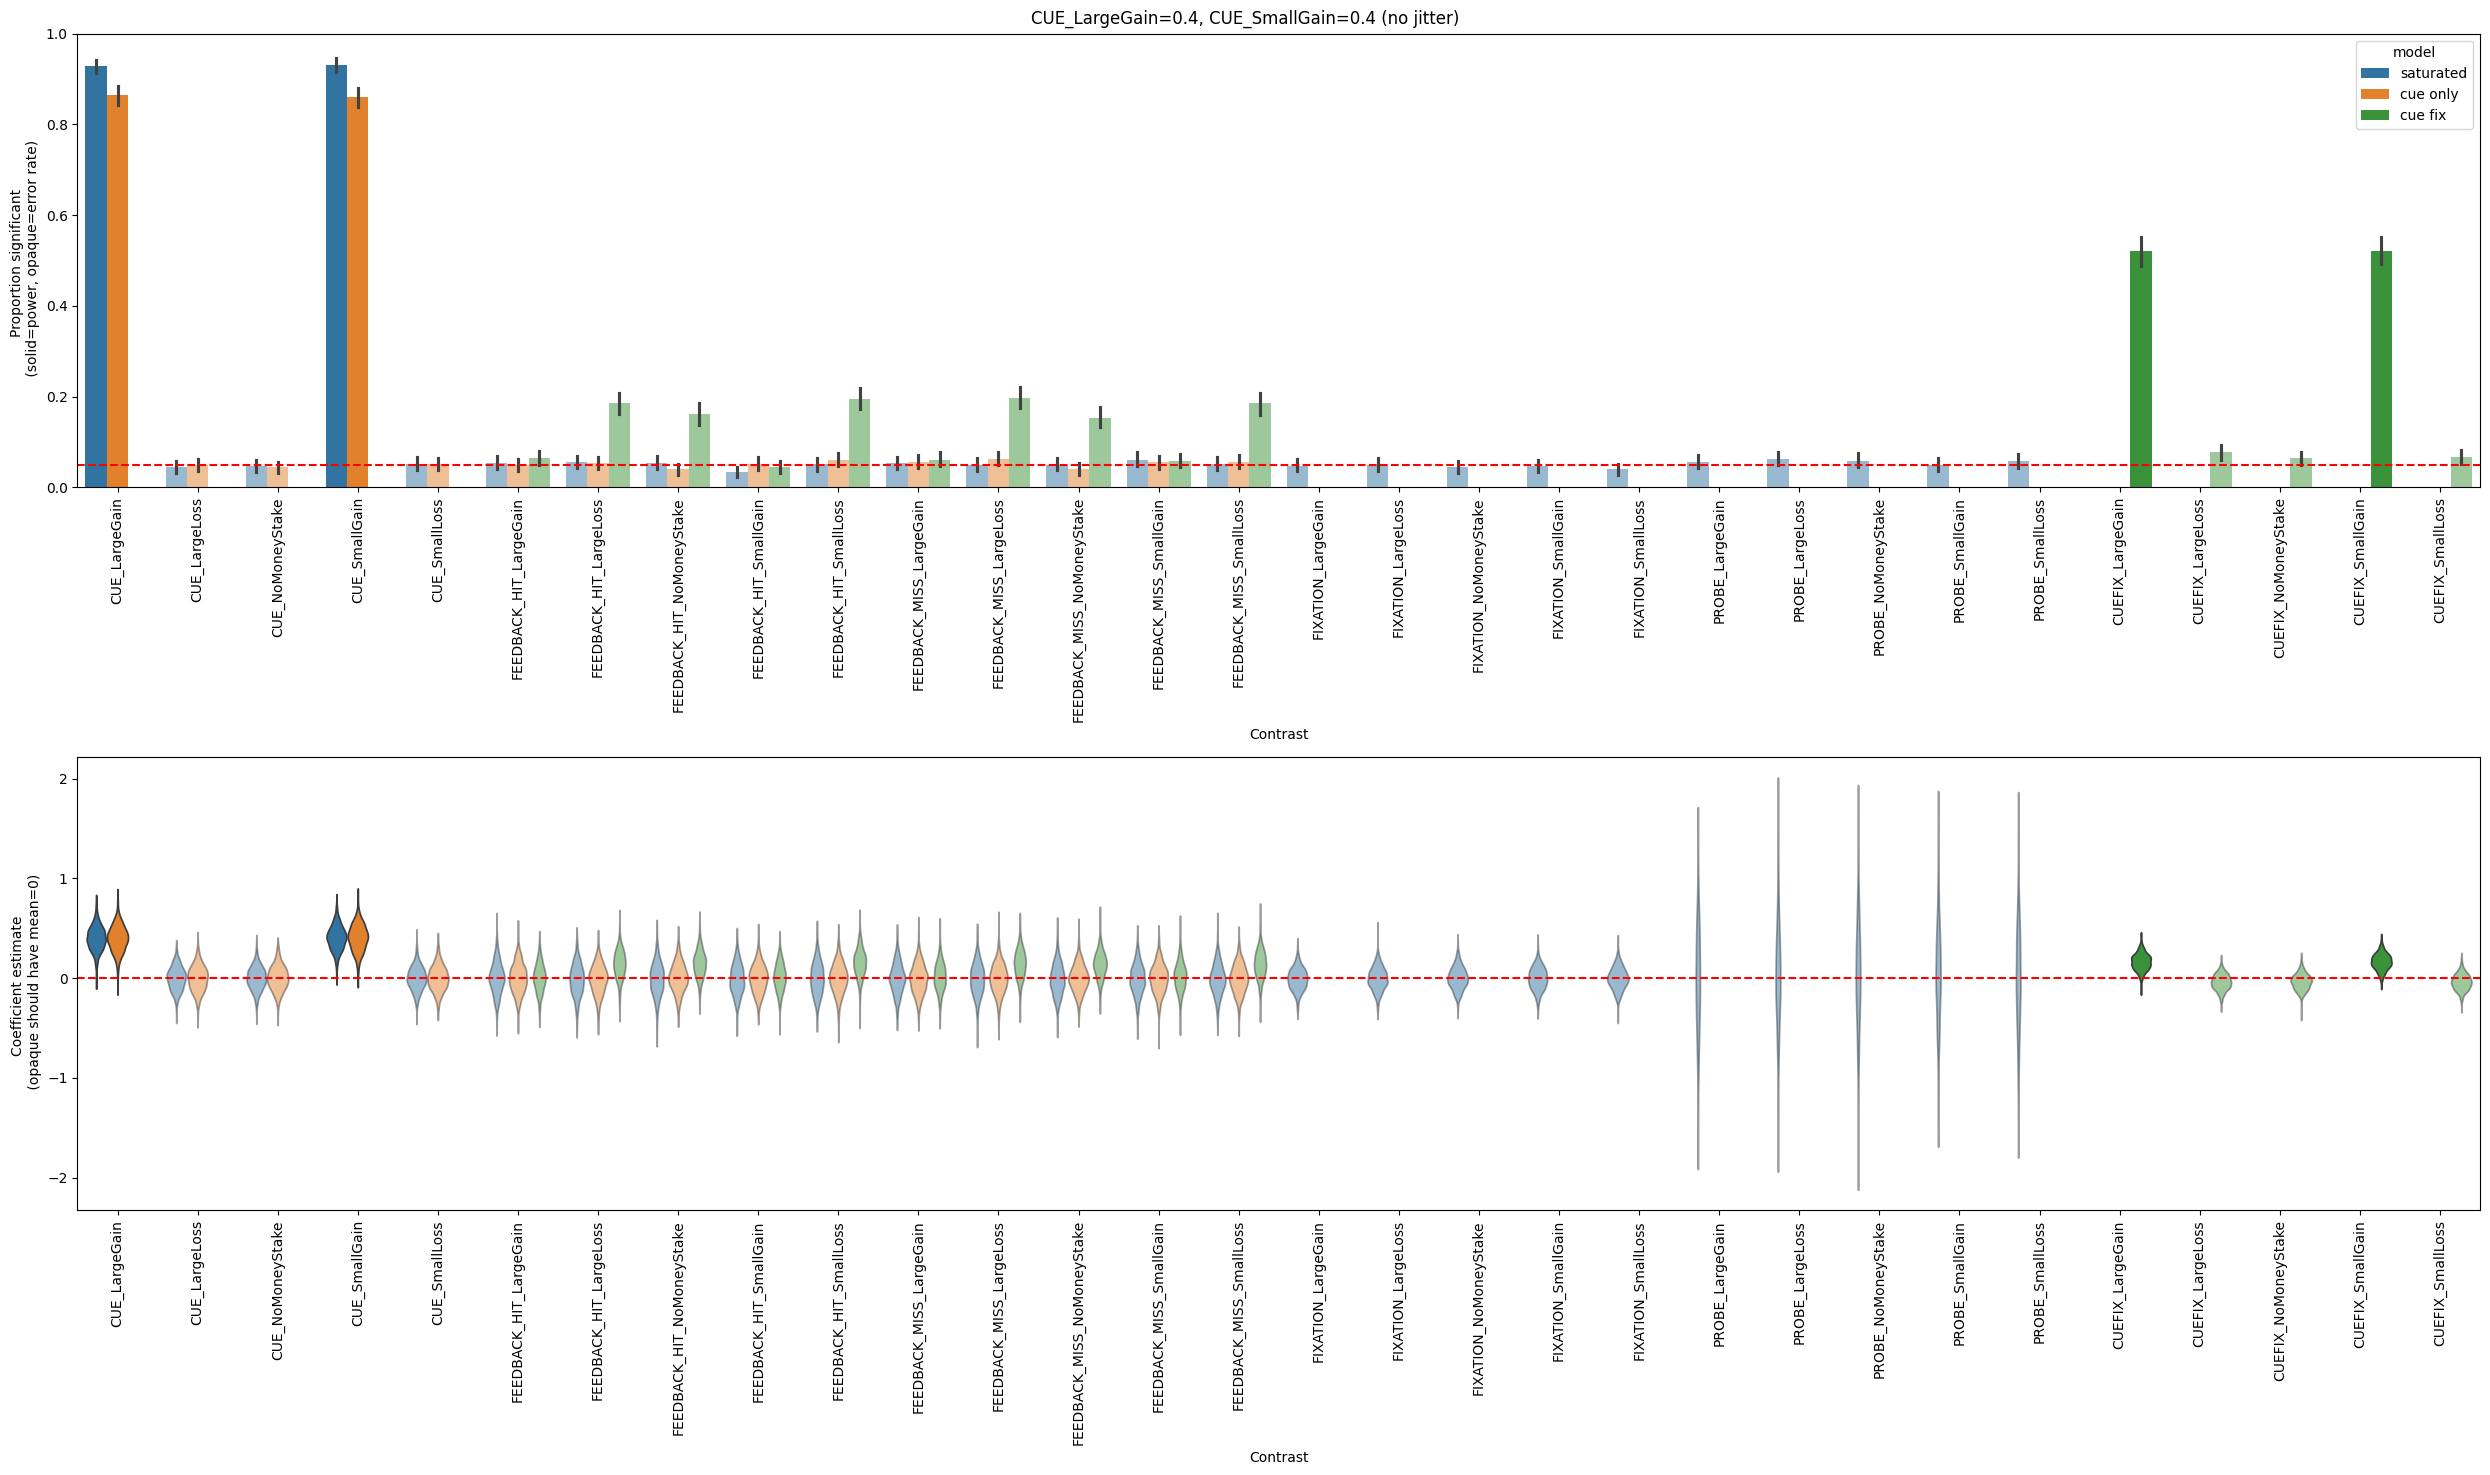

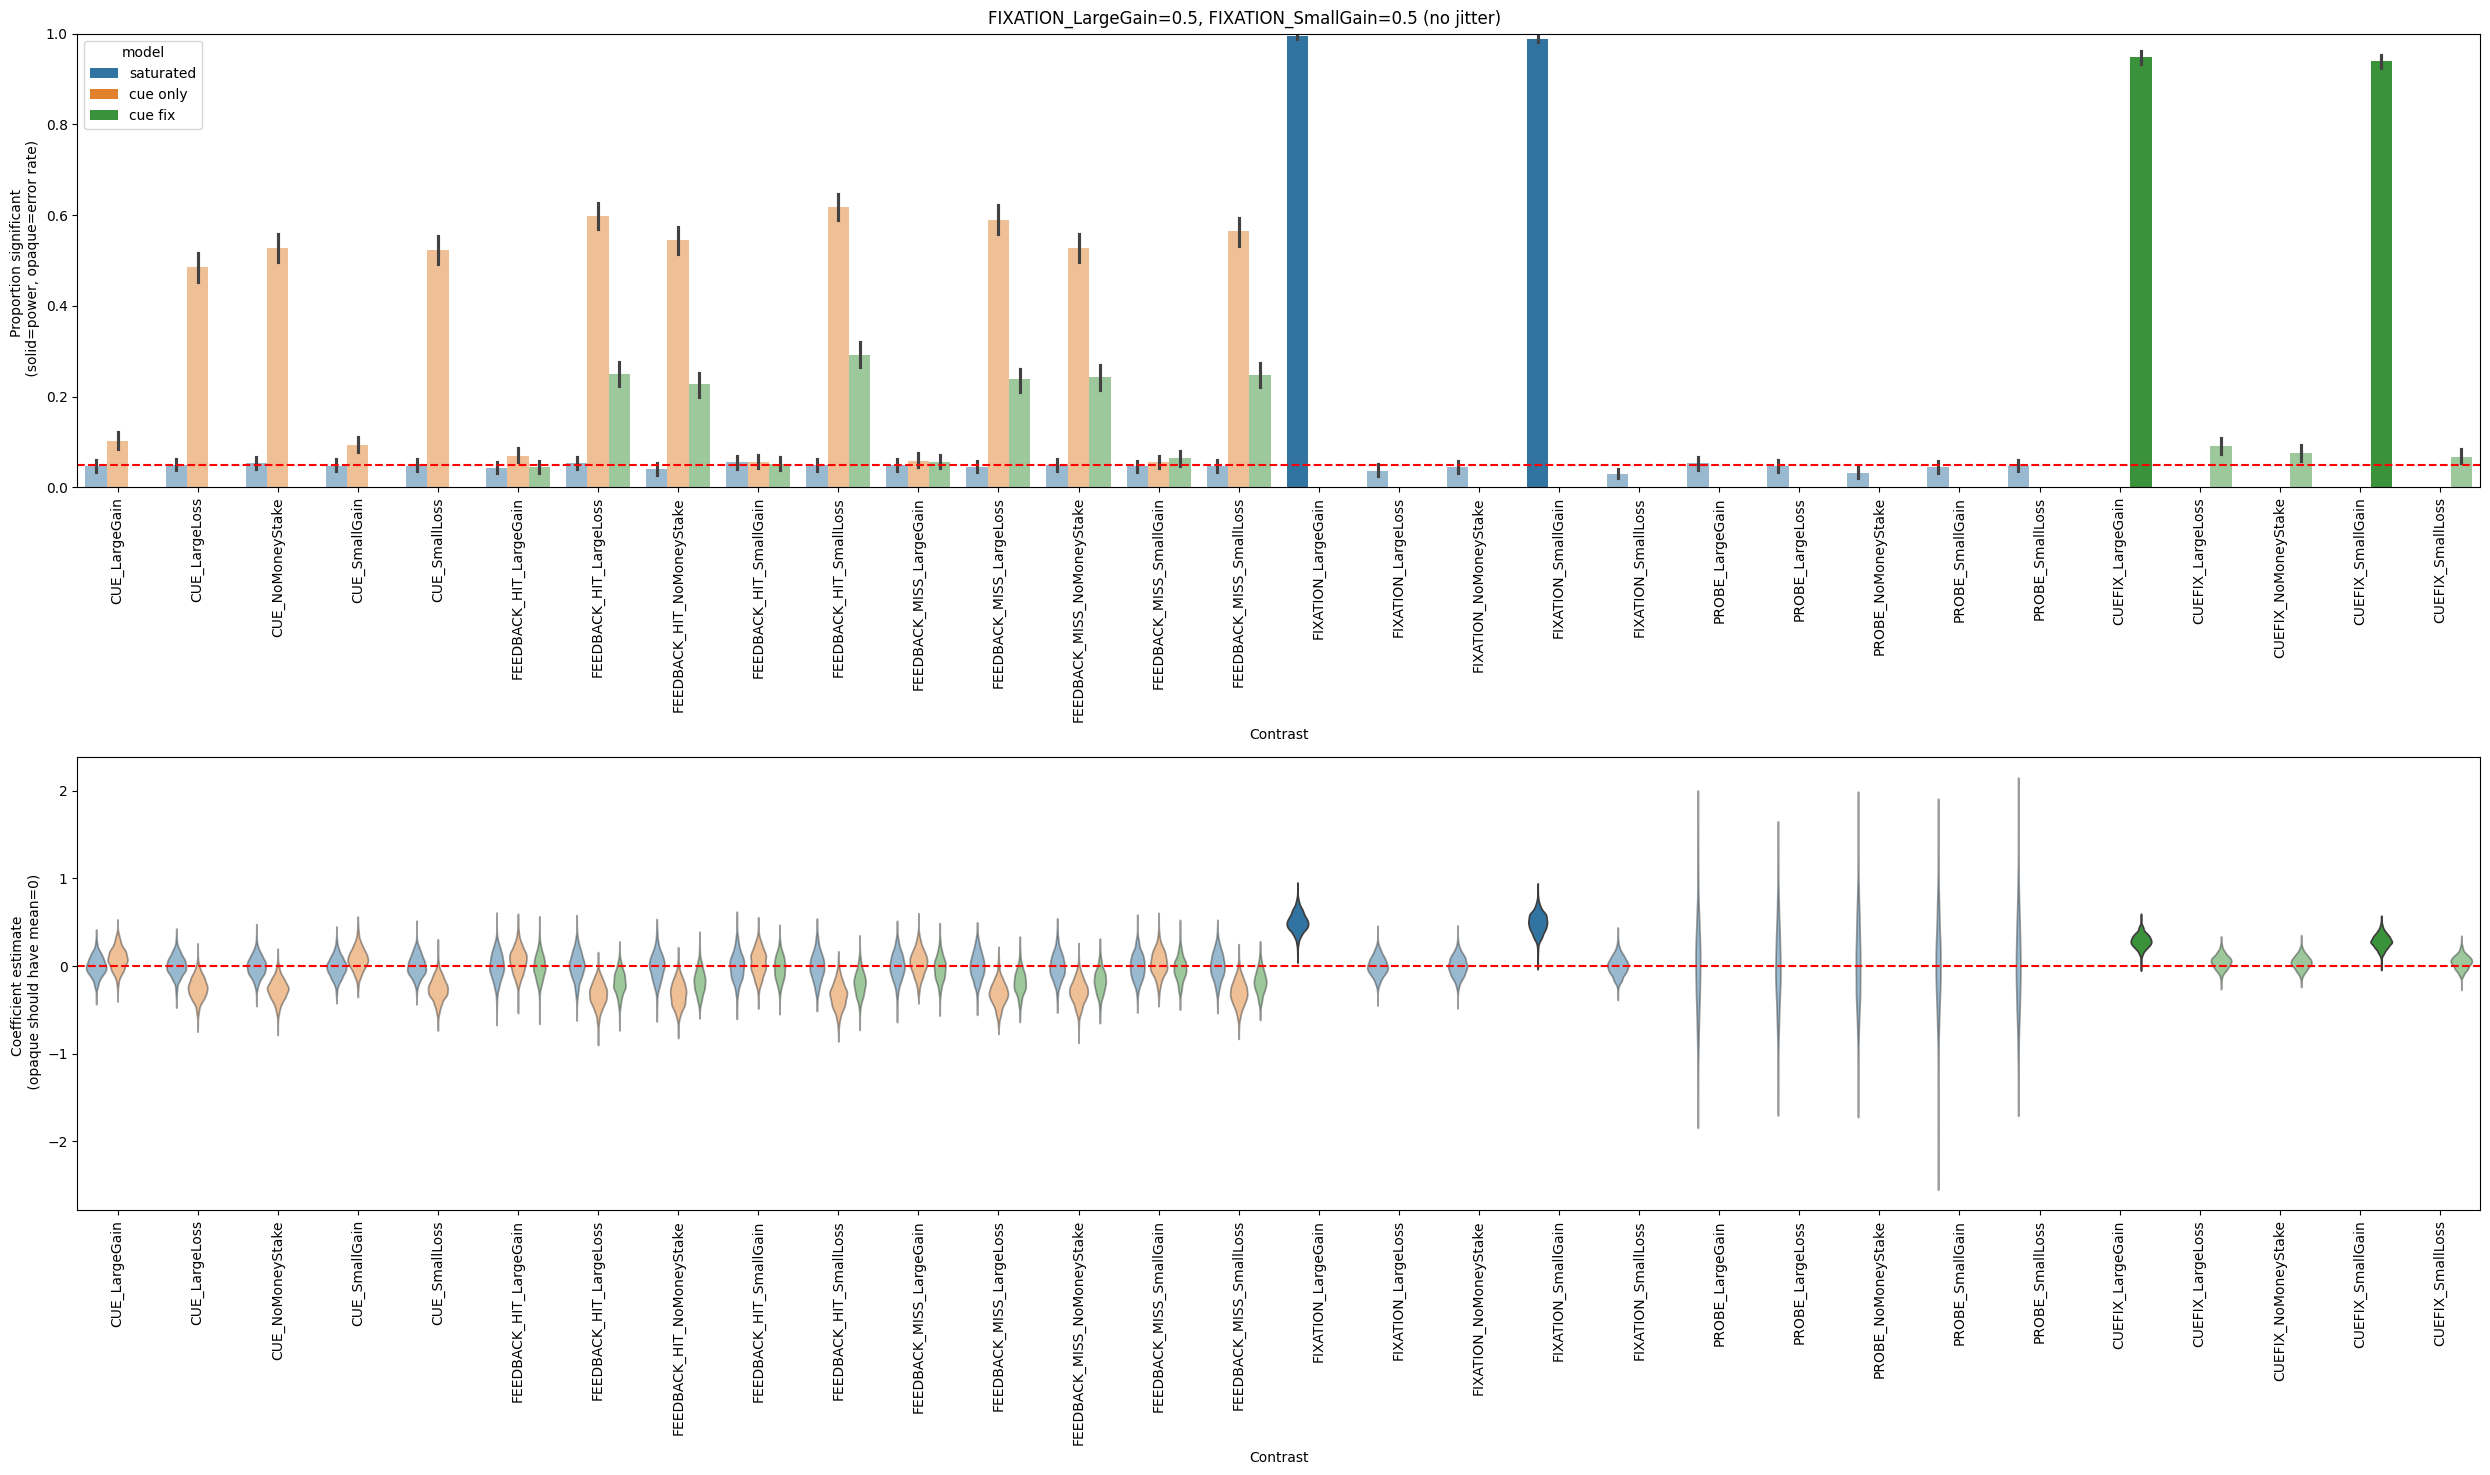

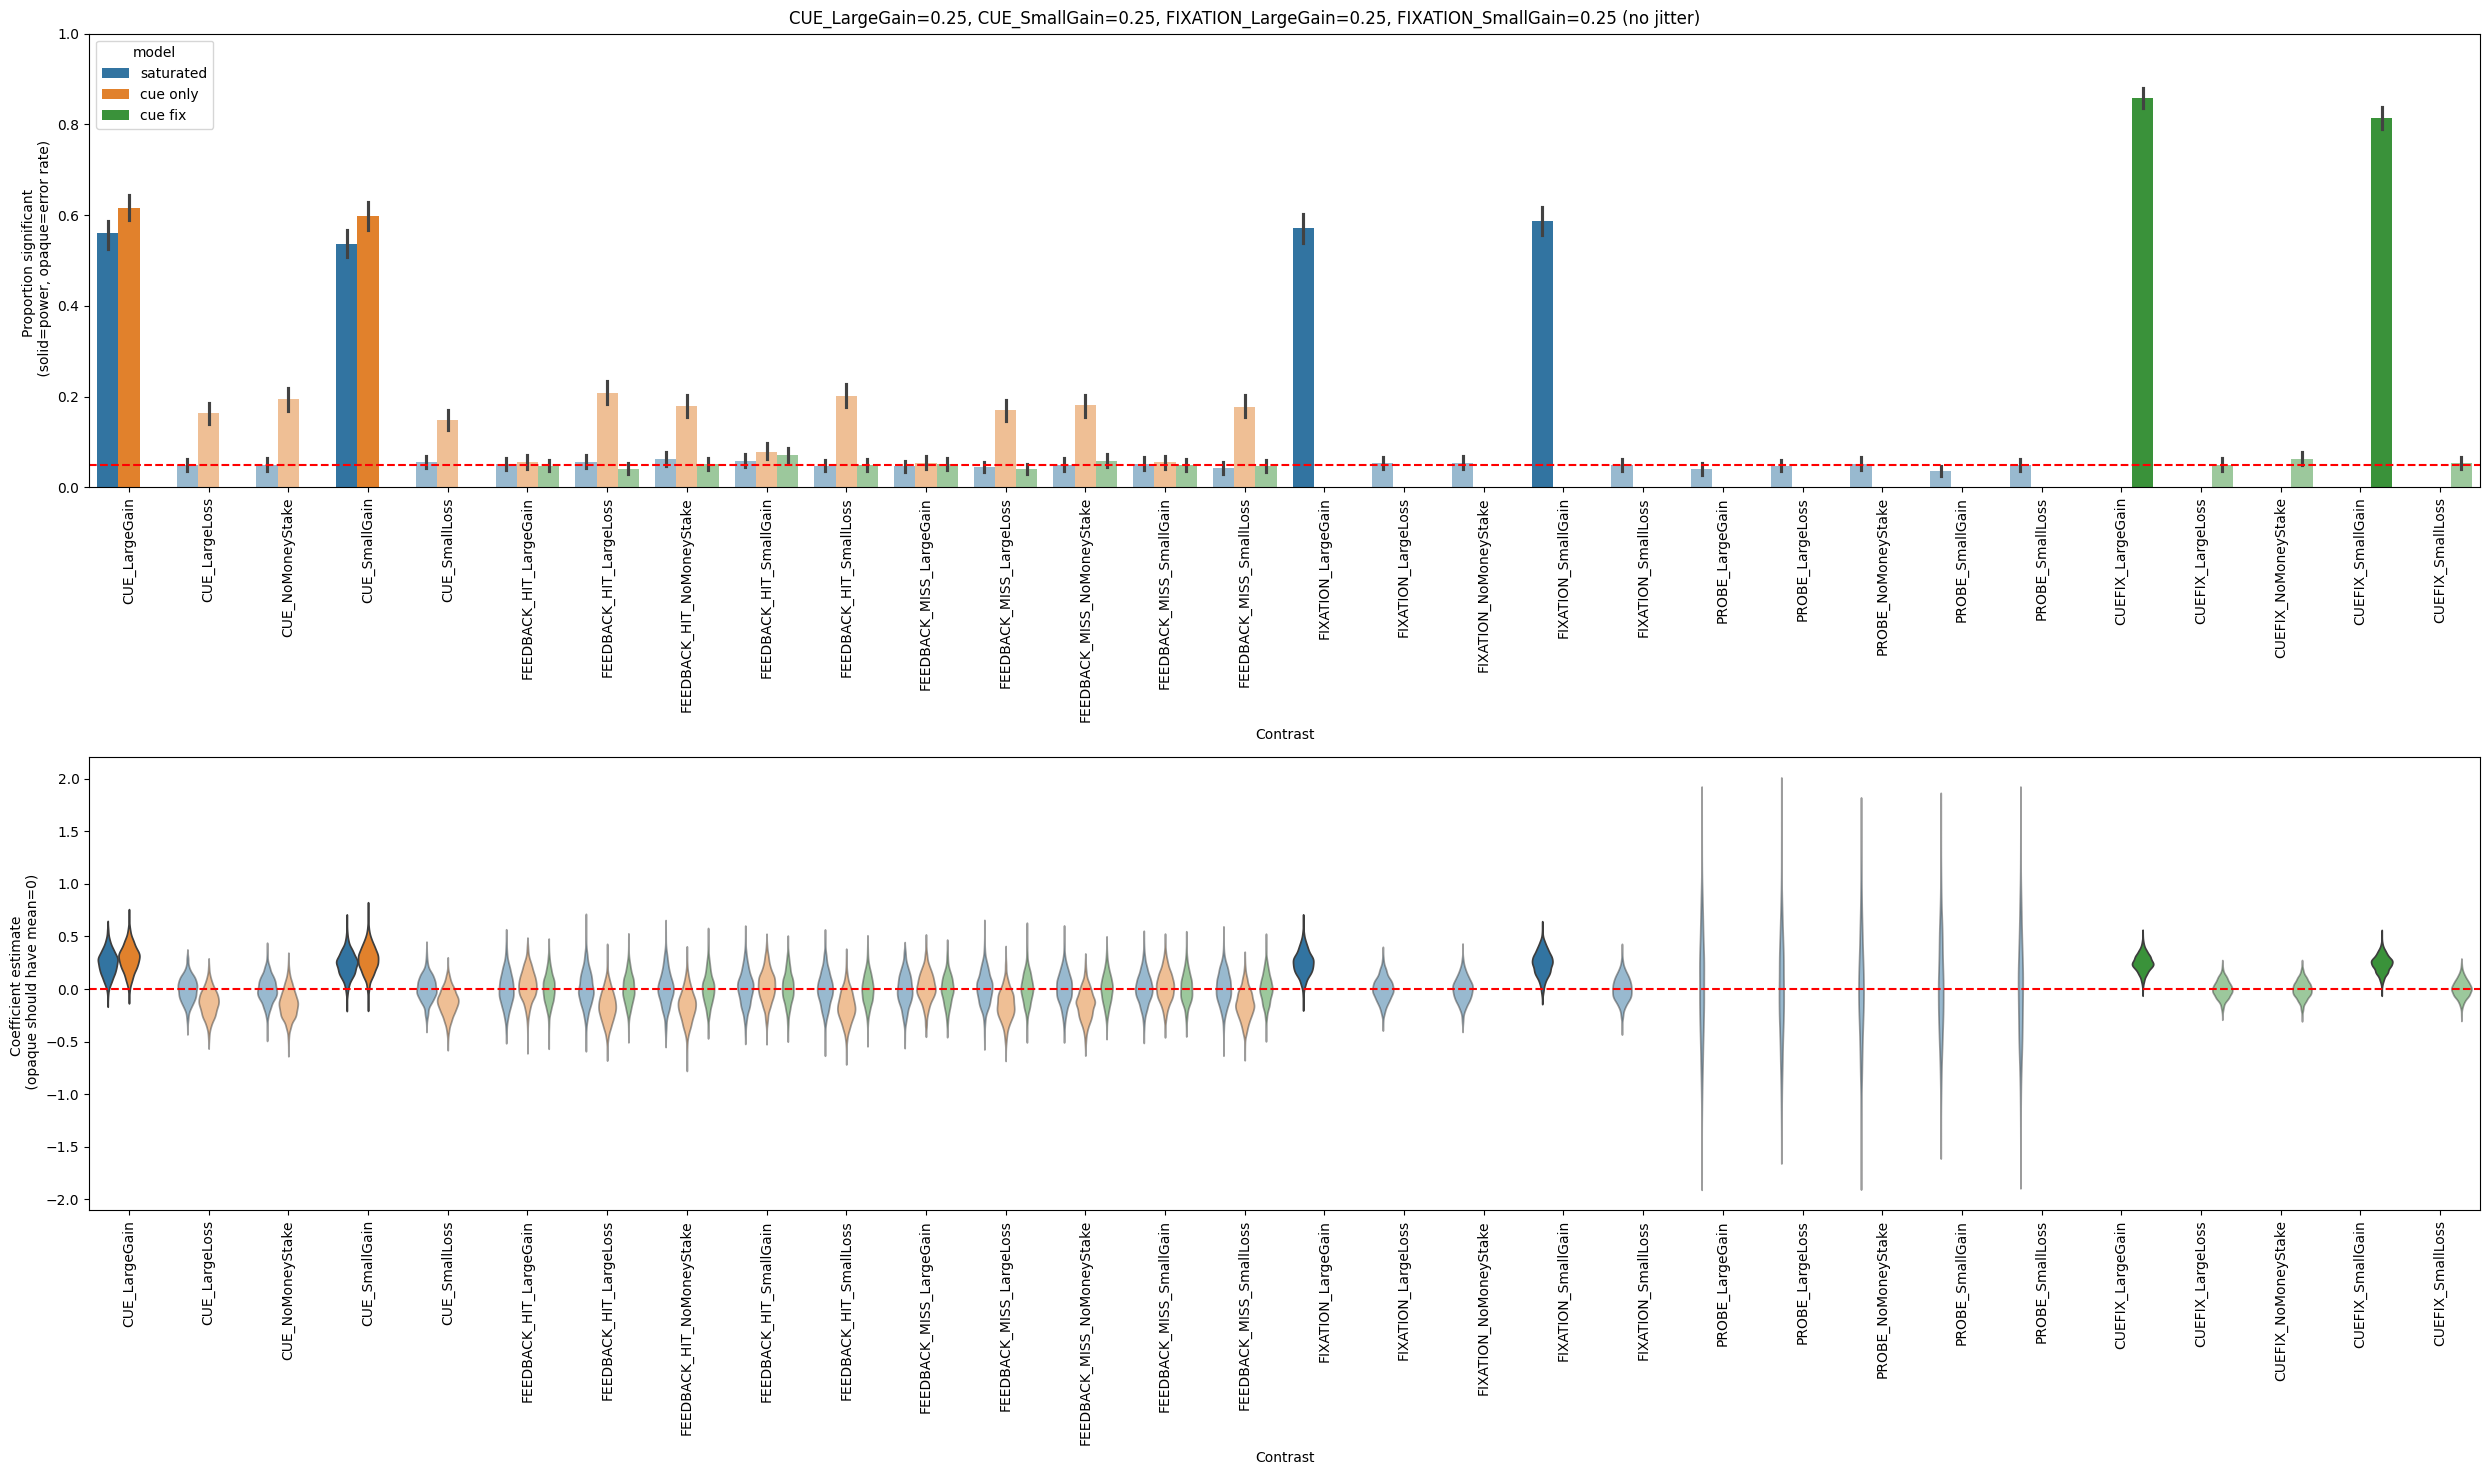

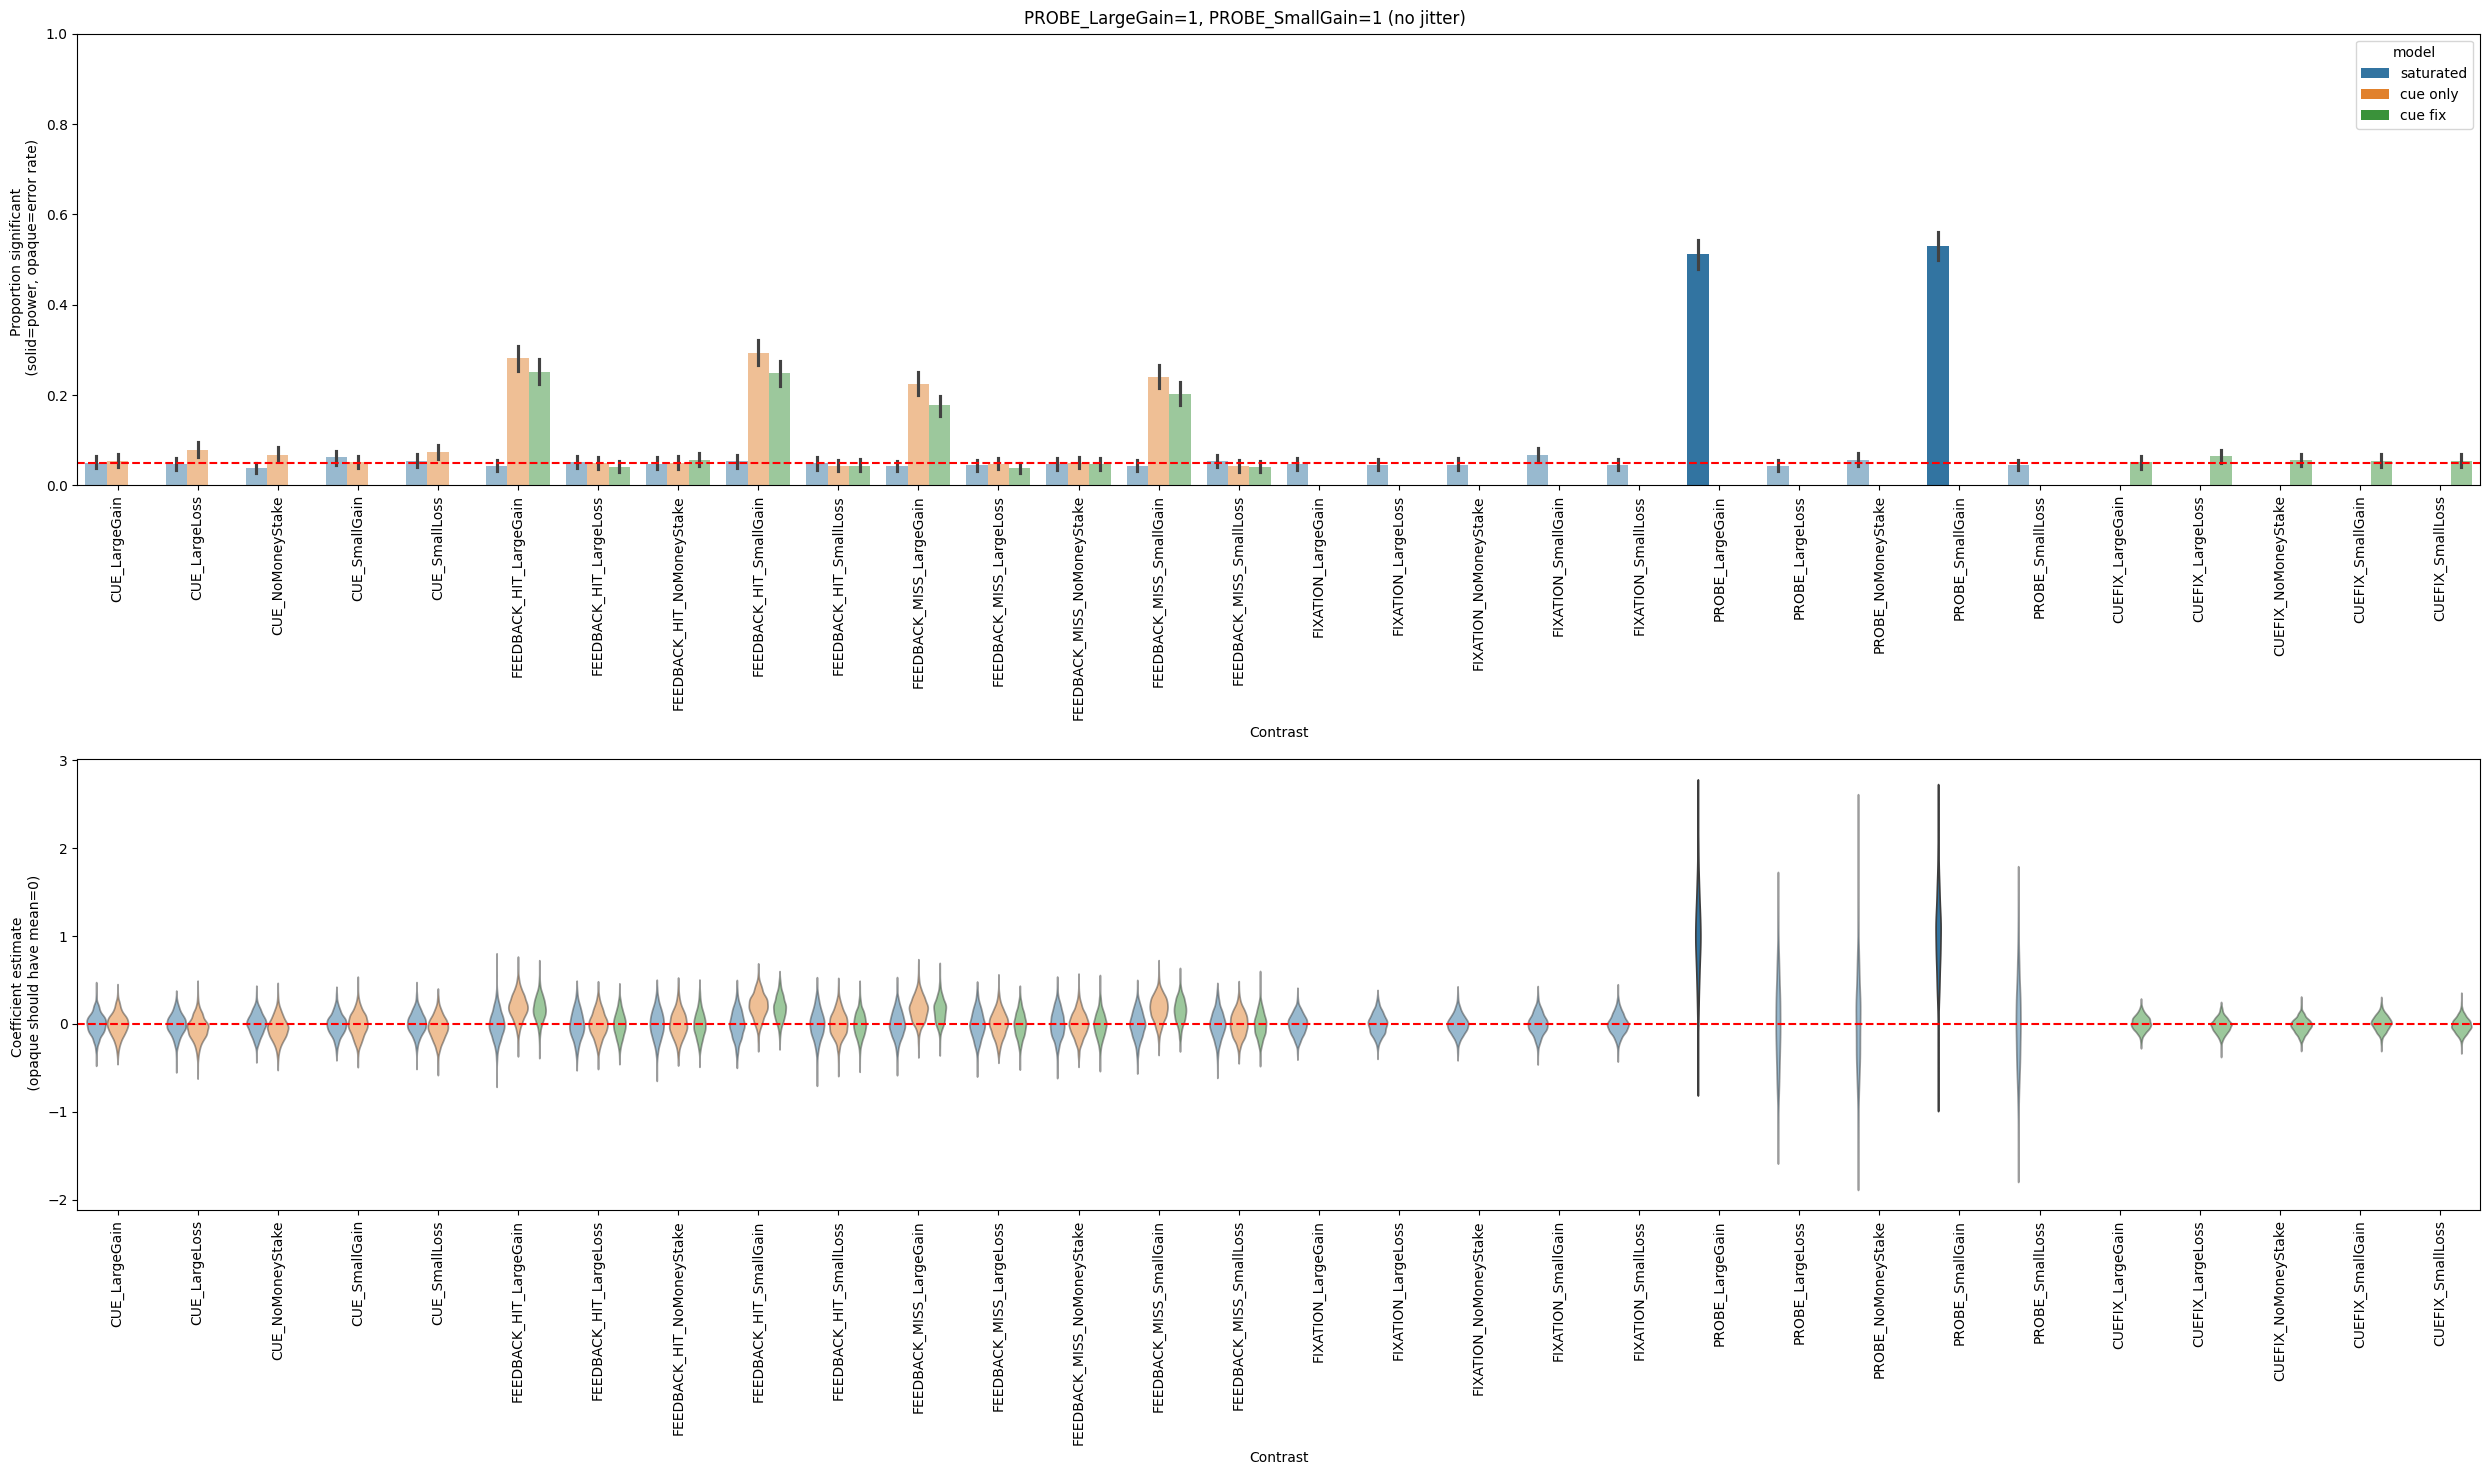

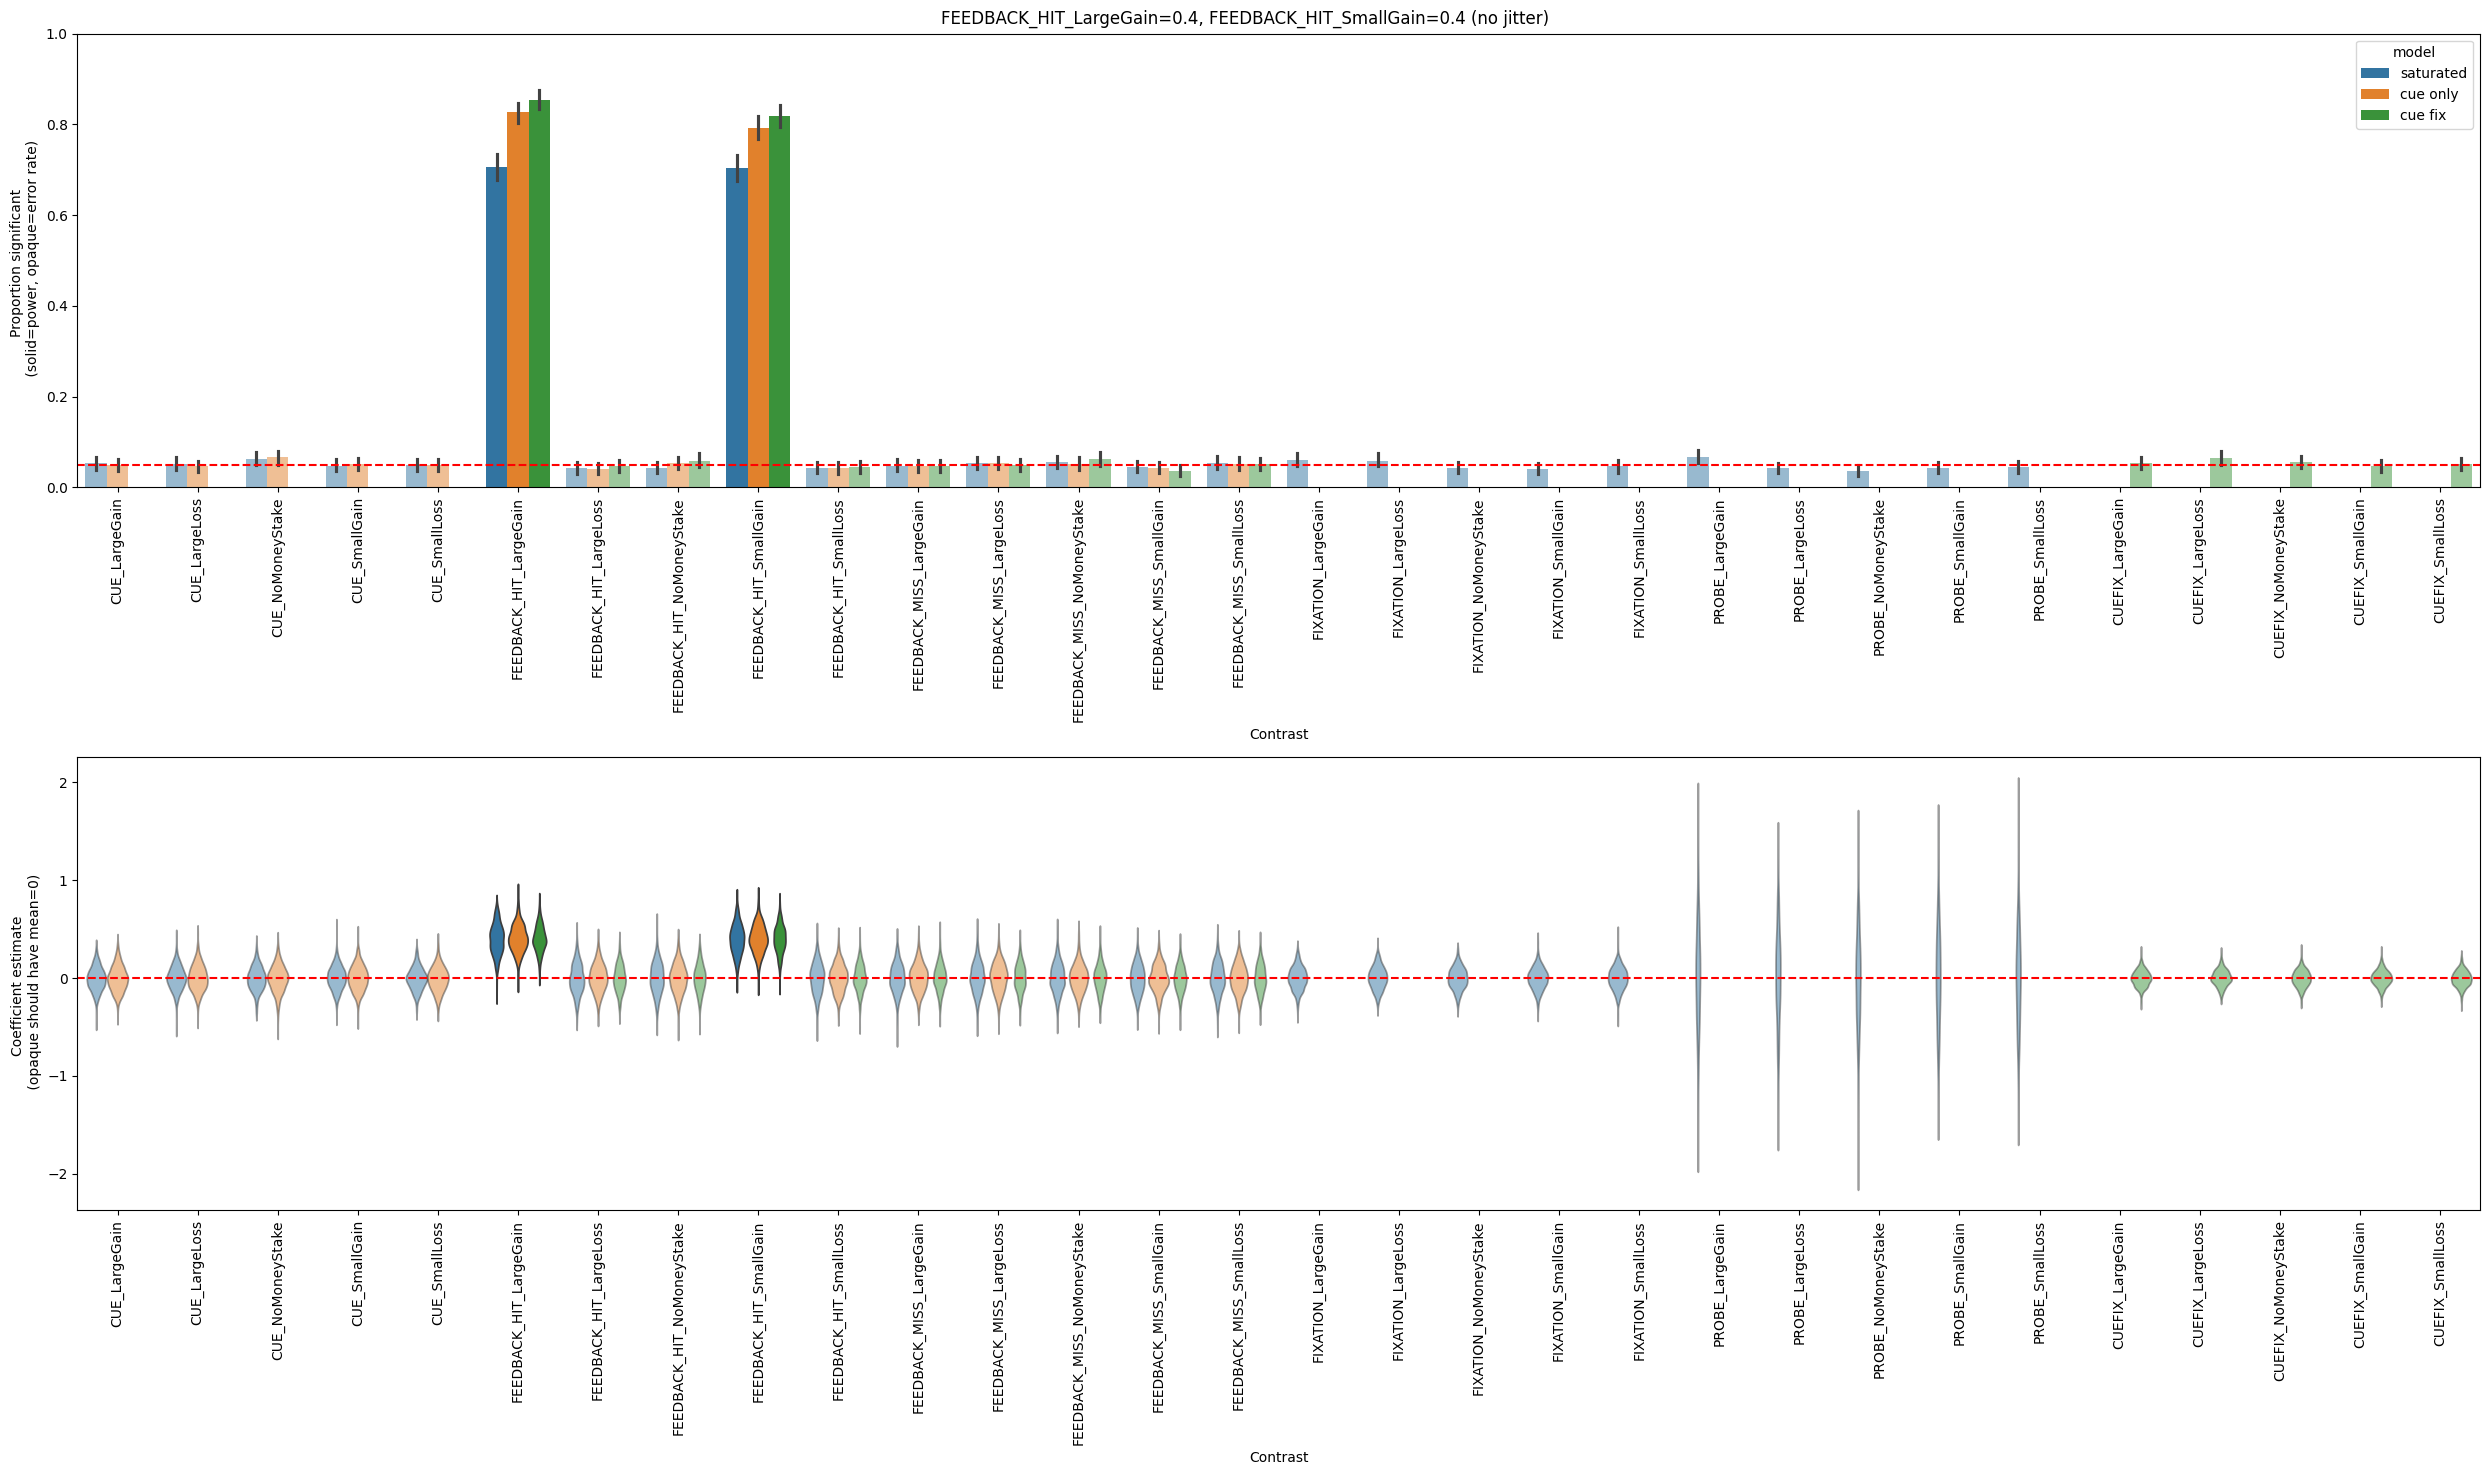

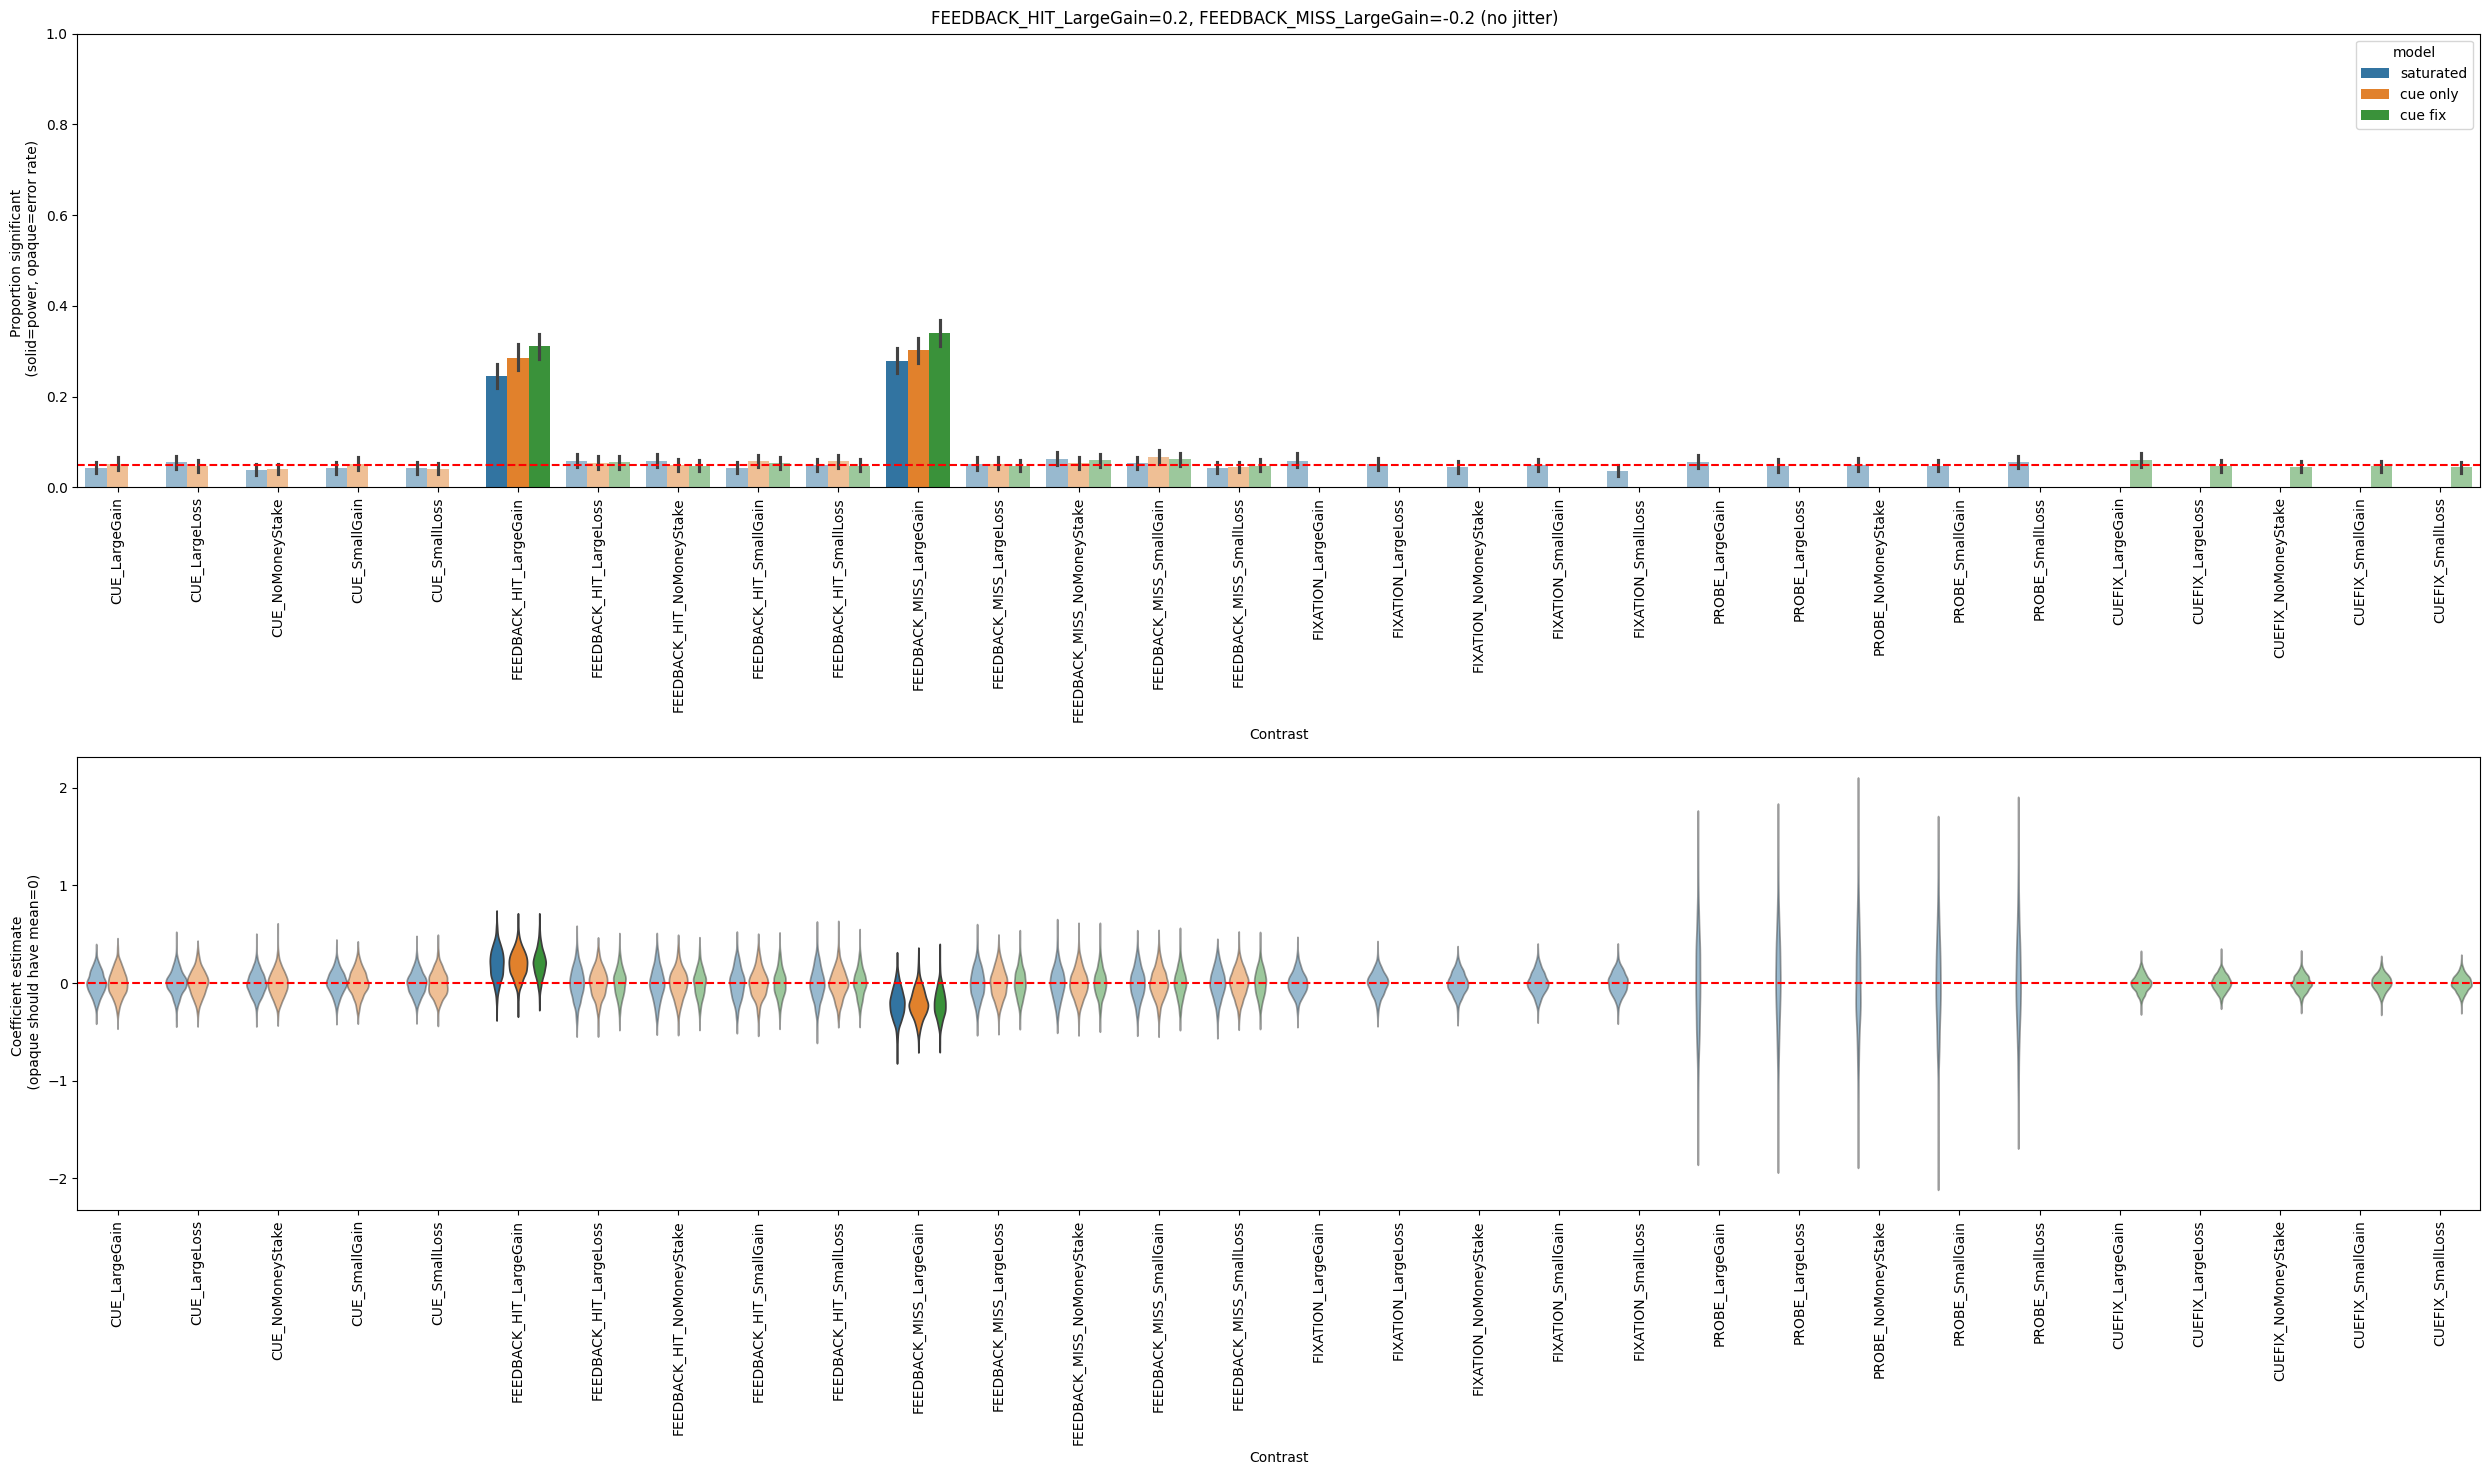

In [8]:
for name, result in results.items():
    plot_results(result[
        (result['contrast'].str.contains(":")==False)], 
        f'{name} (no jitter)', stacked=True)

## Repeat the above, but add a jittered ITI

These simulations add a jitter between 2-5s between the offset of the feedback of one trial and the onset of the cue in the following trial.  What is interesting is the biases for the contrasts are essentially the same, but the source of the bias is different, meaning different regressor parameters are causing the bias.  For example, FB:WHit - NeutHit has a negative bias with and without the jitter (when cue small/large gain betas are .4), but the source is a positive bias on NeutHit feedback when there is not any jitter, but a negative bias for the gain feedback parameters when there is jitter.  Similar patterns show up for other contrasts in other nonzero parameter settings.

In [9]:
results_jitter = {}

for beta_dict in beta_dicts:
    print(beta_dict)
    figure_label = make_analysis_label(beta_dict)
    results_jitter[figure_label], _, desmat_example_jitter = sim_group_models_parallel(beta_dict, noise_sd, 
                                                                beta_sub_sd, nsims=nsims, conv_resolution=.2, tr=1,
                                                                jitter=True, jitter_iti_min=2, jitter_iti_max=5)

{}
Error loading sub 5
bad parsing
{'CUE_LargeGain': 0.4, 'CUE_SmallGain': 0.4}
Error loading sub 5
bad parsing
{'FIXATION_LargeGain': 0.5, 'FIXATION_SmallGain': 0.5}
Error loading sub 5
bad parsing
{'CUE_LargeGain': 0.25, 'CUE_SmallGain': 0.25, 'FIXATION_LargeGain': 0.25, 'FIXATION_SmallGain': 0.25}
Error loading sub 5
bad parsing
{'PROBE_LargeGain': 1, 'PROBE_SmallGain': 1}
Error loading sub 5
bad parsing
{'FEEDBACK_HIT_LargeGain': 0.4, 'FEEDBACK_HIT_SmallGain': 0.4}
Error loading sub 5
bad parsing
{'FEEDBACK_HIT_LargeGain': 0.2, 'FEEDBACK_MISS_LargeGain': -0.2}
Error loading sub 5
bad parsing


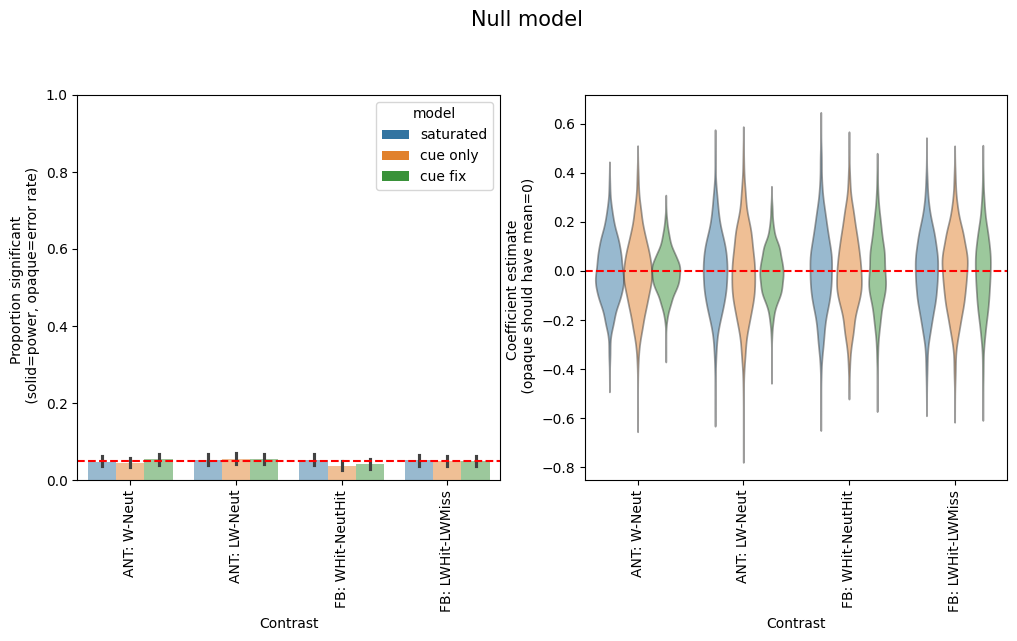

In [10]:
plot_dict_of_results({'Null model': results_jitter['Null model']}, contrasts=True)

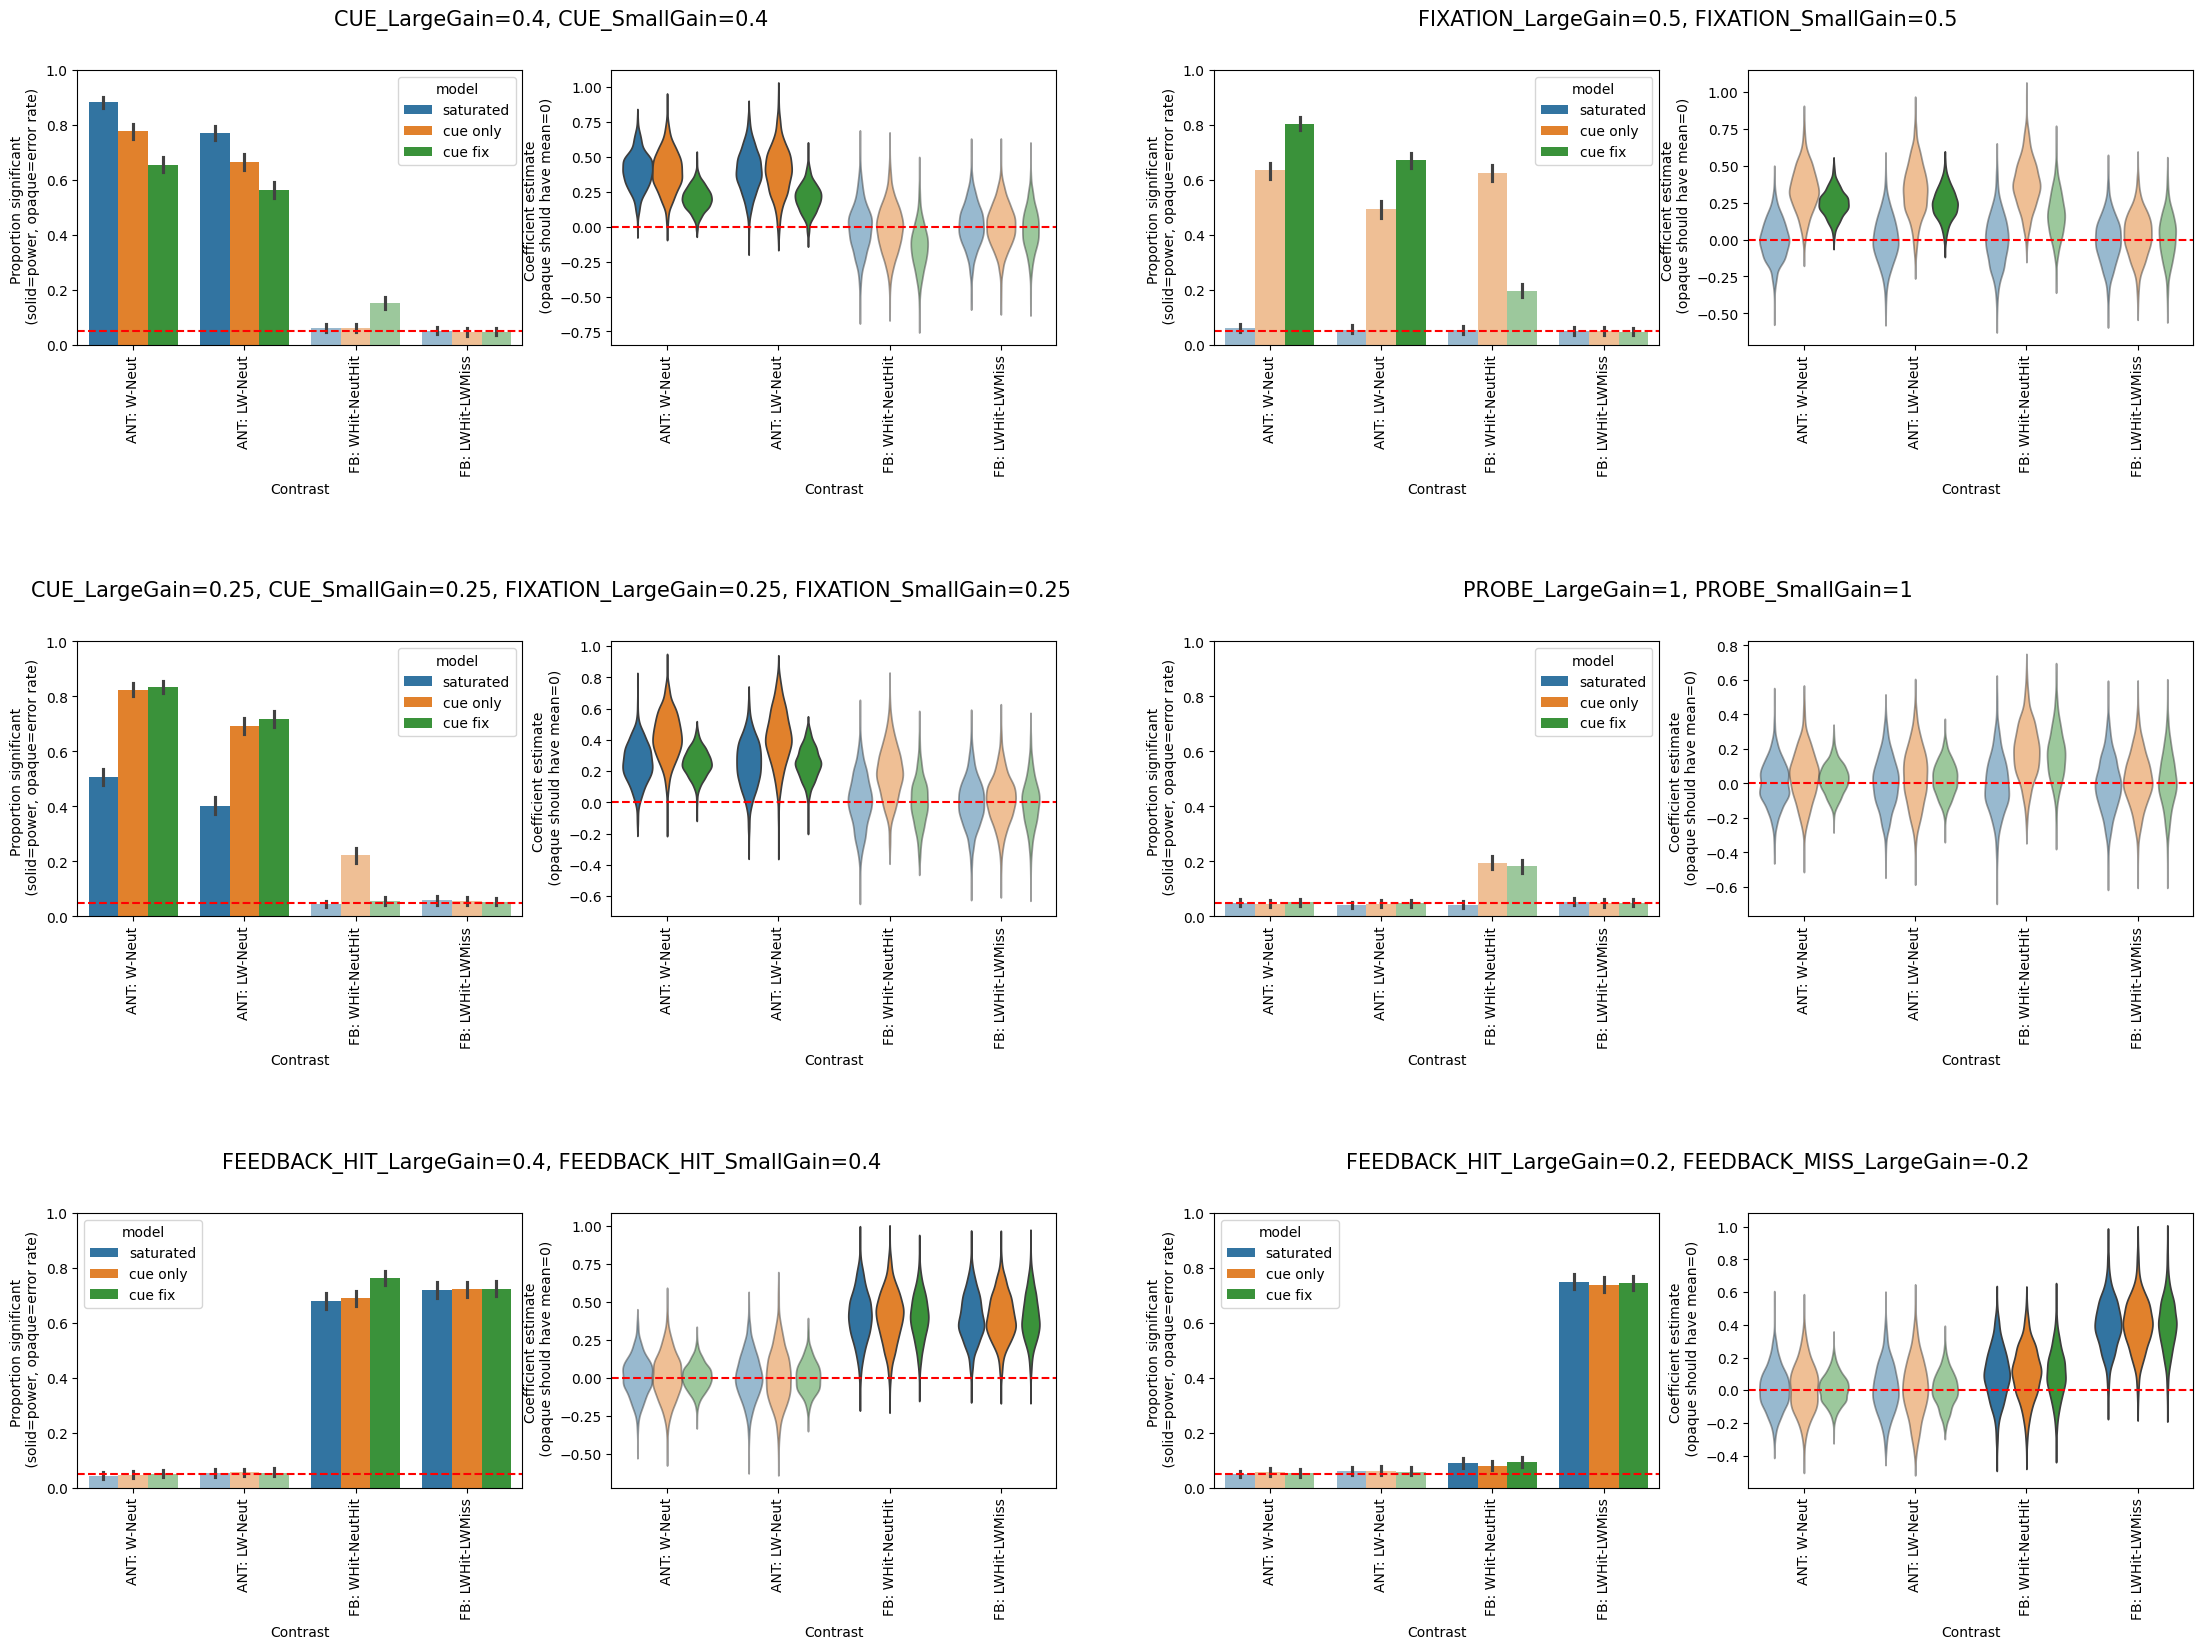

In [11]:
results_jitter_plot = results_jitter.copy()
results_jitter_plot.pop('Null model')
plot_dict_of_results(results_jitter_plot, contrasts=True)

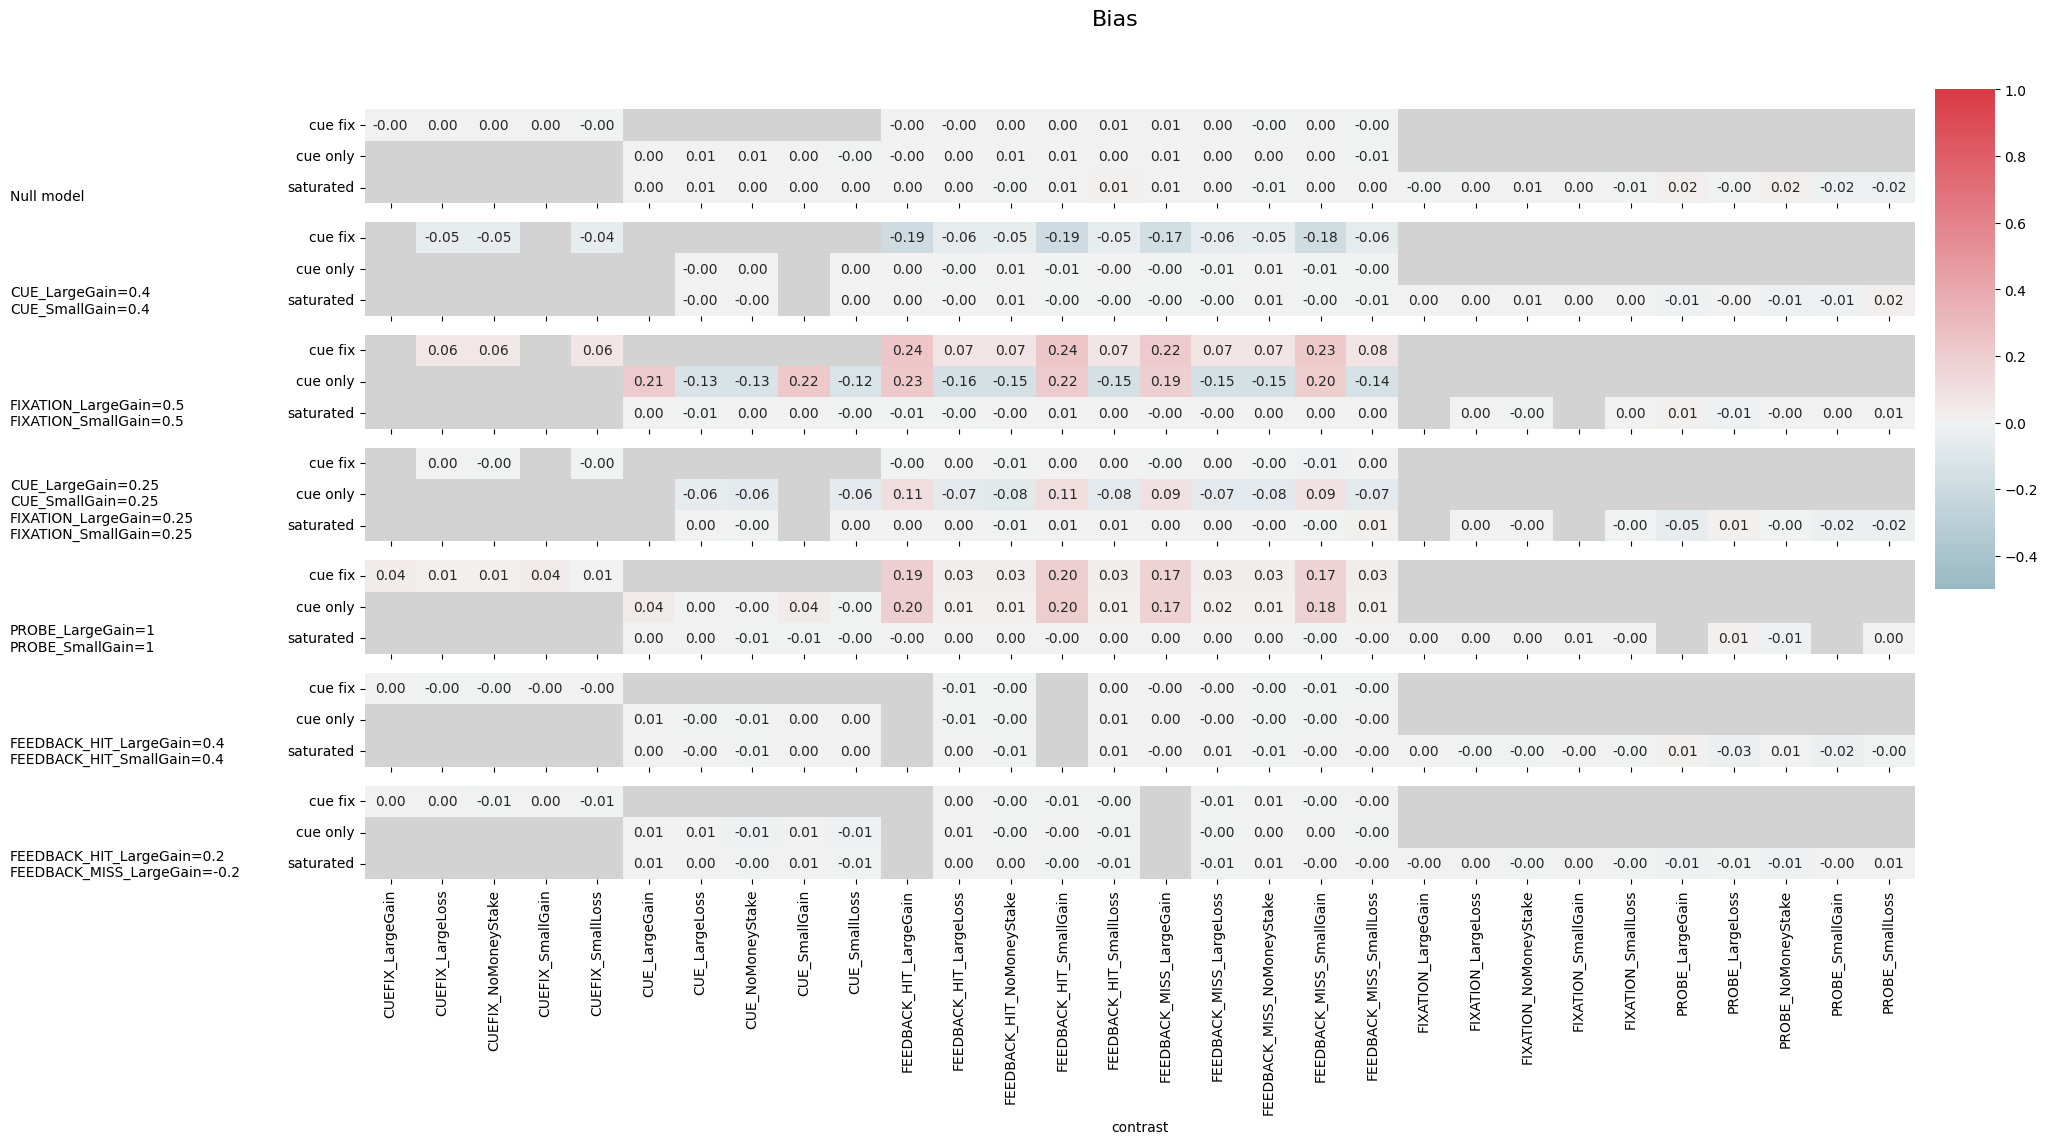

In [12]:
plot_bias(results_jitter)

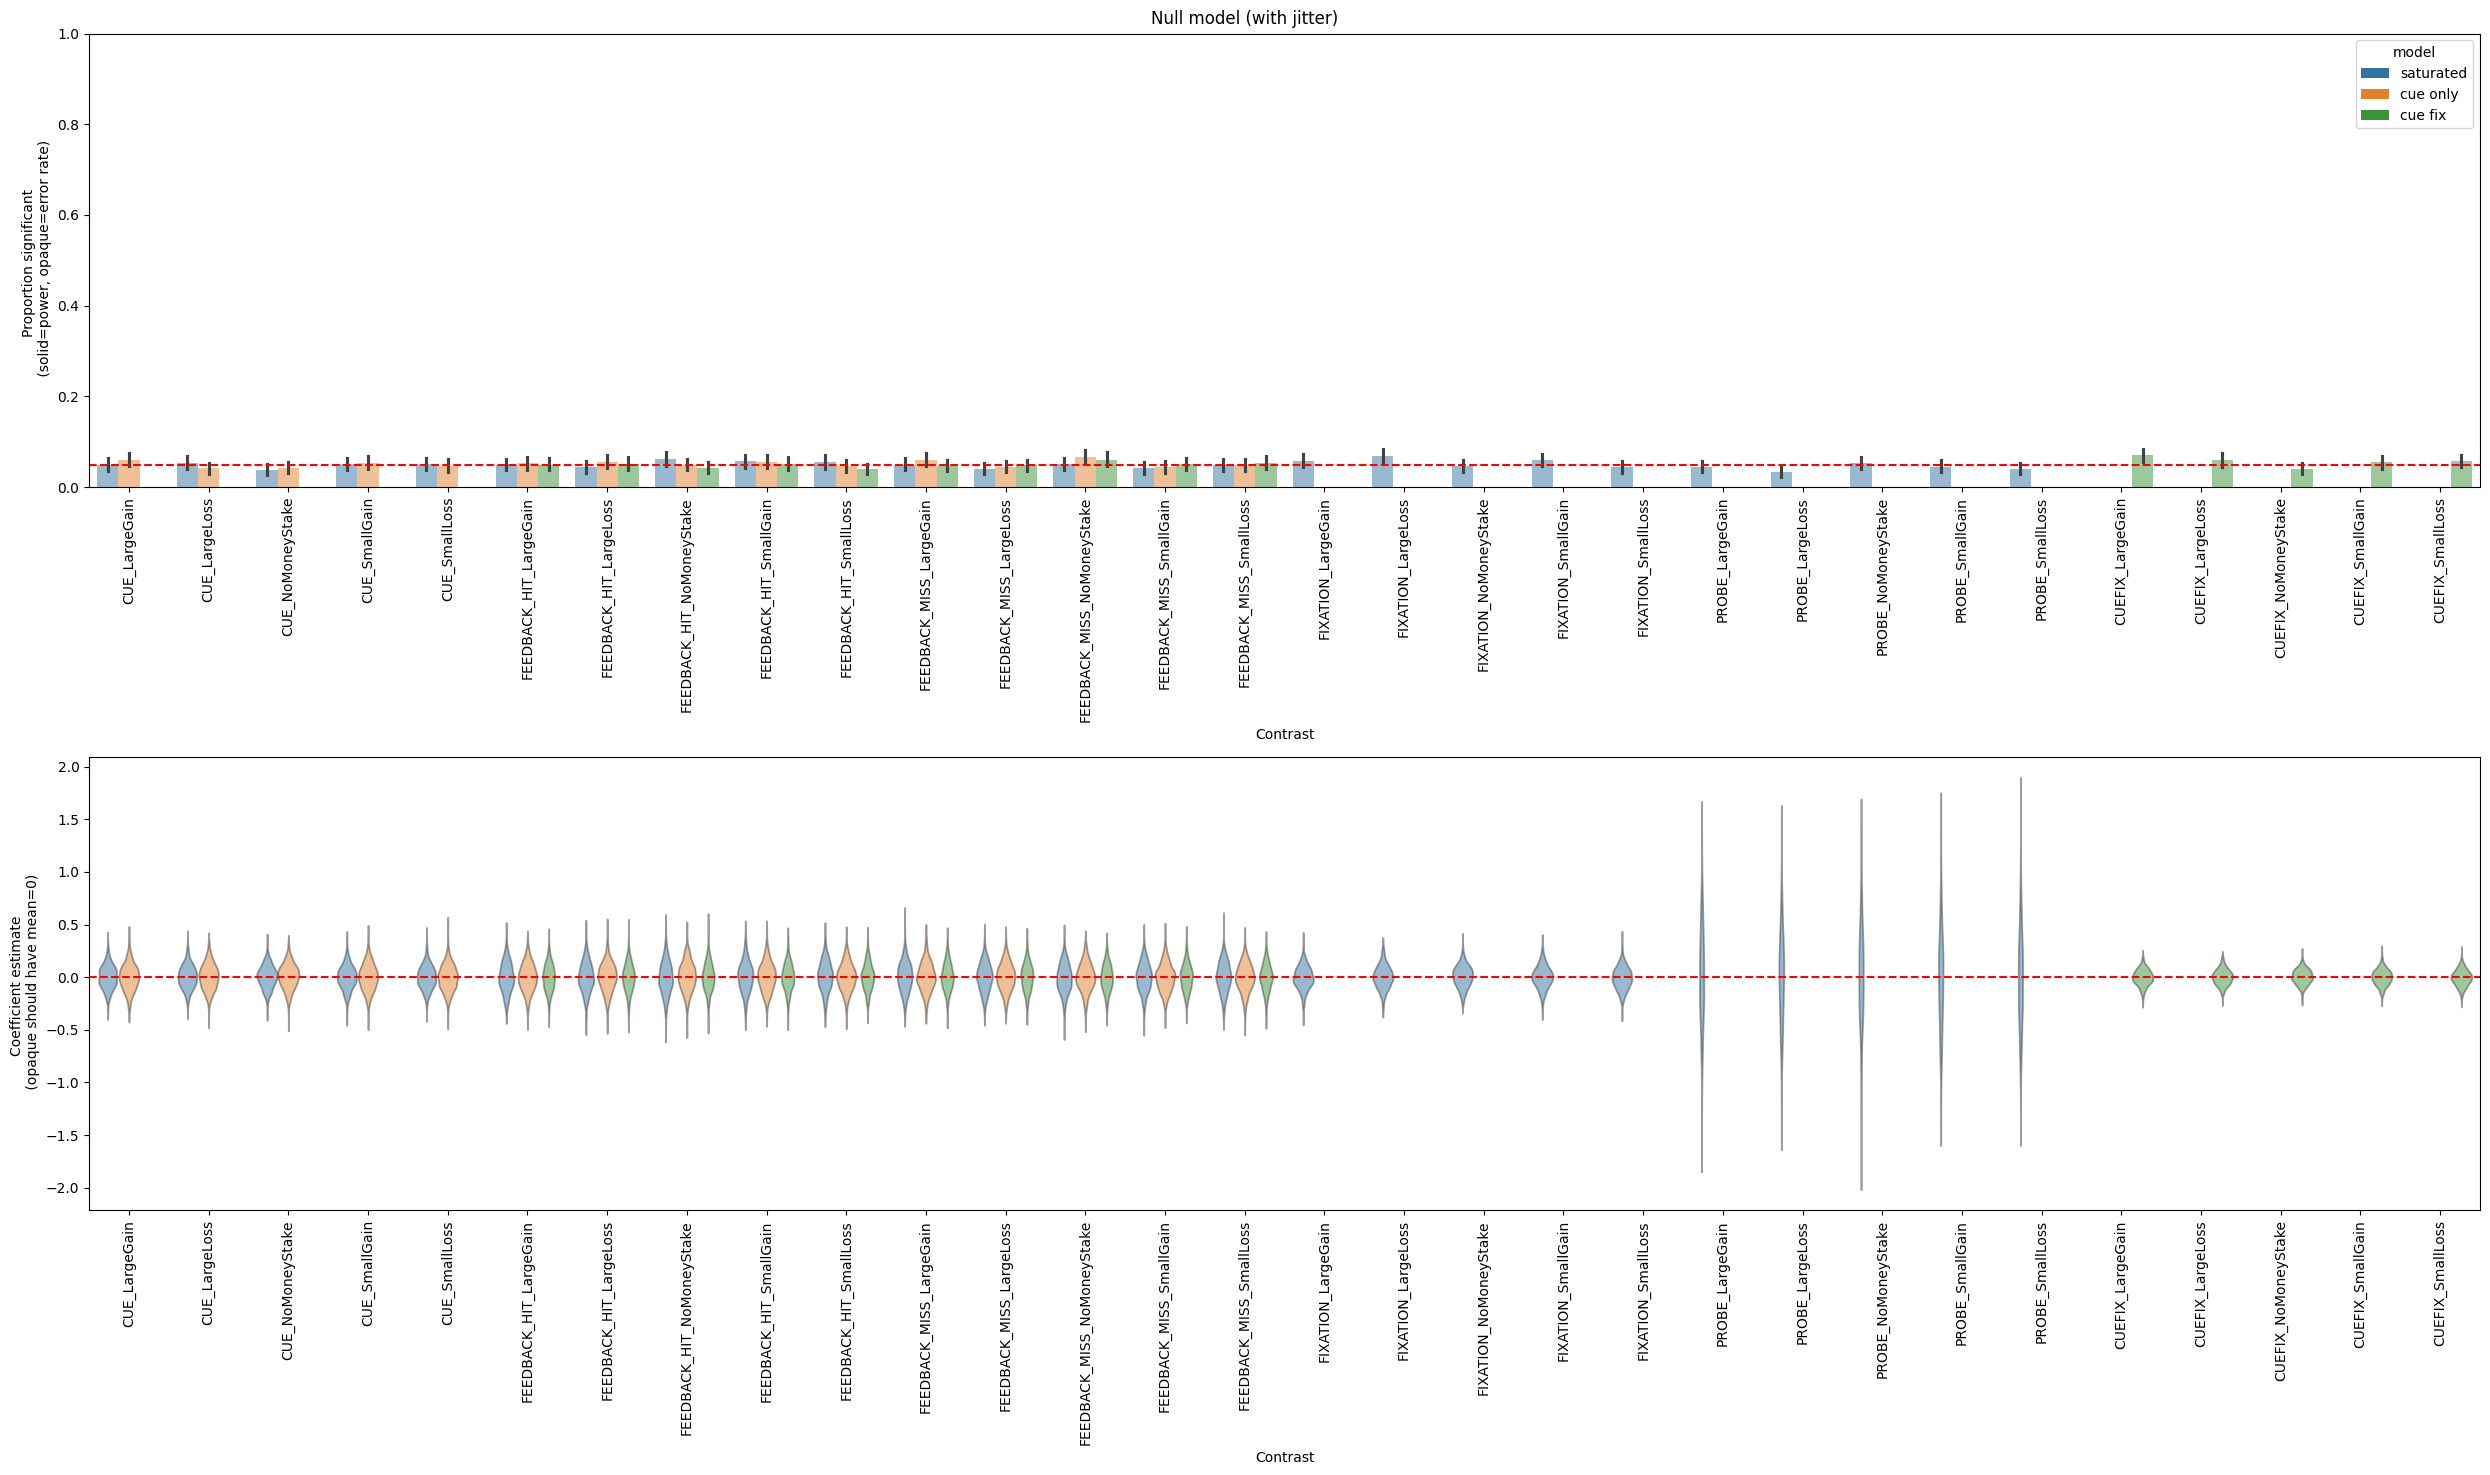

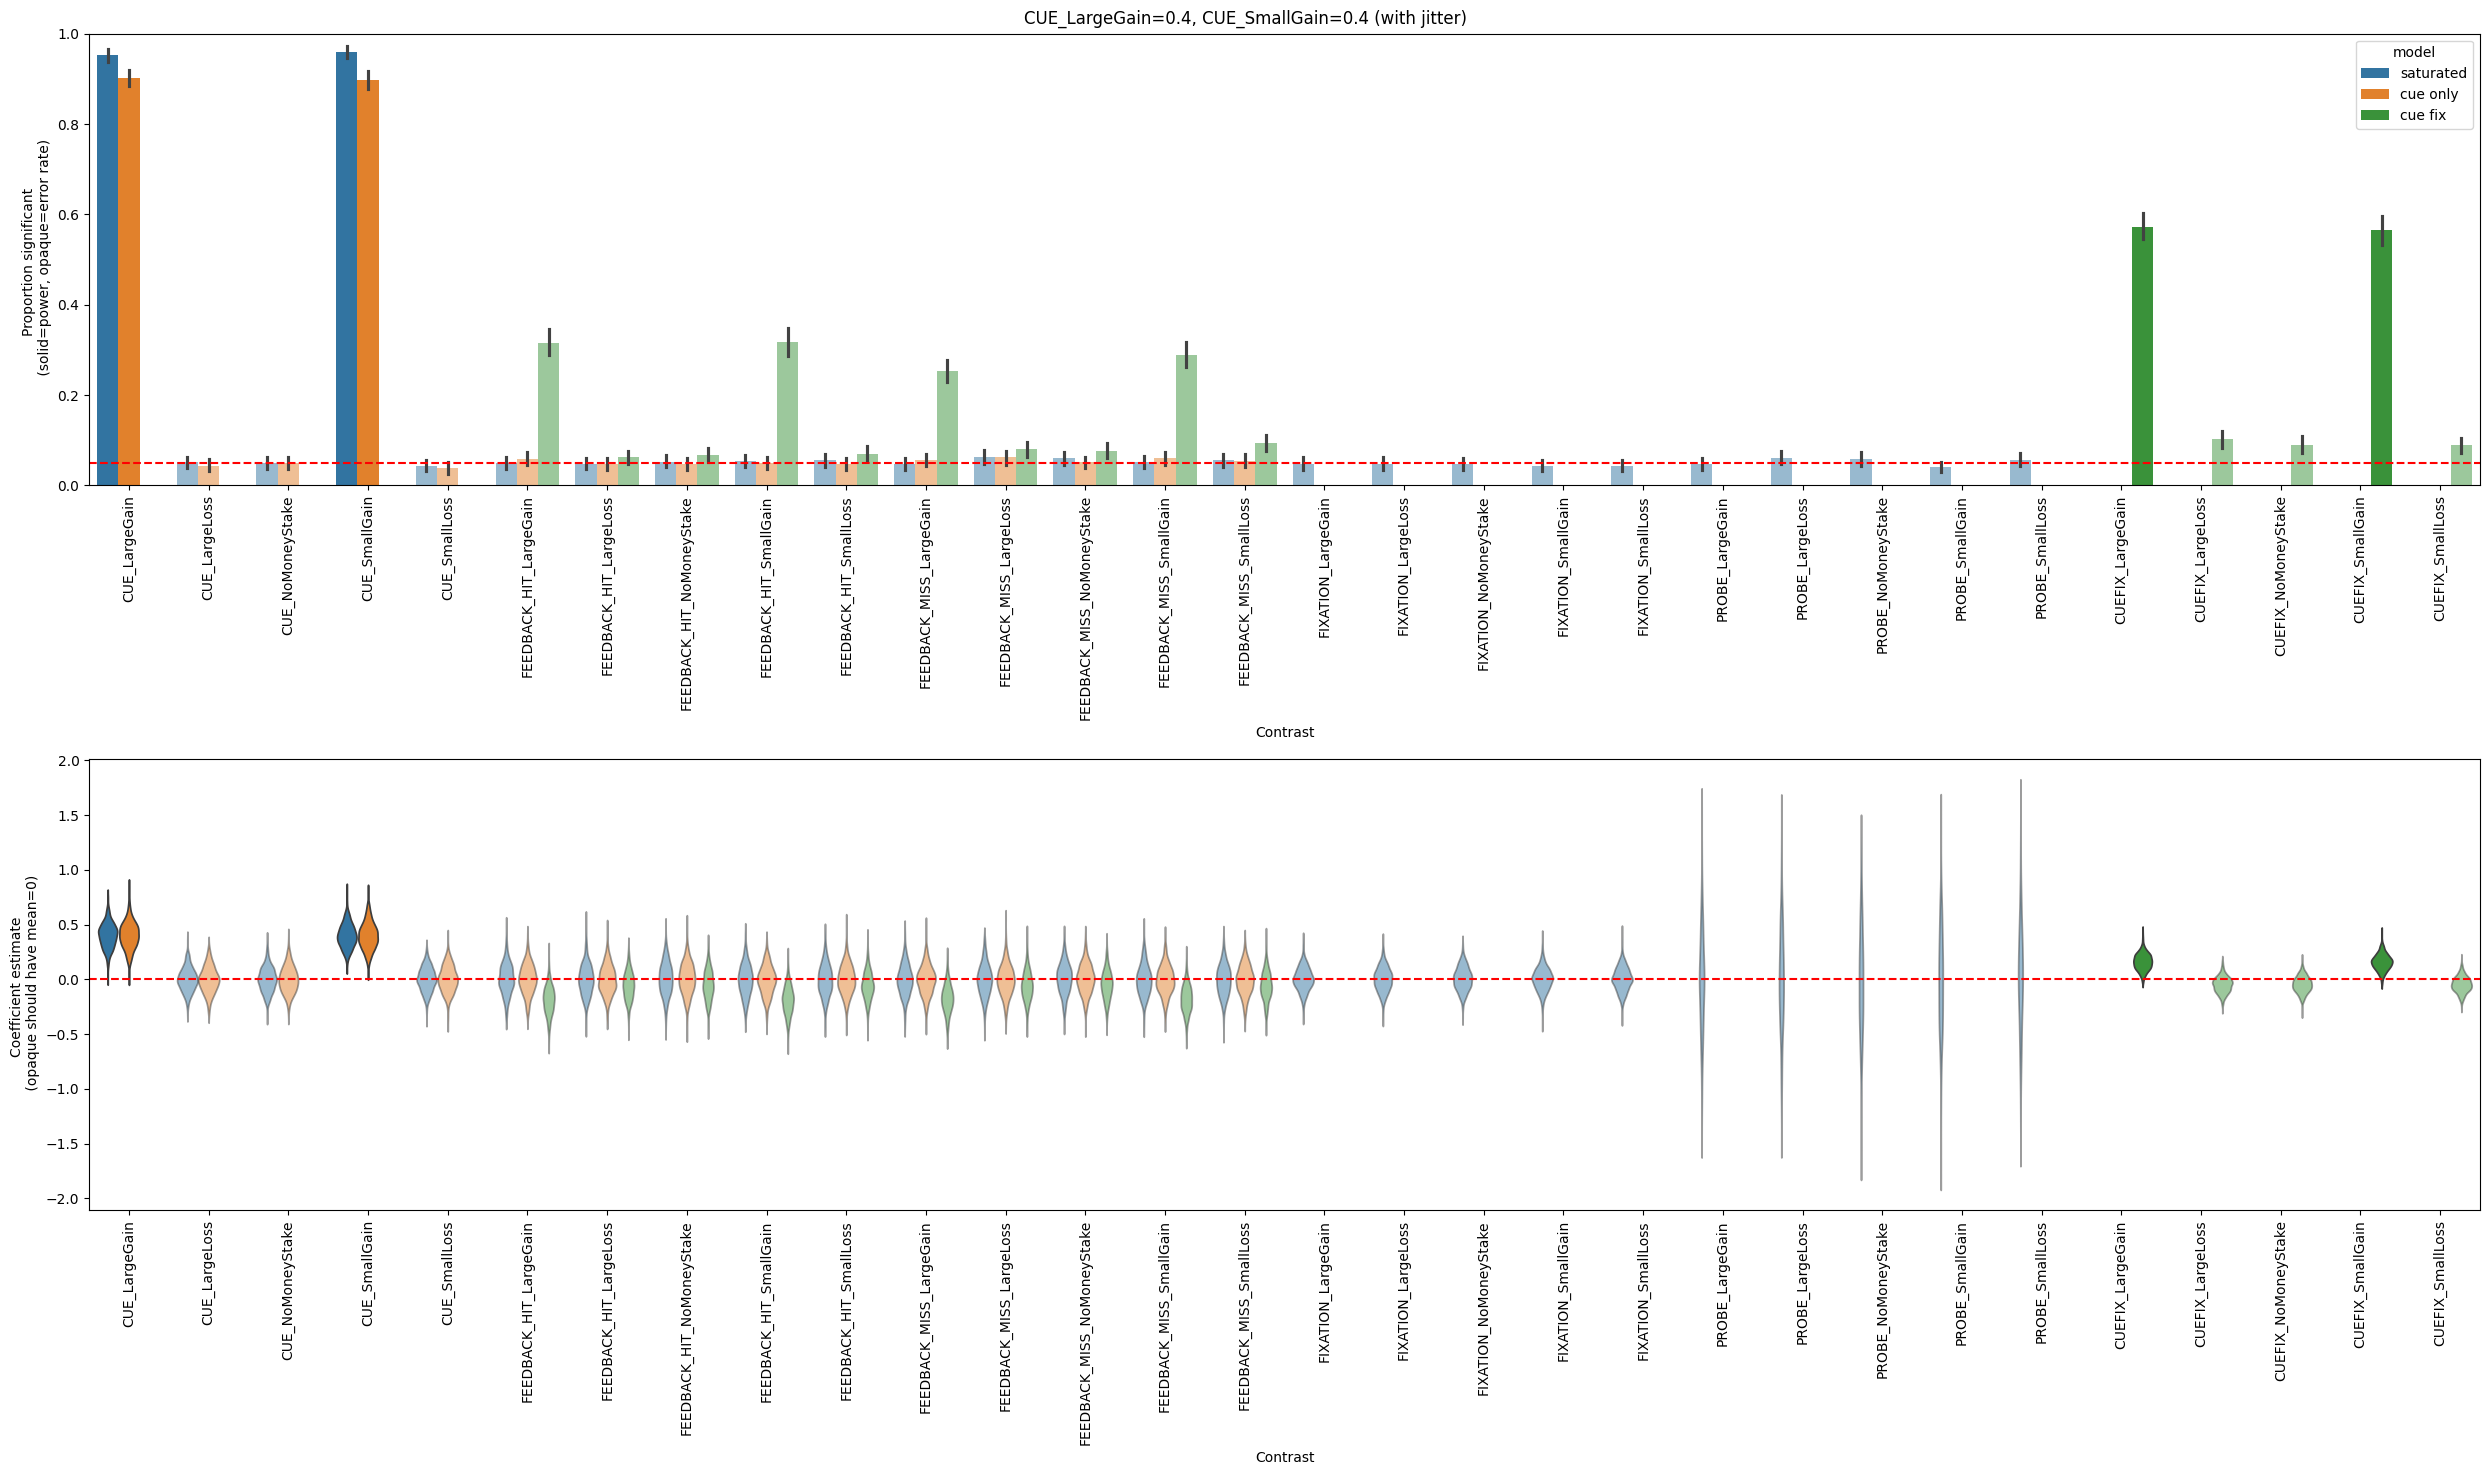

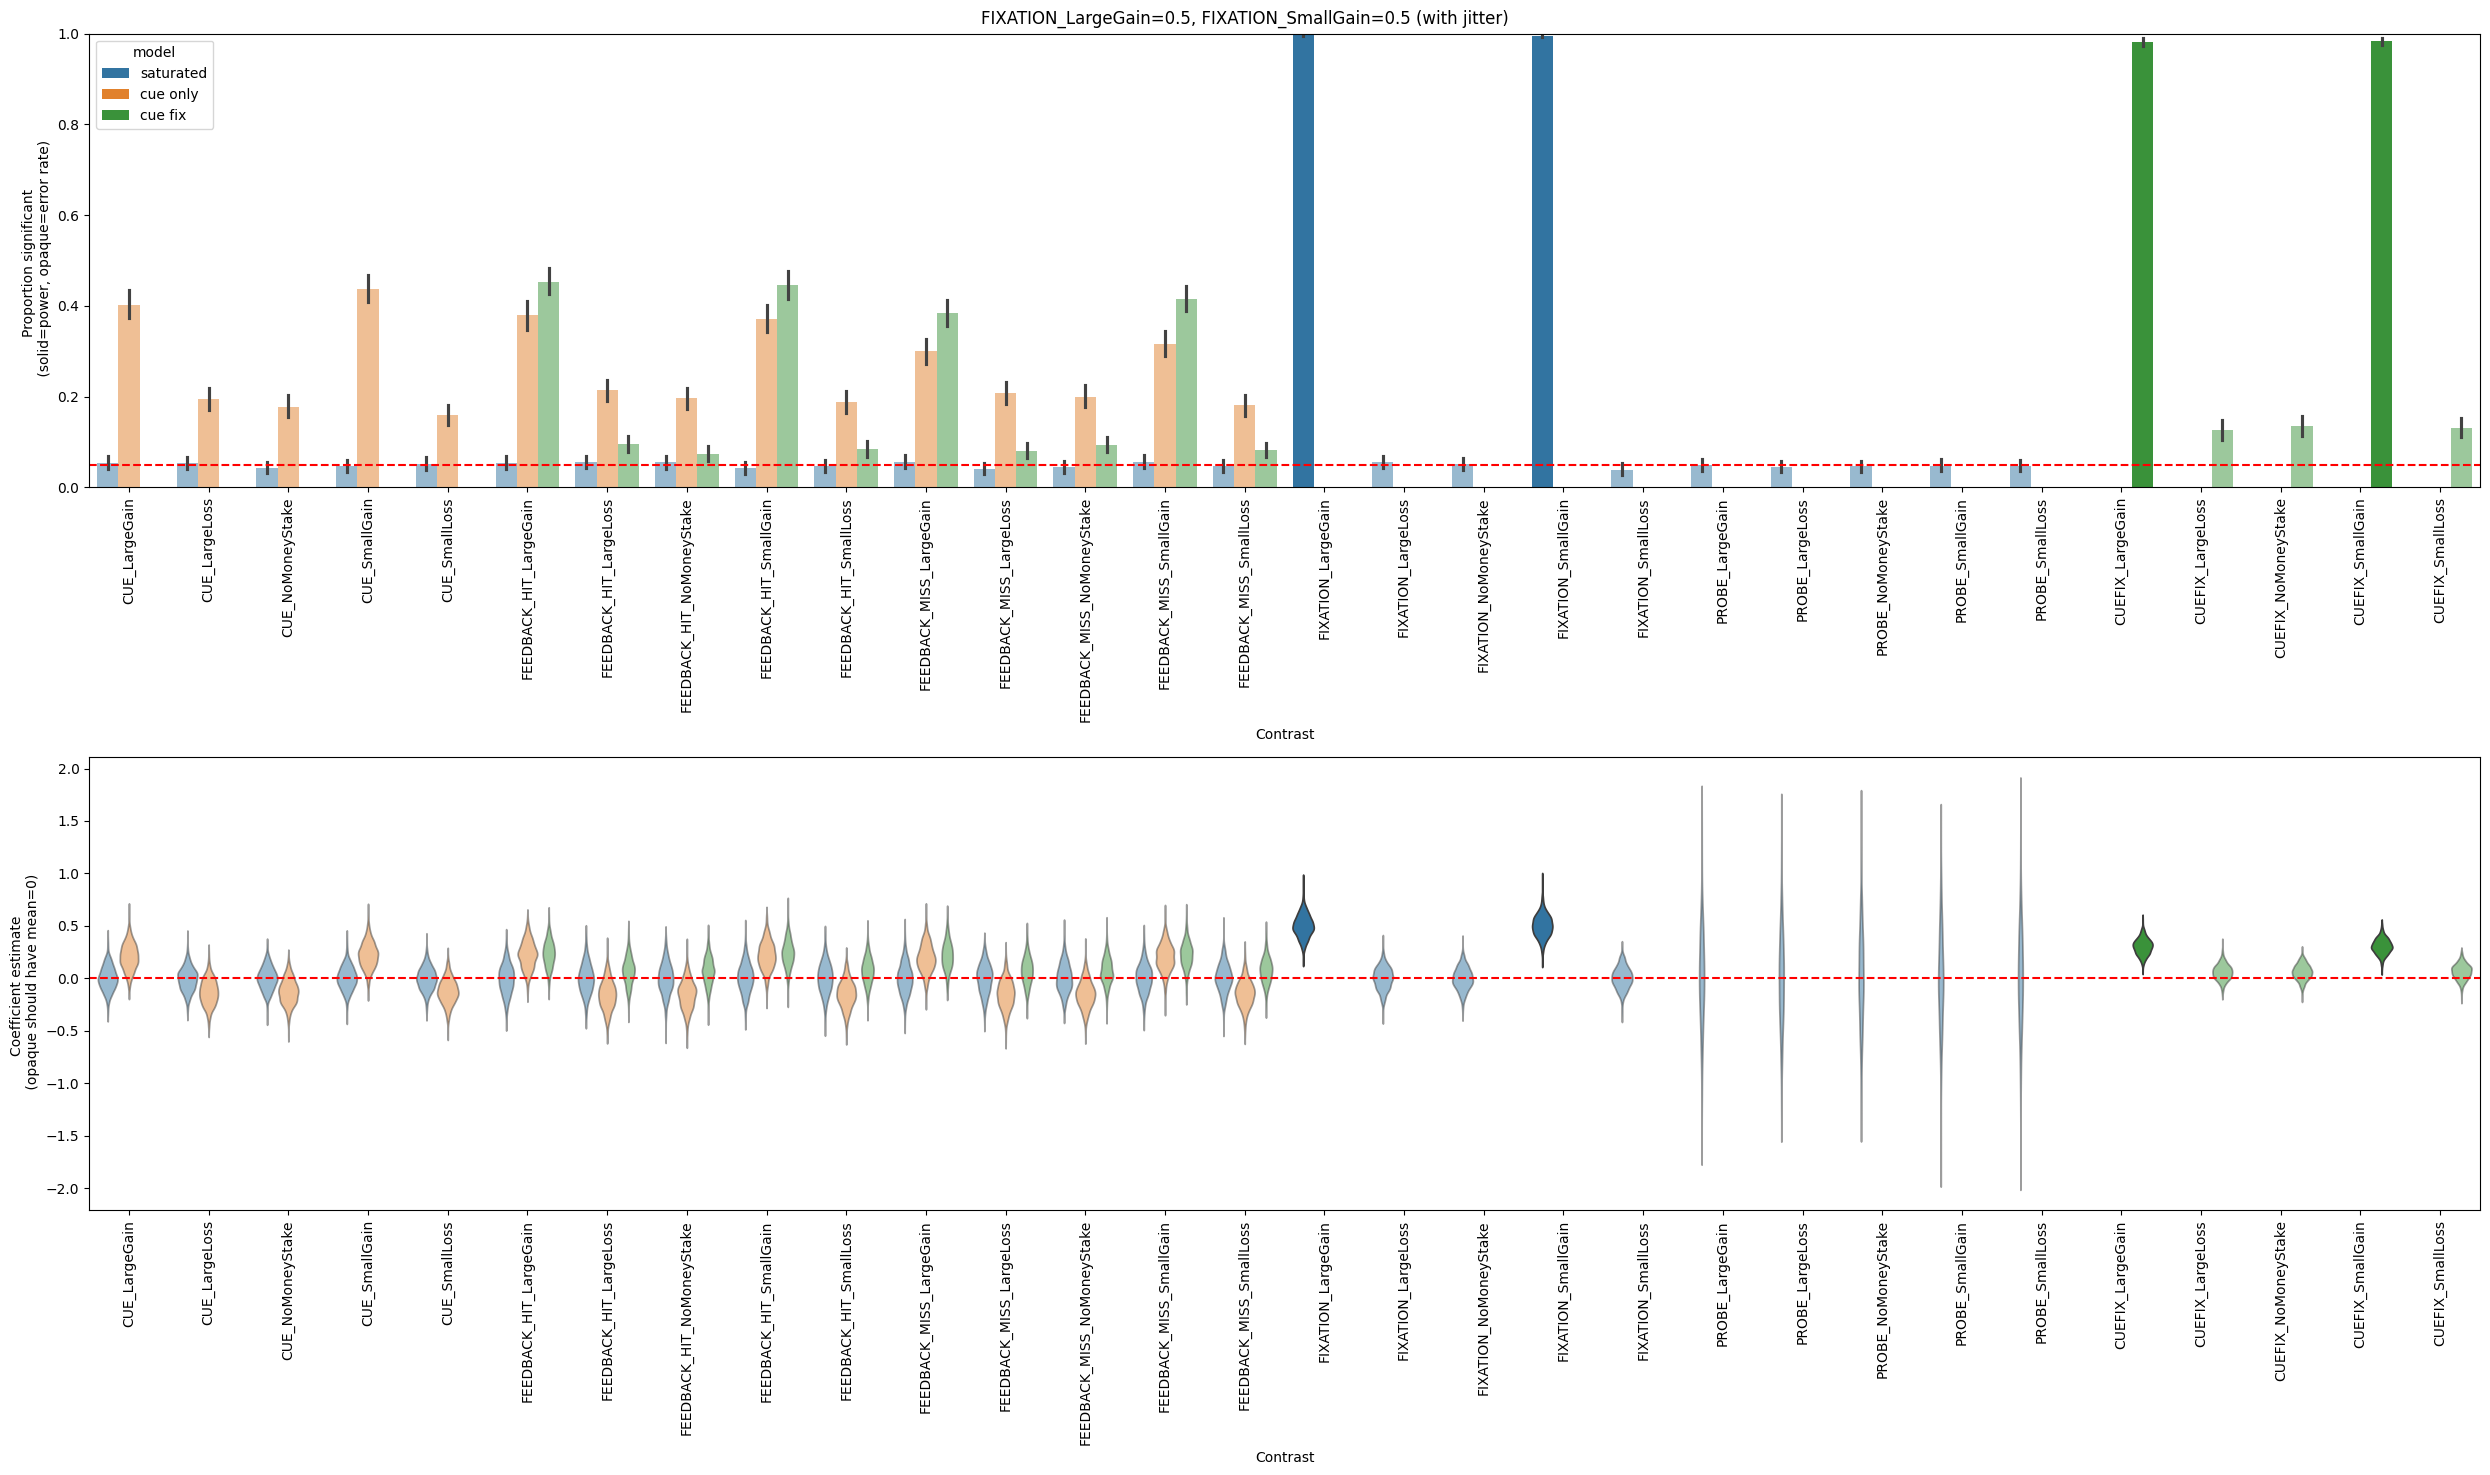

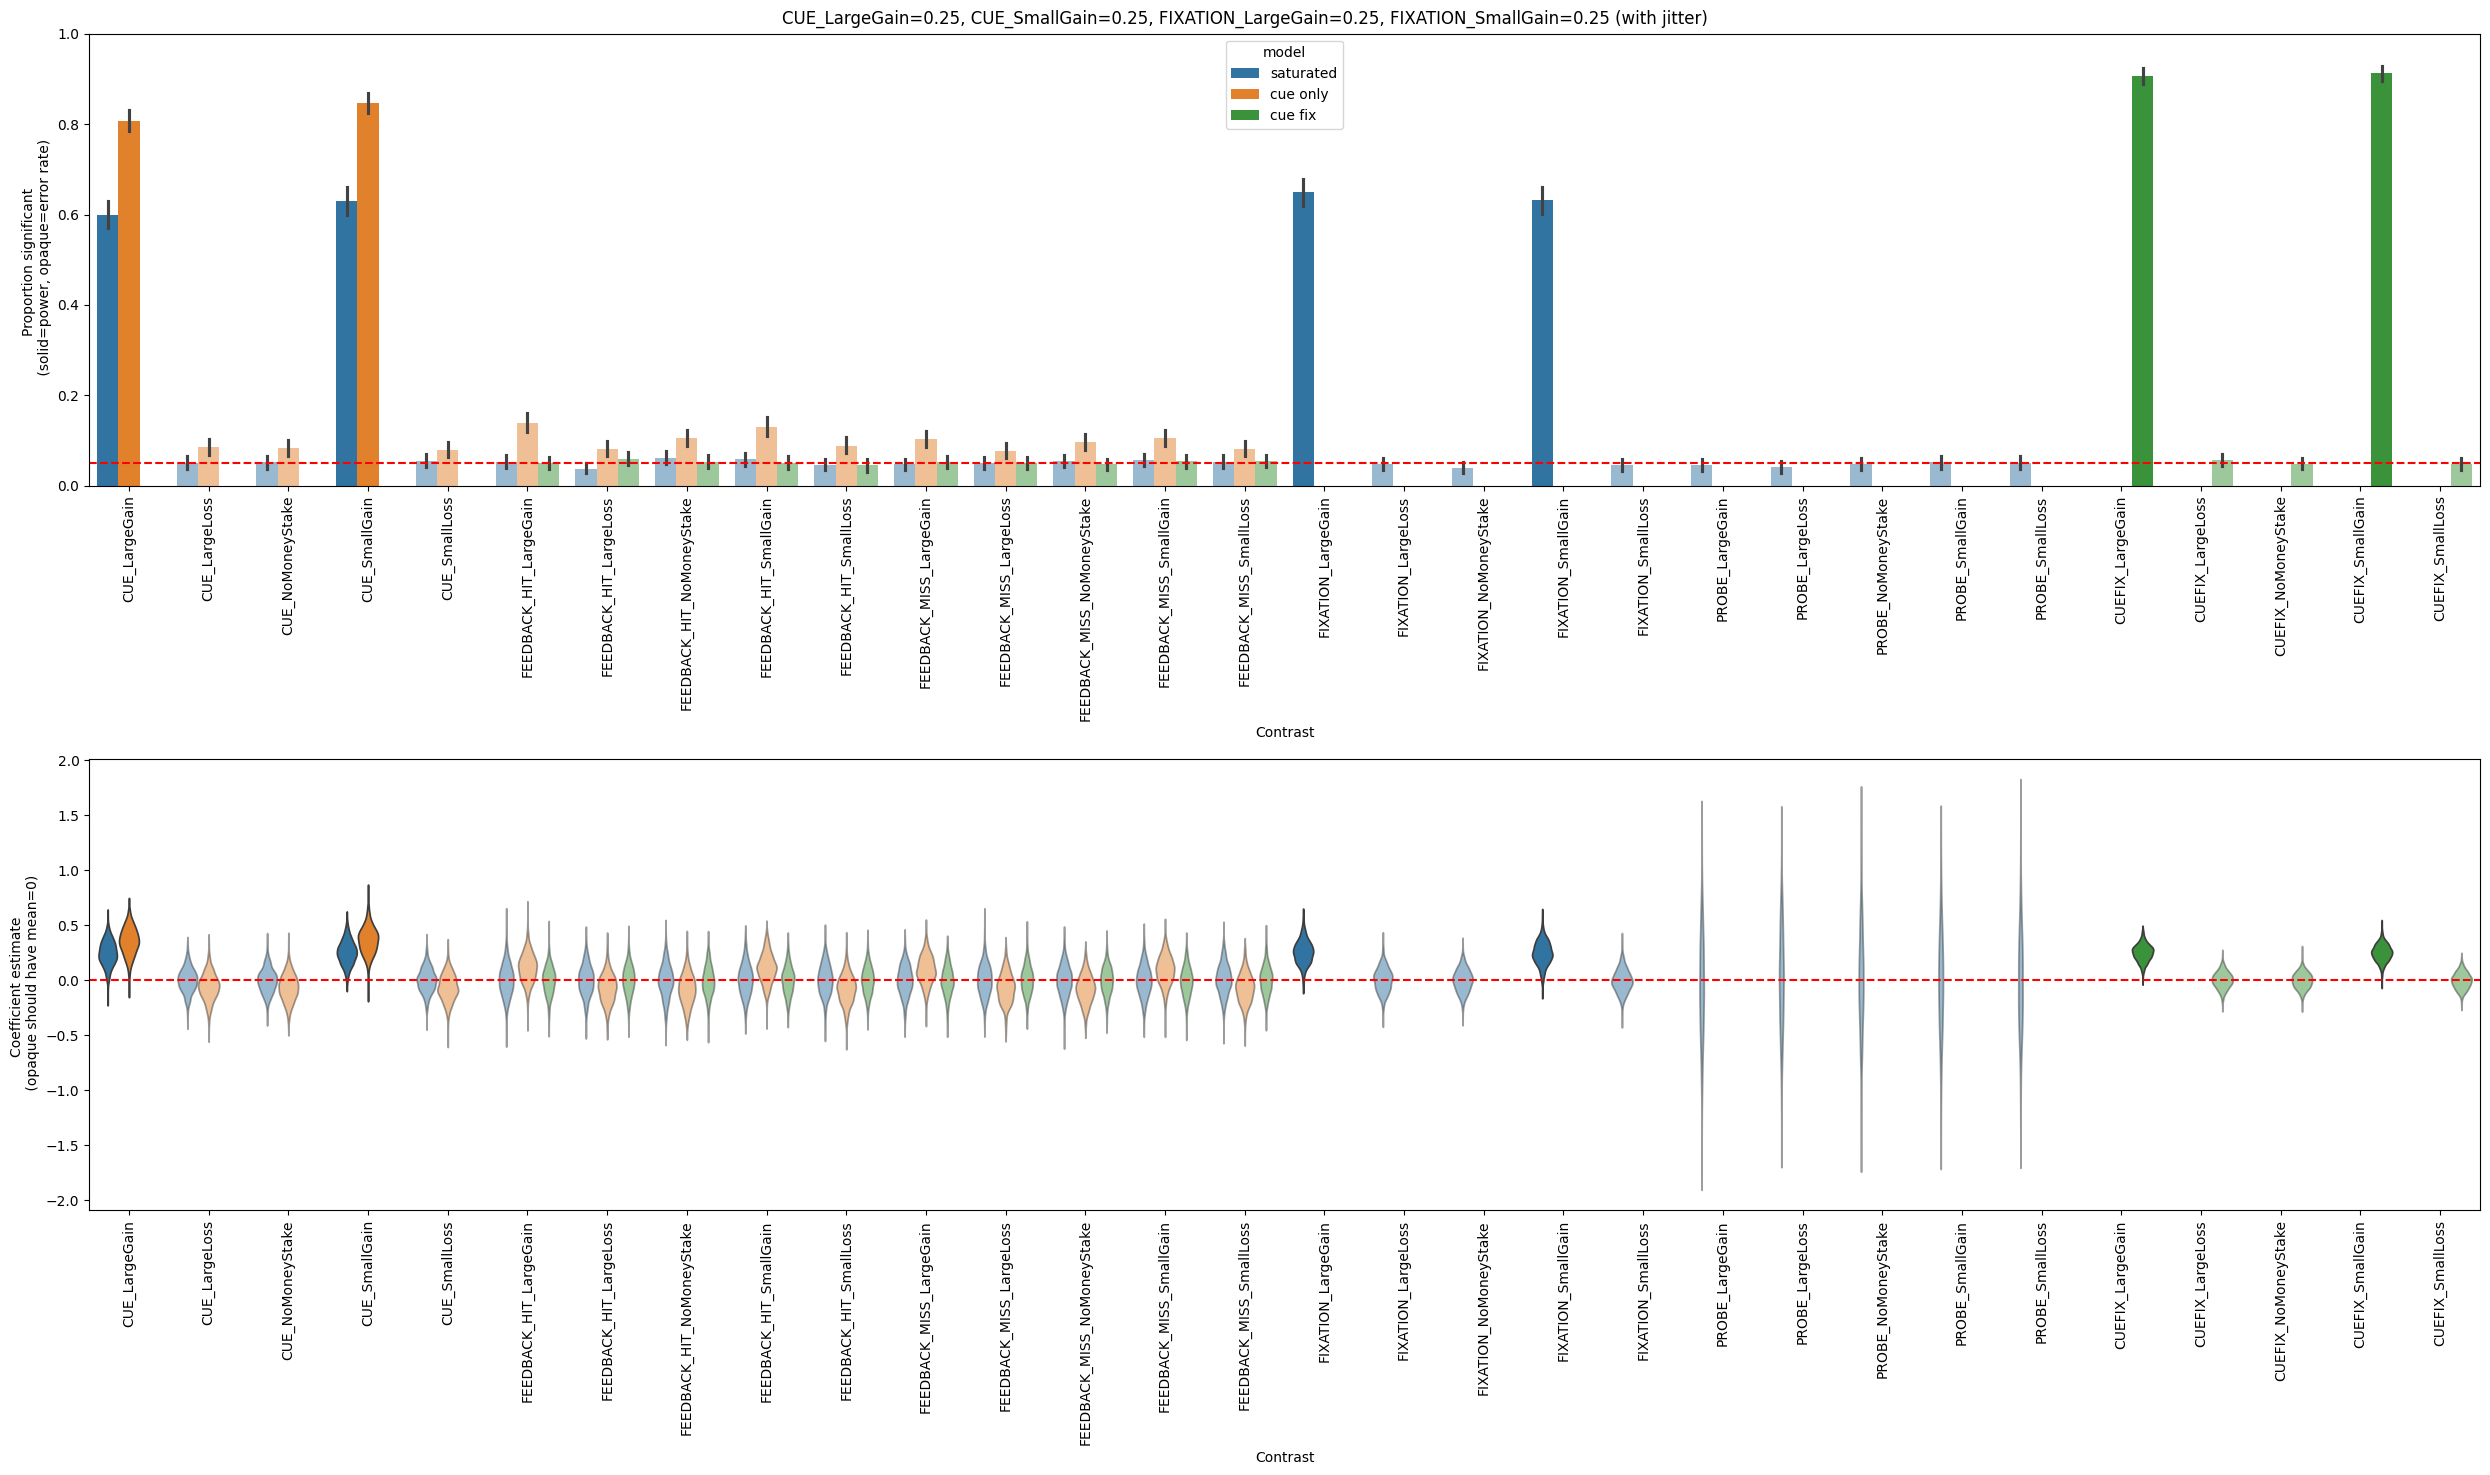

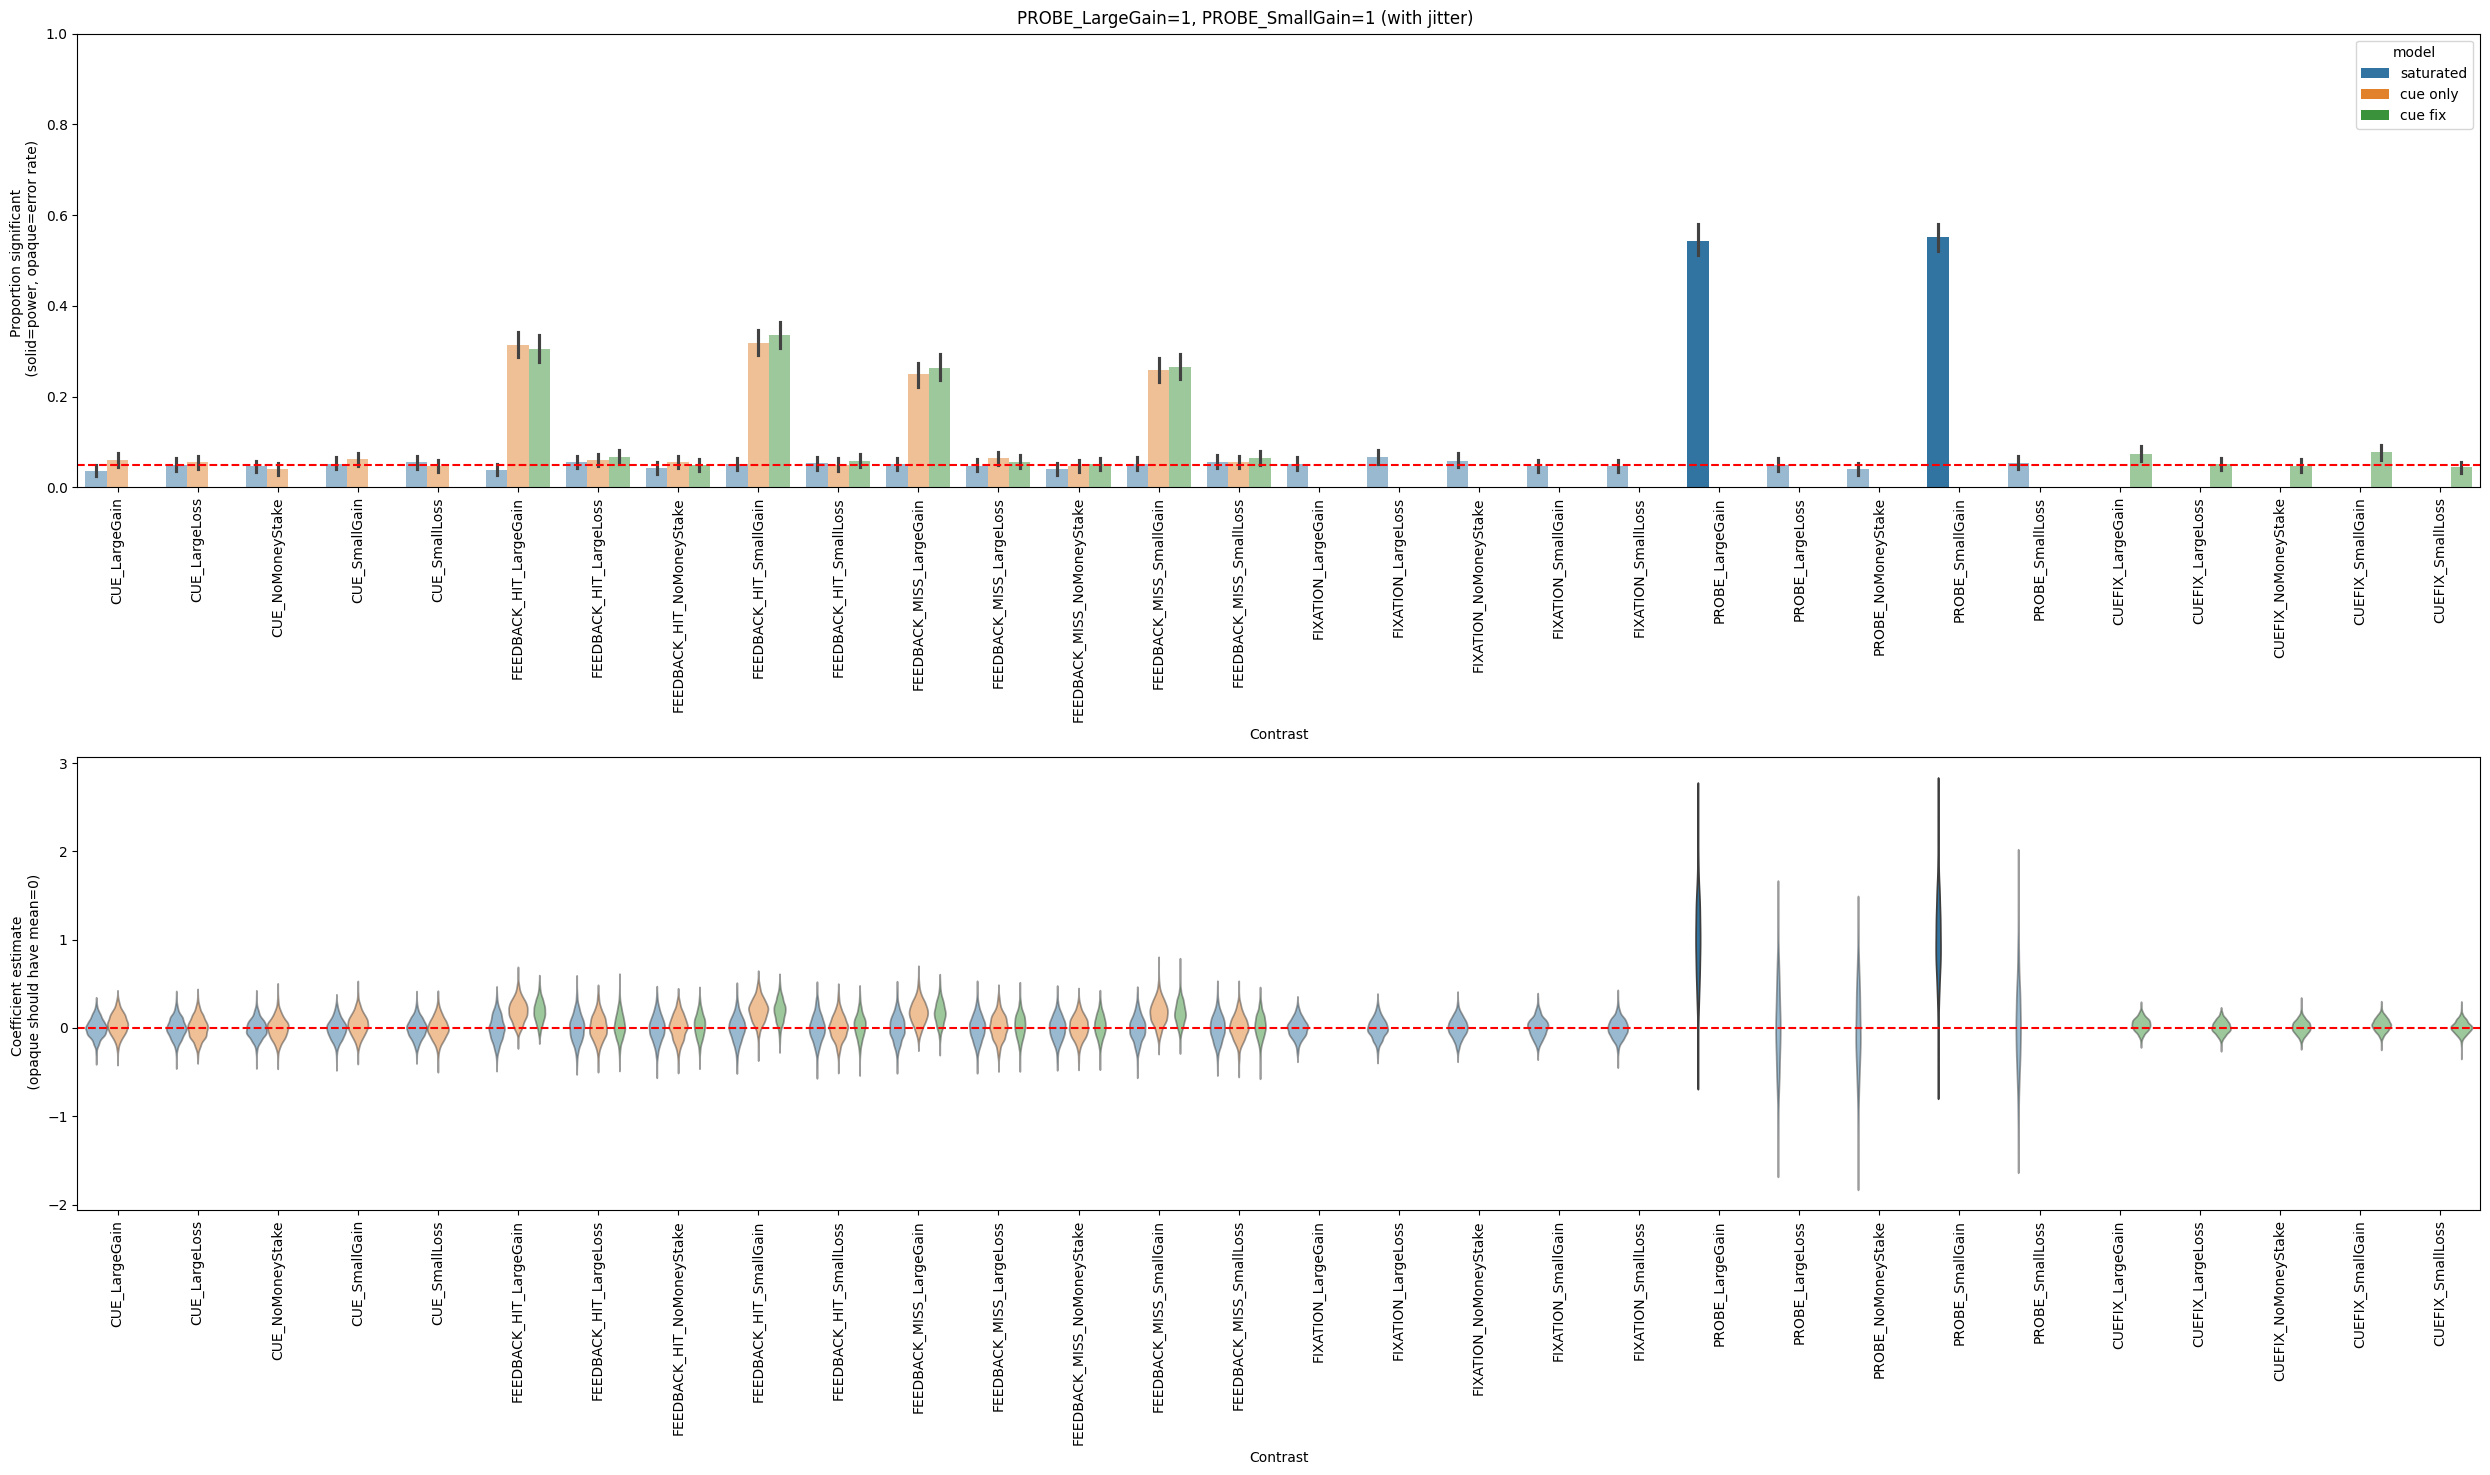

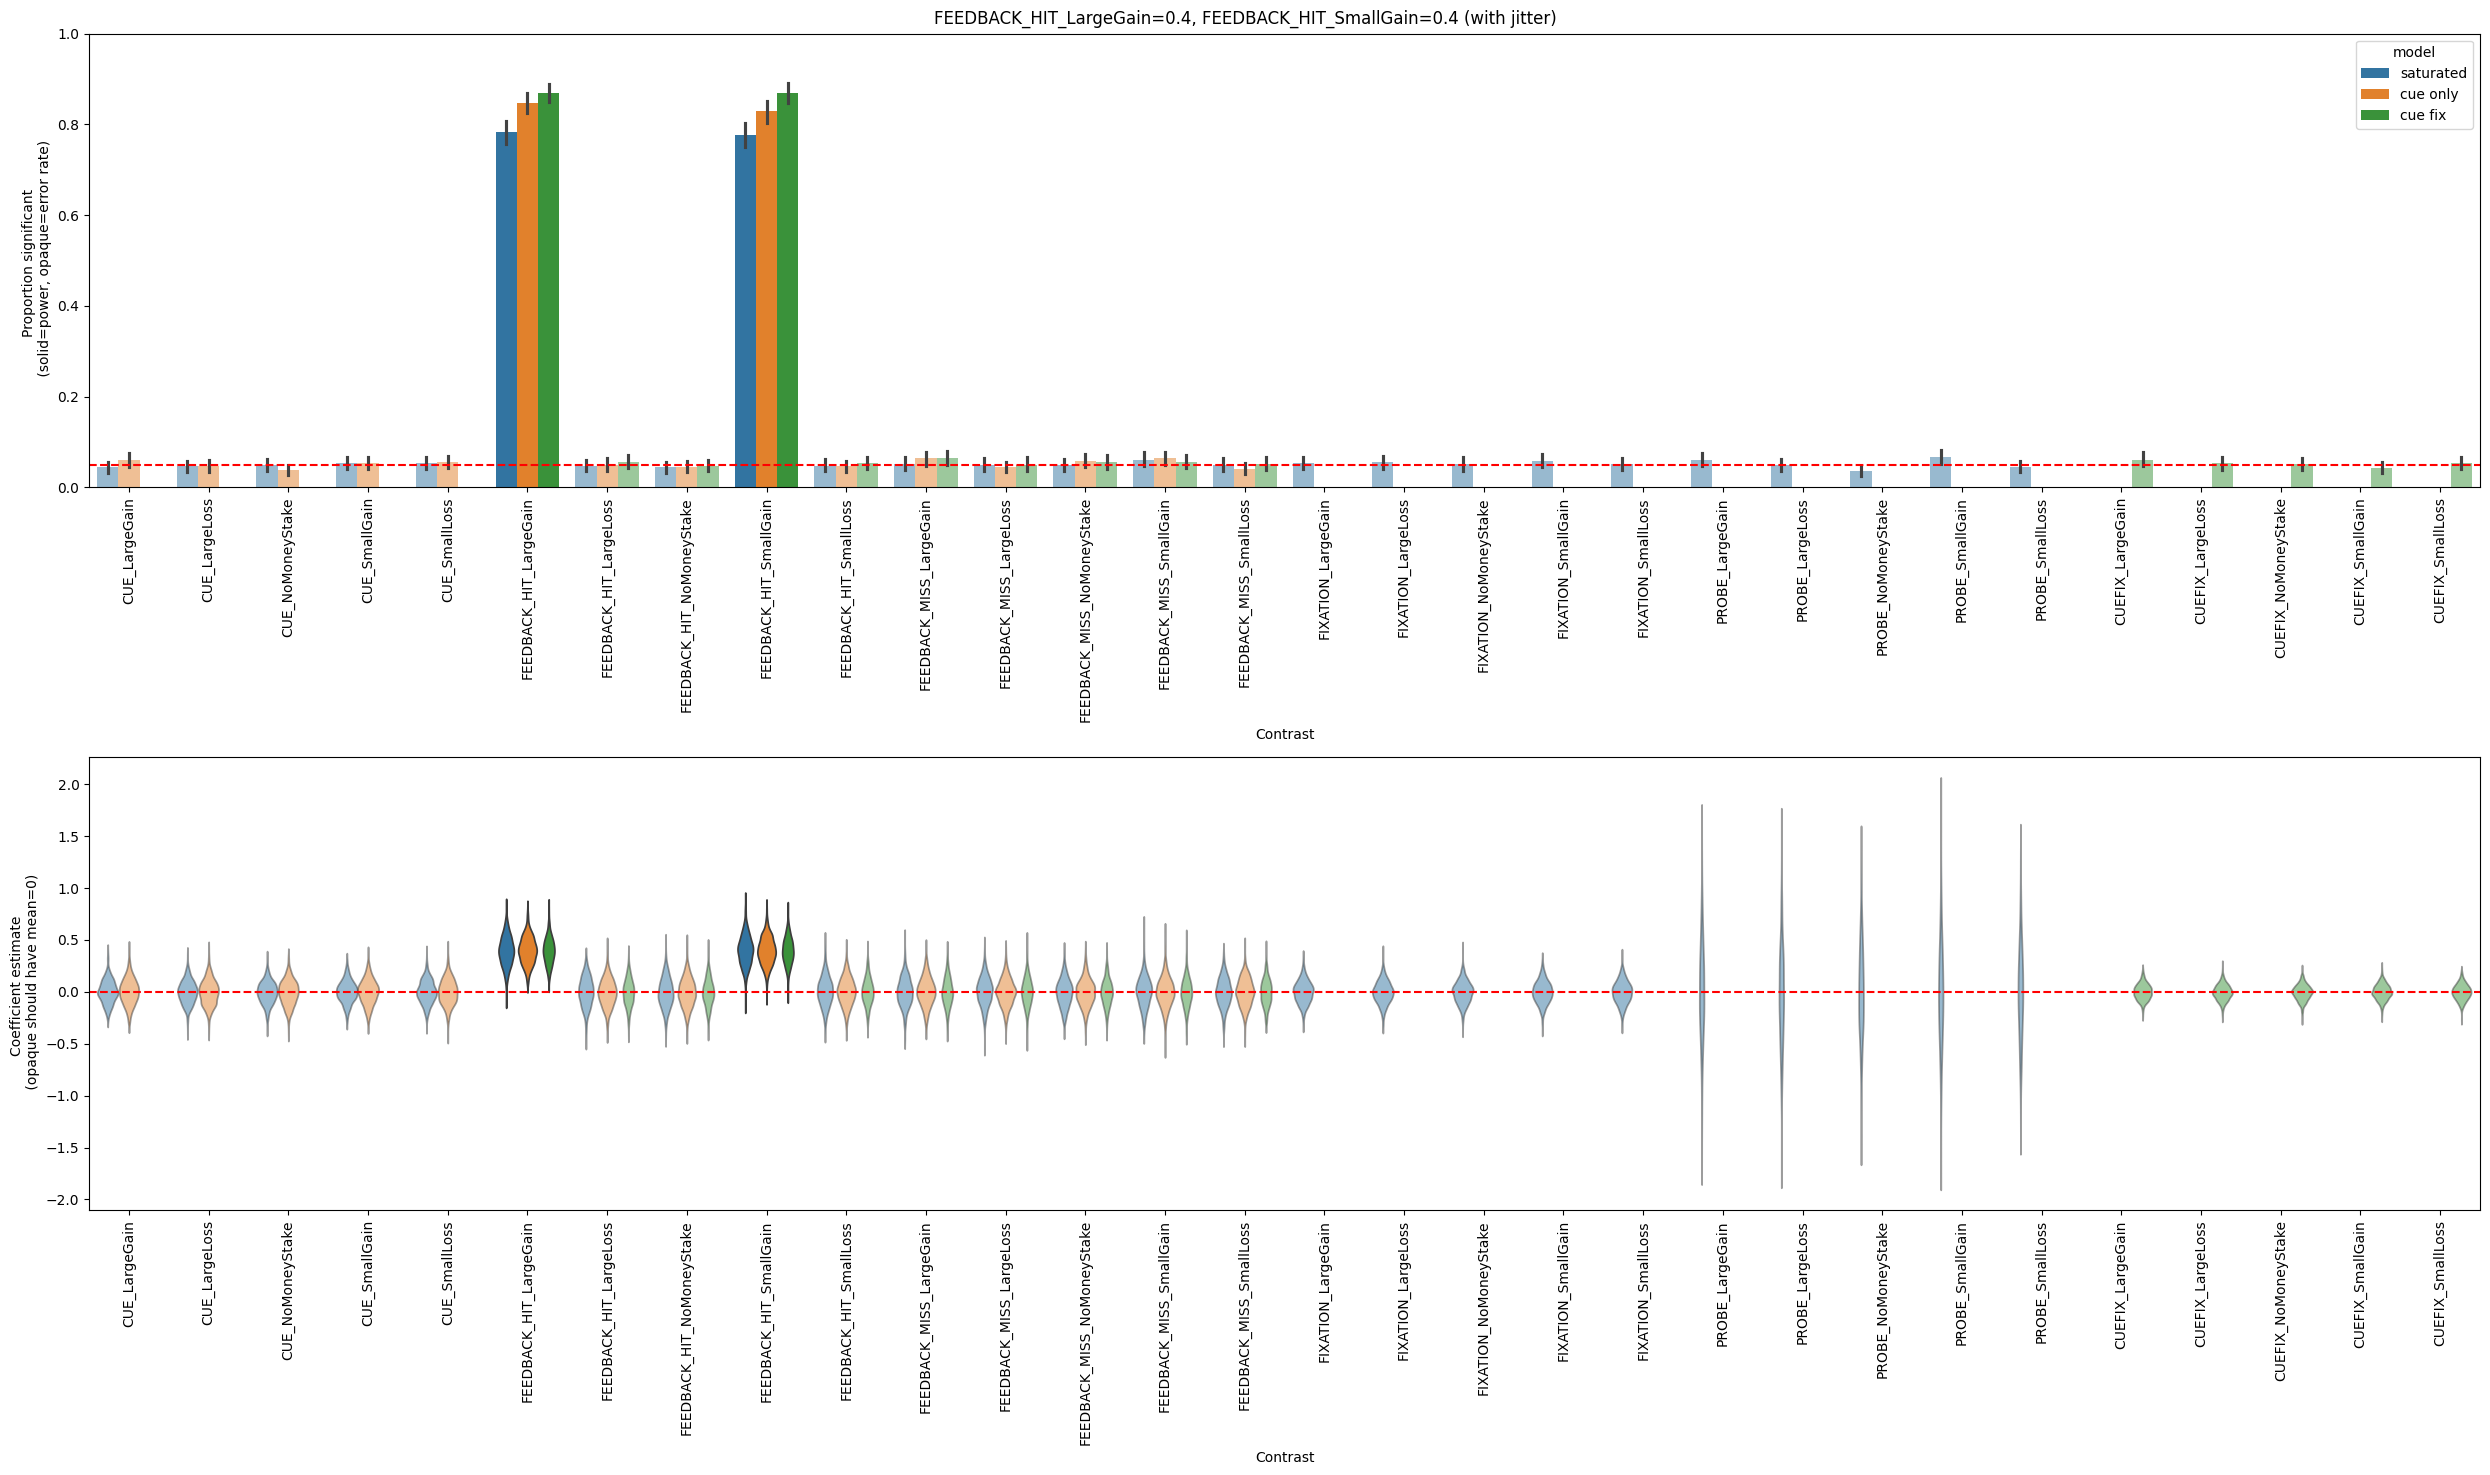

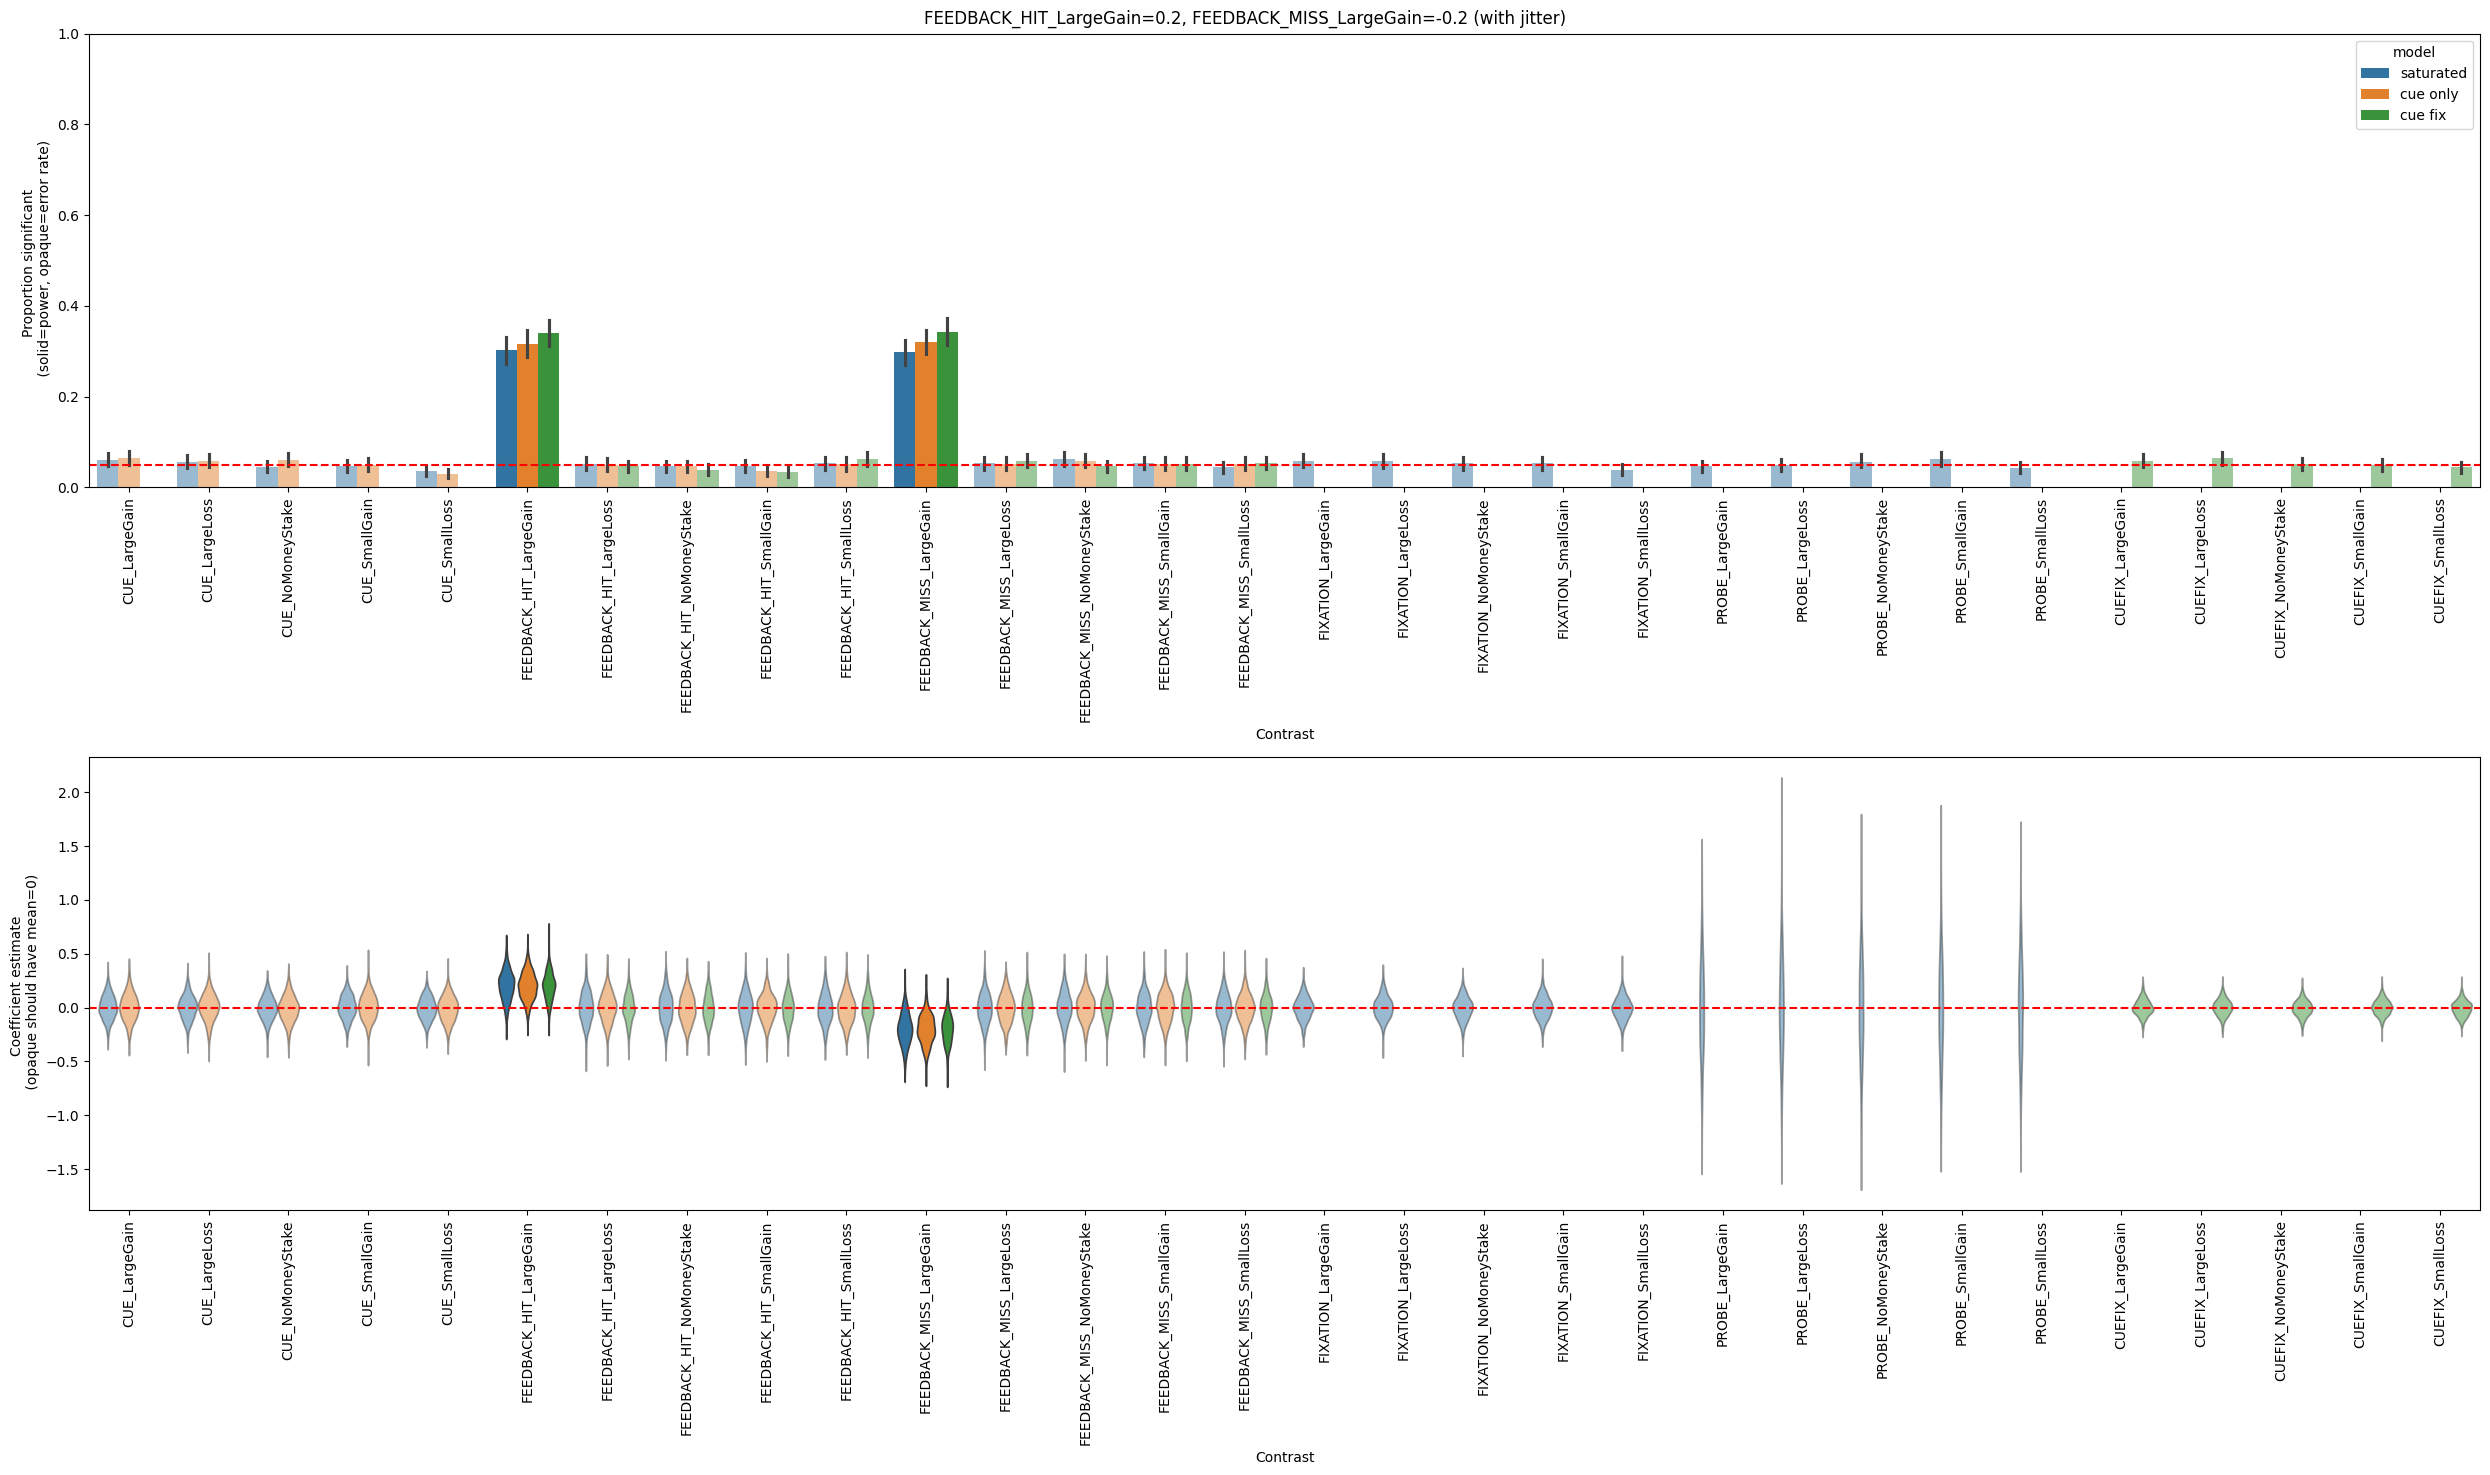

In [13]:
for name, result in results_jitter.items():
    plot_results(result[
        (result['contrast'].str.contains(":")==False)], 
        f'{name} (with jitter)', stacked=True)

# Assessing collinearity of the saturated model

The above simulations establish that the saturated model protects against bias in parameter estimates, but this is not typically the model used.  Likely the hesitation to use this model is the higher collinearity between the regressors of the saturated model compared to the cue and cue fix models.  Importantly, if a model produces biased estimates it should not be used, but we still compare the collinearity of these models using VIF and efficiency, keeping in mind the contrasts which were shown to be biased above.  It is important to put these numbers, VIF and efficiency, into context.  They both capture differing information about the variability of a within-run contrast estimate, where the VIF has a useful interpretation where values above 5 indicate high variability in estimates, which does result in a loss in power and a potential four outliers, but group level inferences are still valid.  Efficiency does not have a meaningful unit, but one can compare two efficiencies to learn how much the variance estimate of a contrast estimate will change between two models.  For example, if the efficiency of a contrast for one model is 4 times that of another, the more efficient model will have a within-run variance that is 4 times smaller!  This may seem like a considerable improvement in power, but that is not likely to be the case.  

The VIF and efficiency inform on the within-run variability of the contrast estimates and how this impacts the overall power of a study depends upon the hypothesis of interest.  First, assuming multiple runs per subject are collected, the variance of a contrast estimate for a given subject is the sum of three components, the within-run variance, $\sigma^2_{wr}$), the between-run variance (within-subject), $\sigma^2_{br}$, and the between-subject variance $\sigma^2_b$.  For hypotheses involving averages of estimates (e.g. 1-sample or 2-sample t-tests or ANOVA style analyses) power is increased when the overall variance is decreased.  On the other hand, for individual differences analyses, power increases as the intraclass correlation coefficient (ICC) increases.

Starting with analysis of group averages, at the group level, the variance of a contrast estimate from a single subject is given by
$$ 1/N_R\left[\frac{1}{eff_{con}}\sigma^2_{wr} + \sigma^2_{br}\right] + \sigma^2_b,$$
where $N_R$ is the number of runs per subject and $eff_{con}$ is the contrast efficiency.  Tyipcally the between-subject variance dominates this overall variance such that increase the number of runs or the efficiency of a contrast estimate is not as impactful on increasing power as increasing the number of subjects.  Therefore, whether or not a 4-fold increase in efficiency will have a strong impact on the power of group averages depends upon the magnitude

In the case of individual difference analyses, the ICC is defined by
$$\frac{\sigma^2_b}{\sigma^2_b + \sigma^2_{br} + \frac{1}{eff_{con}}\sigma^2_{wr}},$$
and so, once again, the impact of the efficiency is dependent upon the magnitude of the between-run and between-subject variances.  Based on results from https://www.biorxiv.org/content/10.1101/2024.03.19.585755v5.full.pdf, we know that $\sigma^2_{br} + \frac{1}{eff_{con}}\sigma^2_{wr}$ tends to be close to twice the between-subject variance (for an ICC around .3) and since the between-run variance is likely higher than $\frac{1}{eff_{con}}\sigma^2_{wr}$, it is likely that a more efficient model will have limited impact on the overall ICC.

Ultimately, whether the efficiency changes that are shown below result in meaningful differences is best captured in real data analyses. [TBD!] To illustrate this we have compared group average maps between the saturated model and the cue only model and we have also compared the ICCs of the estimates using both models.  




In [14]:
vif_eff_no_jitter = est_eff_vif_all_subs(conv_resolution=.2, tr=1)
vif_eff_yes_jitter = est_eff_vif_all_subs(conv_resolution=.2, tr=1, jitter=True, jitter_iti_min=2, jitter_iti_max=6)

Error loading sub 5: bad parsing
Error loading sub 5: bad parsing


### VIFs are reasonable across all models

The VIFs are similar for all trial types, so only Large Loss is shown below.  As expected, the VIFs are higher in the saturated model, due to collinearity, but these levels indicate an increase in variability that is reasonable (around 5 for regressors of interest).  Since the probe regressor's parameter estimate is not studied, the VIF is irrelevant.  Adding jitter between the trials does improve the VIF for the saturated model.

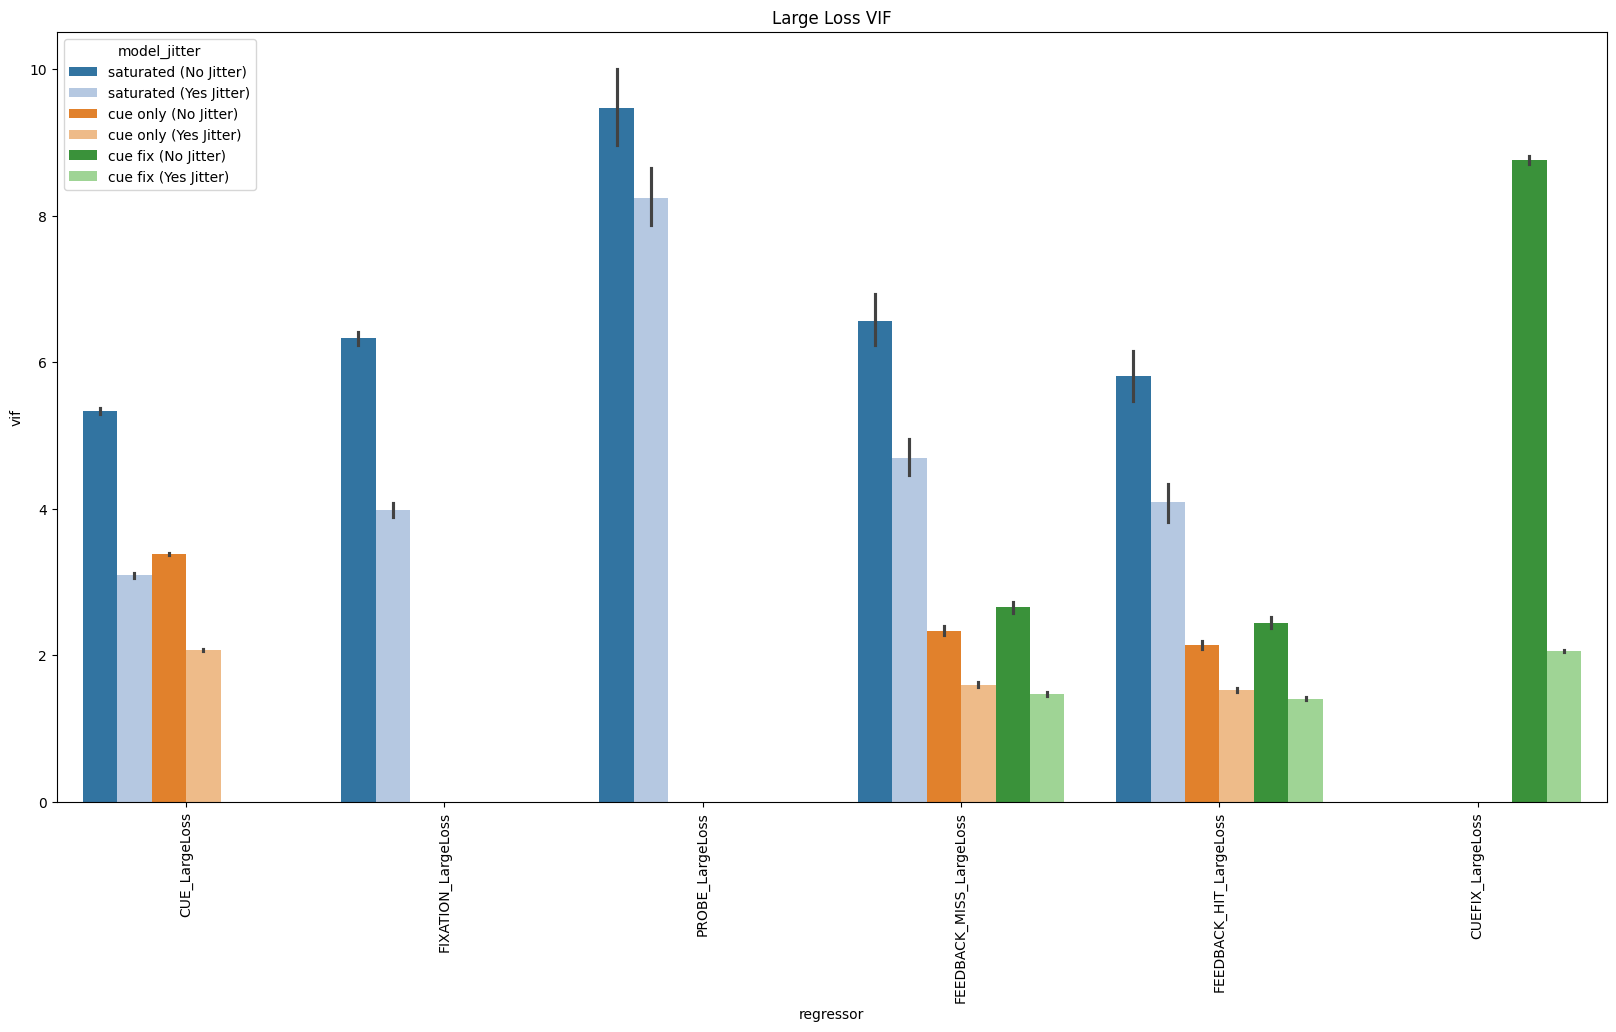

In [15]:
vif_eff_no_jitter['vifs']['Jitter'] = 'No Jitter'
vif_eff_yes_jitter['vifs']['Jitter'] = 'Yes Jitter'
vif_dat_plot = pd.concat([vif_eff_no_jitter['vifs'], vif_eff_yes_jitter['vifs']])

vif_dat_plot['model_jitter'] = vif_dat_plot['model'] + ' (' + vif_dat_plot['Jitter'] + ')'
# sufficient to just look at LargeLoss
vif_dat_large_loss = vif_dat_plot[vif_dat_plot['regressor'].str.contains('LargeLoss')]
fig = plt.subplots(1, 1, figsize=(20, 10))
hue_order = [f'{model} {jitter_type}' for model in ['saturated', 'cue only', 'cue fix'] for jitter_type in ['(No Jitter)', '(Yes Jitter)']]
sns.barplot(data=vif_dat_large_loss, x='regressor', y='vif', 
                   hue='model_jitter', hue_order=hue_order, palette='tab20')
plt.tick_params(axis='x', rotation=90)
plt.title('Large Loss VIF')
plt.show()

### Efficiency changes

Since the VIFS are higher for the regressors that contribute to the contrasts of interest, it is no surprise that the estimates for the contrasts are less efficient in the saturated model.  As explained above, this may or may not have a meaningful impact on the group averages or between-subject analaysis.  Since there are other variance terms that are likely larger than the within-run variance, it is not likely to have a large impact.

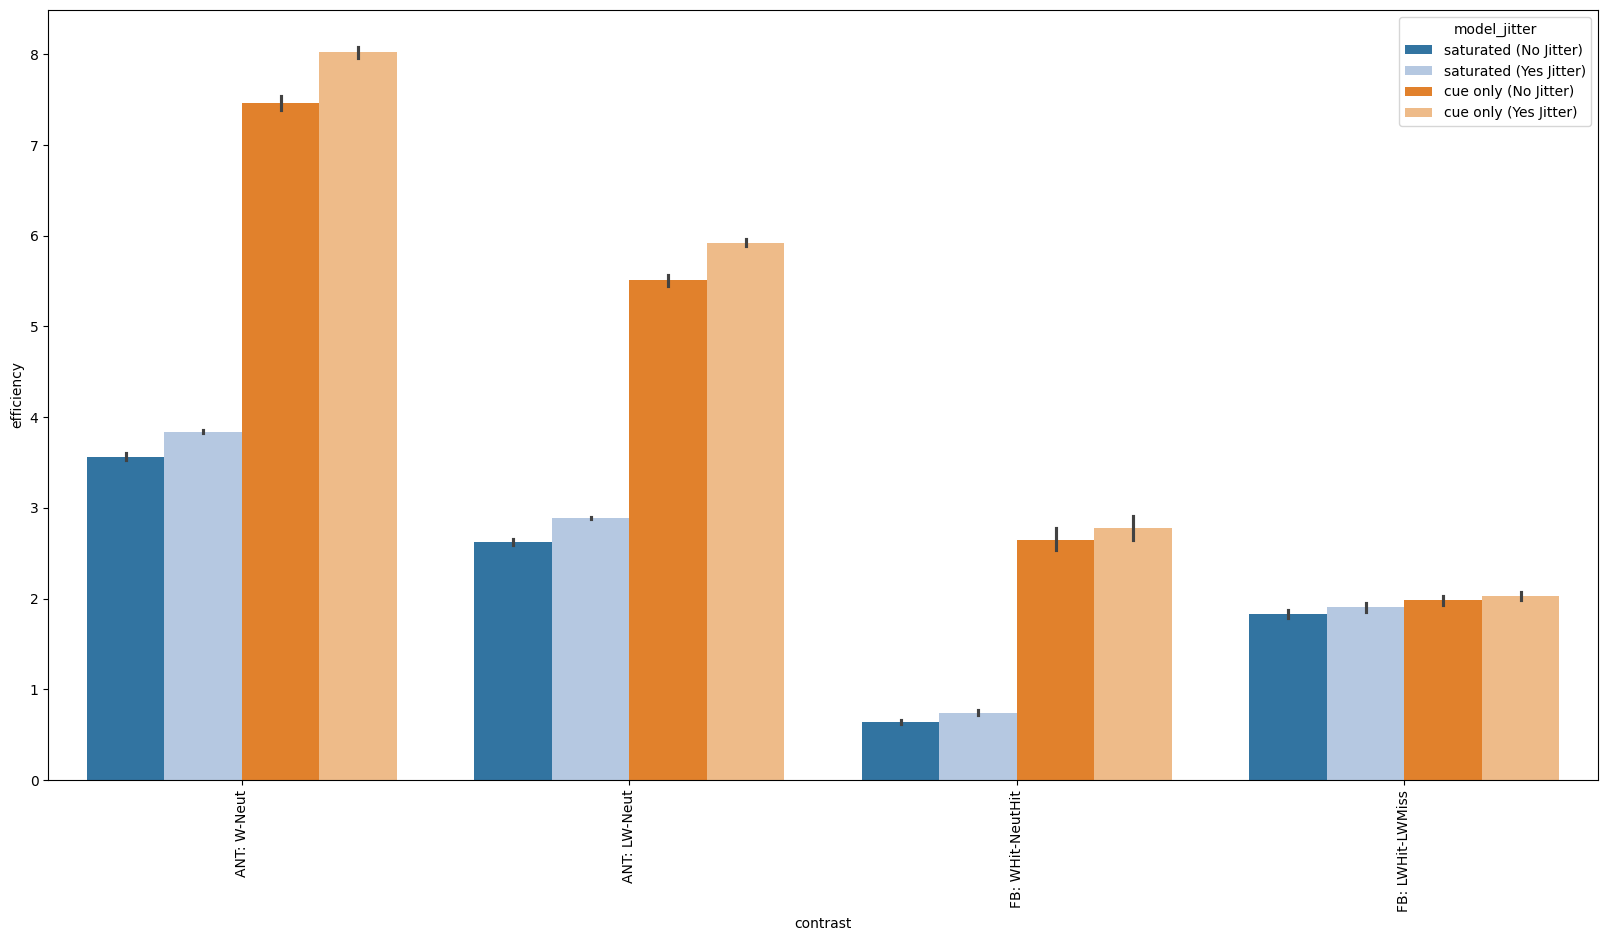

In [16]:
vif_eff_no_jitter['efficiencies']['Jitter'] = 'No Jitter'
vif_eff_yes_jitter['efficiencies']['Jitter'] = 'Yes Jitter'
eff_dat_plot = pd.concat([vif_eff_no_jitter['efficiencies'], vif_eff_yes_jitter['efficiencies']])
eff_dat_plot['model_jitter'] = eff_dat_plot['model'] + ' (' + eff_dat_plot['Jitter'] + ')'

eff_dat_no_cue_fix = eff_dat_plot[~eff_dat_plot['model'].str.contains('cue fix')]
eff_dat_no_cue_fix_contrasts = eff_dat_no_cue_fix[eff_dat_no_cue_fix['contrast'].str.contains(':')]

hue_order = [f'{model} {jitter_type}' for model in ['saturated', 'cue only'] for jitter_type in ['(No Jitter)', '(Yes Jitter)']]

fig = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(data=eff_dat_no_cue_fix_contrasts, x='contrast', y='efficiency', 
                   hue='model_jitter', hue_order=hue_order, palette='tab20')
plt.tick_params(axis='x', rotation=90)
plt.show()